In [95]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import Dataset,DataLoader
import timm.models.vision_transformer as ViT
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import default_collate 
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from tqdm import tqdm

import sys
sys.path.insert(0, '../../packages/')
from data_handlers.DustPredictionDataset import *
from training.train_model import *
from data_handlers.augmentations import *



In [96]:
# !nvidia-smi

In [97]:
# !pip install git+https://github.com/pvigier/perlin-numpy

In [98]:
# paths - to be saved in a file?

debug_dir = "../../data/tensors_debug_1/"
debug_meteorology_train_path = debug_dir+"tensor_train_meteorology.pkl"
debug_meteorology_valid_path = debug_dir+"tensor_valid_meteorology.pkl"
debug_dust_train_path = debug_dir+"tensor_train_dust.pkl"
debug_dust_valid_path = debug_dir+"tensor_valid_dust.pkl"

data_dir = "../../data/tensors_meteo20000101to20210630_dust_0_m24_24_48_72/"
split1_dir = data_dir+"split1_ordered/"
split2_dir = data_dir+"split2_extreme_ratios_in_train_avg_in_valid/"
split3_dir = data_dir+"split3_extreme_ratios_in_valid_avg_in_train/"
split4_dir = data_dir+"split4_max_num_events_in_train_avg_valid/"
split5_dir = data_dir+"split5_train_distant_years_valid_between/"
split_dirs = [split1_dir,split2_dir,split3_dir,split4_dir,split5_dir]
meteorology_train_paths = [split+"tensor_train_meteorology.pkl" for split in split_dirs]
meteorology_valid_paths = [split+"tensor_valid_meteorology.pkl" for split in split_dirs]
dust_train_paths = [split+"tensor_train_dust.pkl" for split in split_dirs]
dust_valid_paths = [split+"tensor_valid_dust.pkl" for split in split_dirs]

metadata_dir = "../../data/metadata_meteo20000101to20210630_dust_0_m24_24_48_72/"
metadata_columns_path = metadata_dir+"all_columns.pkl"
metadata_yearly_statistics_path = metadata_dir+"yearly_statistics.pkl"
metadata_all_times_path = metadata_dir+"all_times.pkl"
metadata_times_split1_train_path = metadata_dir+"split1_ordered_train_times.pkl"
metadata_times_split2_train_path = metadata_dir+"split2_extreme_ratios_in_train_avg_in_valid_train_times.pkl"
metadata_times_split3_train_path = metadata_dir+"split3_extreme_ratios_in_valid_avg_in_train_train_times.pkl"
metadata_times_split4_train_path = metadata_dir+"split4_max_num_events_in_train_avg_valid_train_times.pkl"
metadata_times_split5_train_path = metadata_dir+"split5_train_distant_years_valid_between_train_times.pkl"
metadata_times_train_paths = [metadata_times_split1_train_path,metadata_times_split2_train_path,
                              metadata_times_split3_train_path,metadata_times_split4_train_path,
                              metadata_times_split5_train_path]
metadata_times_split1_valid_path = metadata_dir+"split1_ordered_valid_times.pkl"
metadata_times_split2_valid_path = metadata_dir+"split2_extreme_ratios_in_train_avg_in_valid_valid_times.pkl"
metadata_times_split3_valid_path = metadata_dir+"split3_extreme_ratios_in_valid_avg_in_train_valid_times.pkl"
metadata_times_split4_valid_path = metadata_dir+"split4_max_num_events_in_train_avg_valid_valid_times.pkl"
metadata_times_split5_valid_path = metadata_dir+"split5_train_distant_years_valid_between_valid_times.pkl"
metadata_times_valid_paths = [metadata_times_split1_valid_path,metadata_times_split2_valid_path,
                              metadata_times_split3_valid_path,metadata_times_split4_valid_path,
                              metadata_times_split5_valid_path]

In [99]:
# TBD: get times of debug dataset
# import sys
# sys.path.insert(0, '../../packages/data_handlers')
# from Dataset_handler import *
# debug_dataset_handler = torch.load(debug_dir+"dummy_dataset_handler.pkl") # not working
times_debug = torch.load(metadata_times_split1_valid_path)[:48] # incorrect times - to be corrected
len(times_debug)

48

In [100]:
torch.load(metadata_columns_path)

Index(['SLP', 'Z', 'U', 'V', 'PV', 'dust_0', 'delta_0', 'dust_m24',
       'delta_m24', 'dust_24', 'delta_24', 'dust_48', 'delta_48', 'dust_72',
       'delta_72'],
      dtype='object')

In [101]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [102]:
# # debug
# train_dataset = DustPredictionDataset(torch.load(debug_meteorology_train_path),
#                                       torch.load(debug_dust_train_path),times_debug)
# valid_dataset = DustPredictionDataset(torch.load(debug_meteorology_valid_path),
#                                       torch.load(debug_dust_valid_path),times_debug)
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,collate_fn=train_dataset.collate_fn)
# valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True,collate_fn=valid_dataset.collate_fn)

# model = ViT.VisionTransformer(img_size=(81,81), patch_size=(9,9), in_chans=17, num_classes=10, embed_dim=512, depth=8,
#                  num_heads=8, mlp_ratio=4., qkv_bias=True, representation_size=None, distilled=False,
#                  drop_rate=0., attn_drop_rate=0., drop_path_rate=0.)
# model = model.to(device)

# lr = 0.01
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# debug_best_path = debug_dir+"best_debug_model.pt"
# debug_last_path = debug_dir+"last_debug_model.pt"

# num_epochs = 8
# (debug_train_losses,debug_valid_losses,
#  debug_train_lags_loss,debug_train_delta_lags_losses,
#  debug_valid_lags_loss,debug_valid_delta_lags_losses) = train_loop(model, optimizer, train_loader, valid_loader, 
#                                                                    device, epochs=num_epochs, valid_every=1, 
#                                                                    loss_cfg=None, sample_predictions_every=2, 
#                                                                    sample_size=5, sample_cols=[0],loss_plot_end=True,
#                                                                    save_best_model_dict_to=debug_best_path, 
#                                                                    save_last_model_dict_to=debug_last_path)
# debug_train_lags_loss.shape,debug_train_delta_lags_losses.shape,debug_valid_delta_lags_losses.shape

In [103]:
# # checking augmentation:

# perlin_augmentation = PerlinAugmentation(torch.load(debug_meteorology_train_path)[:11,:,:,:], 
#                                          torch.load(debug_dust_train_path)[:11,:], debug=True)

# train_dataset = DustPredictionDataset(torch.load(debug_meteorology_train_path),
#                                       torch.load(debug_dust_train_path),times_debug, augmentation=perlin_augmentation)
# valid_dataset = DustPredictionDataset(torch.load(debug_meteorology_valid_path),
#                                       torch.load(debug_dust_valid_path),times_debug)
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,collate_fn=train_dataset.collate_fn)
# valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True,collate_fn=valid_dataset.collate_fn)

# model = ViT.VisionTransformer(img_size=(81,81), patch_size=(9,9), in_chans=17, num_classes=10, embed_dim=512, depth=8,
#                  num_heads=8, mlp_ratio=4., qkv_bias=True, representation_size=None, distilled=False,
#                  drop_rate=0., attn_drop_rate=0., drop_path_rate=0.)
# model = model.to(device)

# lr = 0.01
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# debug_best_path = debug_dir+"best_debug_model.pt"
# debug_last_path = debug_dir+"last_debug_model.pt"

# num_epochs = 8
# (debug_train_losses,debug_valid_losses,
#  debug_train_lags_loss,debug_train_delta_lags_losses,
#  debug_valid_lags_loss,debug_valid_delta_lags_losses) = train_loop(model, optimizer, train_loader, valid_loader, 
#                                                                    device, epochs=num_epochs, valid_every=1, 
#                                                                    loss_cfg=None, sample_predictions_every=2, 
#                                                                    sample_size=5, sample_cols=[0],loss_plot_end=True,
#                                                                    save_best_model_dict_to=debug_best_path, 
#                                                                    save_last_model_dict_to=debug_last_path)
# debug_train_lags_loss.shape,debug_train_delta_lags_losses.shape,debug_valid_delta_lags_losses.shape


In [104]:
# !nvidia-smi

In [105]:
results_dir = "../../results_models/presentation/"
#
presentation_dir = data_dir+"presentation_set/"

In [106]:
# # Presentation set, no augmentation, weighted loss with high deltas weights (10)

# results_dir_specific = results_dir+"presentation_set_e600_lr0p0001_noaugmentation_weighted_loss_high_deltas/"

# loss_cfg = LossConfig(device, weights_lags=[10.,1.,1.,1.,1.], weights_delta_lags=[50.,50.,50.,50.,50.])


# best_model_path = results_dir_specific+"best_model_state.pt"
# last_model_path = results_dir_specific+"last_model_state.pt"

# train_losses_path = results_dir_specific+"train_losses.pkl"
# train_lags_losses_path = results_dir_specific+"train_lags_losses.pkl"
# train_delta_lags_losses_path = results_dir_specific+"train_delta_lags_losses.pkl"
# valid_losses_path = results_dir_specific+"valid_losses.pkl"
# valid_lags_losses_path = results_dir_specific+"valid_lags_losses.pkl"
# valid_delta_lags_losses_path = results_dir_specific+"valid_delta_lags_losses.pkl"



# train_dataset = DustPredictionDataset(torch.load(presentation_dir+"tensor_train_meteorology.pkl"),
#                                       torch.load(presentation_dir+"tensor_train_dust.pkl"),
#                                       torch.load(presentation_dir+"times_train.pkl"))
# valid_dataset = DustPredictionDataset(torch.load(presentation_dir+"tensor_valid_meteorology.pkl"),
#                                       torch.load(presentation_dir+"tensor_valid_dust.pkl"),
#                                       torch.load(presentation_dir+"times_valid.pkl"))

# train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, collate_fn=train_dataset.collate_fn)
# valid_loader = DataLoader(valid_dataset, batch_size=512, shuffle=True, collate_fn=valid_dataset.collate_fn)

# model = ViT.VisionTransformer(img_size=(81,81), patch_size=(9,9), in_chans=17, num_classes=10, embed_dim=512, depth=8,
#                               num_heads=8, mlp_ratio=2., qkv_bias=True, representation_size=None, distilled=False,
#                               drop_rate=0.1, attn_drop_rate=0.1, drop_path_rate=0.1)
# model = model.to(device)

# lr = 0.0001

# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# scheduler = CosineAnnealingWarmRestarts(optimizer, 50, 2)

# num_epochs = 2

# (train_losses,valid_losses,
#  train_lags_losses,train_delta_lags_losses,
#  valid_lags_losses,valid_delta_lags_losses) = train_loop(model, optimizer, train_loader, valid_loader, 
#                                                          device, epochs=num_epochs, valid_every=1, 
#                                                          loss_cfg=loss_cfg, sample_predictions_every=2, 
#                                                          sample_size=5, sample_cols=[0],loss_plot_end=True,
#                                                          save_best_model_dict_to=best_model_path, 
#                                                          save_last_model_dict_to=last_model_path, debug=False,
#                                                          scheduler=scheduler, losses_dir=results_dir_specific)

# torch.save(train_losses,train_losses_path)
# torch.save(train_lags_losses,train_lags_losses_path)
# torch.save(train_delta_lags_losses,train_delta_lags_losses_path)
# torch.save(valid_losses,valid_losses_path)
# torch.save(valid_lags_losses,valid_lags_losses_path)
# torch.save(valid_delta_lags_losses,valid_delta_lags_losses_path)


In [107]:
# train_lags_losses, train_delta_lags_losses

In [108]:
a = [(1,1), (2,2), (3,3)]

for i,v in enumerate(a):
    print(i,v)

0 (1, 1)
1 (2, 2)
2 (3, 3)


In [109]:
meteorology_presentation_train = torch.load(presentation_dir+"tensor_train_meteorology.pkl")
dust_presentation_train = torch.load(presentation_dir+"tensor_train_dust.pkl")
times_presentation_train = torch.load(presentation_dir+"times_train.pkl")
meteorology_presentation_valid = torch.load(presentation_dir+"tensor_valid_meteorology.pkl")
dust_presentation_valid = torch.load(presentation_dir+"tensor_valid_dust.pkl")
times_presentation_valid = torch.load(presentation_dir+"times_valid.pkl")


In [110]:
meteorology_presentation_train.shape,meteorology_presentation_valid.shape,times_presentation_train,times_presentation_valid

(torch.Size([37469, 17, 81, 81]),
 torch.Size([2183, 17, 81, 81]),
 DatetimeIndex(['2000-06-16 00:00:00+00:00', '2000-06-16 03:00:00+00:00',
                '2000-06-16 06:00:00+00:00', '2000-06-16 09:00:00+00:00',
                '2000-06-16 12:00:00+00:00', '2000-06-16 15:00:00+00:00',
                '2000-06-16 18:00:00+00:00', '2000-06-16 21:00:00+00:00',
                '2000-06-17 00:00:00+00:00', '2000-06-17 03:00:00+00:00',
                ...
                '2019-12-30 18:00:00+00:00', '2019-12-30 21:00:00+00:00',
                '2019-12-31 00:00:00+00:00', '2019-12-31 03:00:00+00:00',
                '2019-12-31 06:00:00+00:00', '2019-12-31 09:00:00+00:00',
                '2019-12-31 12:00:00+00:00', '2019-12-31 15:00:00+00:00',
                '2019-12-31 18:00:00+00:00', '2019-12-31 21:00:00+00:00'],
               dtype='datetime64[ns, UTC]', length=37469, freq=None),
 DatetimeIndex(['2017-01-01 00:00:00+00:00', '2017-01-01 09:00:00+00:00',
                '2017-01-01 

In [111]:
import pandas as pd
all_times = pd.date_range(times_presentation_train[0], times_presentation_train[-1], freq="3H")
all_times, len(all_times)

(DatetimeIndex(['2000-06-16 00:00:00+00:00', '2000-06-16 03:00:00+00:00',
                '2000-06-16 06:00:00+00:00', '2000-06-16 09:00:00+00:00',
                '2000-06-16 12:00:00+00:00', '2000-06-16 15:00:00+00:00',
                '2000-06-16 18:00:00+00:00', '2000-06-16 21:00:00+00:00',
                '2000-06-17 00:00:00+00:00', '2000-06-17 03:00:00+00:00',
                ...
                '2019-12-30 18:00:00+00:00', '2019-12-30 21:00:00+00:00',
                '2019-12-31 00:00:00+00:00', '2019-12-31 03:00:00+00:00',
                '2019-12-31 06:00:00+00:00', '2019-12-31 09:00:00+00:00',
                '2019-12-31 12:00:00+00:00', '2019-12-31 15:00:00+00:00',
                '2019-12-31 18:00:00+00:00', '2019-12-31 21:00:00+00:00'],
               dtype='datetime64[ns, UTC]', length=57104, freq='3H'),
 57104)

In [112]:
idxs_to_cat = np.array([0,-2,-4,-6,-8,-10,-12,-14,-16,-18]) # these will be the dates to be concated (17*12 channels)

In [113]:
all_times[idxs_to_cat+500], all_times[500]

(DatetimeIndex(['2000-08-17 12:00:00+00:00', '2000-08-17 06:00:00+00:00',
                '2000-08-17 00:00:00+00:00', '2000-08-16 18:00:00+00:00',
                '2000-08-16 12:00:00+00:00', '2000-08-16 06:00:00+00:00',
                '2000-08-16 00:00:00+00:00', '2000-08-15 18:00:00+00:00',
                '2000-08-15 12:00:00+00:00', '2000-08-15 06:00:00+00:00'],
               dtype='datetime64[ns, UTC]', freq=None),
 Timestamp('2000-08-17 12:00:00+0000', tz='UTC', freq='3H'))

In [114]:
conditions = (all_times[idxs_to_cat+500]==all_times[idxs_to_cat+501])
np.any(conditions)

False

In [115]:
date = all_times[0]
# date,all_times.loc(date)
(times_presentation_train[0]==date), len(all_times)

(True, 57104)

In [116]:
correct_times = pd.date_range(date, periods=12, freq="-6H")
date, correct_times

(Timestamp('2000-06-16 00:00:00+0000', tz='UTC', freq='3H'),
 DatetimeIndex(['2000-06-16 00:00:00+00:00', '2000-06-15 18:00:00+00:00',
                '2000-06-15 12:00:00+00:00', '2000-06-15 06:00:00+00:00',
                '2000-06-15 00:00:00+00:00', '2000-06-14 18:00:00+00:00',
                '2000-06-14 12:00:00+00:00', '2000-06-14 06:00:00+00:00',
                '2000-06-14 00:00:00+00:00', '2000-06-13 18:00:00+00:00',
                '2000-06-13 12:00:00+00:00', '2000-06-13 06:00:00+00:00'],
               dtype='datetime64[ns, UTC]', freq='-6H'))

In [117]:
correct_times_list = [t for t in correct_times]
correct_times_list.index(all_times[0])

0

In [118]:
def get_dates_sequences_idxs(times, periods=12, freq="-6H"):
    times_as_list = [t for t in times]
    idxs_of_sequences = []
    for i,time in enumerate(tqdm(times)):
        sequence_times_list = [t for t in pd.date_range(time, periods=periods, freq=freq)]
        idxs_of_sequence = []
        for seq_time in sequence_times_list:
            try:
                idxs_of_sequence.append(times_as_list.index(seq_time))
            except:
                continue
        if len(idxs_of_sequence)<periods:
            continue
        idxs_of_sequences.append(idxs_of_sequence)
    return idxs_of_sequences
        

In [119]:
# get_dates_sequences_idxs(correct_times)

In [120]:
# sample_sequences_idxs = get_dates_sequences_idxs(all_times[:100])

In [121]:
# for i in sample_sequences_idxs[3]:
#     print(i, all_times[i])

In [122]:
# all_sequences_idxs_train = get_dates_sequences_idxs(times_presentation_train)

In [123]:
# all_sequences_idxs_valid = get_dates_sequences_idxs(times_presentation_valid)

In [124]:
# torch.save(all_sequences_idxs_train, presentation_dir+"sequences_idxs_train.pkl")
# torch.save(all_sequences_idxs_valid, presentation_dir+"sequences_idxs_valid.pkl")

all_sequences_idxs_train = torch.load(presentation_dir+"sequences_idxs_train.pkl")
all_sequences_idxs_valid = torch.load(presentation_dir+"sequences_idxs_valid.pkl")

In [125]:
len(all_sequences_idxs_train), len(all_sequences_idxs_valid)

(27006, 1636)

In [126]:
sample_sequence = all_sequences_idxs_train[20000]
sample_sequence

[27272,
 27270,
 27268,
 27266,
 27264,
 27262,
 27260,
 27258,
 27256,
 27254,
 27252,
 27250]

In [127]:
print([times_presentation_train[t] for t in sample_sequence])

[Timestamp('2014-02-07 00:00:00+0000', tz='UTC'), Timestamp('2014-02-06 18:00:00+0000', tz='UTC'), Timestamp('2014-02-06 12:00:00+0000', tz='UTC'), Timestamp('2014-02-06 06:00:00+0000', tz='UTC'), Timestamp('2014-02-06 00:00:00+0000', tz='UTC'), Timestamp('2014-02-05 18:00:00+0000', tz='UTC'), Timestamp('2014-02-05 12:00:00+0000', tz='UTC'), Timestamp('2014-02-05 06:00:00+0000', tz='UTC'), Timestamp('2014-02-05 00:00:00+0000', tz='UTC'), Timestamp('2014-02-04 18:00:00+0000', tz='UTC'), Timestamp('2014-02-04 12:00:00+0000', tz='UTC'), Timestamp('2014-02-04 06:00:00+0000', tz='UTC')]


In [128]:
def dilute_sequence(sequences, idxs_to_keep):
    sequences_to_keep = []
    for seq in sequences:
        sequences_to_keep.append([seq[i] for i in idxs_to_keep])
    return sequences_to_keep

In [129]:
def get_sequential_dataset(meteorology, dust, times, sequences_idxs):
    meteorology_all_list = []
    dust_all_list = []
    times_all_list = []
    for sequence in tqdm(sequences_idxs):
        time_of_row_idx = sequence[0]
        meteorology_sequence = []
        for idx in sequence:
            meteorology_sequence.append(meteorology[idx])
        meteorology_all_list.append(torch.cat(meteorology_sequence,dim=0))
        dust_all_list.append(dust[time_of_row_idx,:])
        times_all_list.append(times[time_of_row_idx])
    return torch.stack(meteorology_all_list,dim=0), torch.stack(dust_all_list,dim=0), pd.to_datetime(times_all_list)

In [130]:
sample_times_sequence = [times_presentation_train[t] for t in sample_sequence]
print(sample_times_sequence, len(sample_times_sequence))
print(dilute_sequence([sample_times_sequence],[0,2,4,8,11]))


[Timestamp('2014-02-07 00:00:00+0000', tz='UTC'), Timestamp('2014-02-06 18:00:00+0000', tz='UTC'), Timestamp('2014-02-06 12:00:00+0000', tz='UTC'), Timestamp('2014-02-06 06:00:00+0000', tz='UTC'), Timestamp('2014-02-06 00:00:00+0000', tz='UTC'), Timestamp('2014-02-05 18:00:00+0000', tz='UTC'), Timestamp('2014-02-05 12:00:00+0000', tz='UTC'), Timestamp('2014-02-05 06:00:00+0000', tz='UTC'), Timestamp('2014-02-05 00:00:00+0000', tz='UTC'), Timestamp('2014-02-04 18:00:00+0000', tz='UTC'), Timestamp('2014-02-04 12:00:00+0000', tz='UTC'), Timestamp('2014-02-04 06:00:00+0000', tz='UTC')] 12
[[Timestamp('2014-02-07 00:00:00+0000', tz='UTC'), Timestamp('2014-02-06 12:00:00+0000', tz='UTC'), Timestamp('2014-02-06 00:00:00+0000', tz='UTC'), Timestamp('2014-02-05 00:00:00+0000', tz='UTC'), Timestamp('2014-02-04 06:00:00+0000', tz='UTC')]]


In [131]:
9*9*5*17

6885

In [132]:
idxs_to_keep = [0,2,4,6,8]
sequences_idxs_train_0m12243648 = dilute_sequence(all_sequences_idxs_train, idxs_to_keep)
sequences_idxs_valid_0m12243648 = dilute_sequence(all_sequences_idxs_valid, idxs_to_keep)

print(sequences_idxs_train_0m12243648[0], sequences_idxs_train_0m12243648[8], len(sequences_idxs_train_0m12243648))
print(sequences_idxs_valid_0m12243648[0], sequences_idxs_valid_0m12243648[8], len(sequences_idxs_valid_0m12243648))
print([times_presentation_train[t] for t in sequences_idxs_train_0m12243648[9900]])
# all_sequences_idxs_train_0m12244872 = torch.load(presentation_dir+"sequences_idxs_train.pkl")
# all_sequences_idxs_valid_0m12244872 = torch.load(presentation_dir+"sequences_idxs_valid.pkl")

[22, 18, 14, 10, 6] [30, 26, 22, 18, 14] 27006
[51, 47, 43, 39, 35] [87, 83, 79, 75, 71] 1636
[Timestamp('2007-04-10 09:00:00+0000', tz='UTC'), Timestamp('2007-04-09 21:00:00+0000', tz='UTC'), Timestamp('2007-04-09 09:00:00+0000', tz='UTC'), Timestamp('2007-04-08 21:00:00+0000', tz='UTC'), Timestamp('2007-04-08 09:00:00+0000', tz='UTC')]


In [133]:
# torch.save(sequences_idxs_train_0m12243648, presentation_dir+"sequences_idxs_train_0m12243648.pkl")
# torch.save(sequences_idxs_valid_0m12243648, presentation_dir+"sequences_idxs_valid_0m12243648.pkl")

sequences_idxs_train_0m12243648=torch.load(presentation_dir+"sequences_idxs_train_0m12243648.pkl")
sequences_idxs_valid_0m12243648=torch.load(presentation_dir+"sequences_idxs_valid_0m12243648.pkl")


In [134]:
print(sequences_idxs_train_0m12243648[0], sequences_idxs_train_0m12243648[8], len(sequences_idxs_train_0m12243648))
print(sequences_idxs_valid_0m12243648[0], sequences_idxs_valid_0m12243648[8], len(sequences_idxs_valid_0m12243648))
print([times_presentation_train[t] for t in sequences_idxs_train_0m12243648[9900]])


[22, 18, 14, 10, 6] [30, 26, 22, 18, 14] 27006
[51, 47, 43, 39, 35] [87, 83, 79, 75, 71] 1636
[Timestamp('2007-04-10 09:00:00+0000', tz='UTC'), Timestamp('2007-04-09 21:00:00+0000', tz='UTC'), Timestamp('2007-04-09 09:00:00+0000', tz='UTC'), Timestamp('2007-04-08 21:00:00+0000', tz='UTC'), Timestamp('2007-04-08 09:00:00+0000', tz='UTC')]


In [135]:
(meteorology_sequential_valid,
 dust_sequential_valid,
 times_sequential_valid) = get_sequential_dataset(meteorology_presentation_valid, 
                                                  dust_presentation_valid, 
                                                  times_presentation_valid, sequences_idxs_valid_0m12243648)

meteorology_sequential_valid.shape, dust_sequential_valid.shape, len(times_sequential_valid)

100%|██████████| 1636/1636 [00:00<00:00, 1660.76it/s]


(torch.Size([1636, 85, 81, 81]), torch.Size([1636, 10]), 1636)

In [136]:
(meteorology_sequential_train,
 dust_sequential_train,
 times_sequential_train) = get_sequential_dataset(meteorology_presentation_train, 
                                                  dust_presentation_train, 
                                                  times_presentation_train, sequences_idxs_train_0m12243648)

meteorology_sequential_train.shape, dust_sequential_train.shape, len(times_sequential_train)

100%|██████████| 27006/27006 [00:20<00:00, 1326.51it/s]


(torch.Size([27006, 85, 81, 81]), torch.Size([27006, 10]), 27006)

In [137]:
times_sequential_valid, times_sequential_train

(DatetimeIndex(['2017-01-09 15:00:00+00:00', '2017-01-09 18:00:00+00:00',
                '2017-01-09 21:00:00+00:00', '2017-01-10 00:00:00+00:00',
                '2017-01-10 03:00:00+00:00', '2017-01-10 06:00:00+00:00',
                '2017-01-20 12:00:00+00:00', '2017-01-20 15:00:00+00:00',
                '2017-01-20 18:00:00+00:00', '2017-01-20 21:00:00+00:00',
                ...
                '2017-12-30 18:00:00+00:00', '2017-12-30 21:00:00+00:00',
                '2017-12-31 00:00:00+00:00', '2017-12-31 03:00:00+00:00',
                '2017-12-31 06:00:00+00:00', '2017-12-31 09:00:00+00:00',
                '2017-12-31 12:00:00+00:00', '2017-12-31 15:00:00+00:00',
                '2017-12-31 18:00:00+00:00', '2017-12-31 21:00:00+00:00'],
               dtype='datetime64[ns, UTC]', length=1636, freq=None),
 DatetimeIndex(['2000-06-18 18:00:00+00:00', '2000-06-18 21:00:00+00:00',
                '2000-06-19 00:00:00+00:00', '2000-06-19 03:00:00+00:00',
                '2000-

In [138]:
# # torch.save(meteorology_sequential_train,presentation_dir+"meteorology_sequential_train.pkl")
# # torch.save(dust_sequential_train,presentation_dir+"dust_sequential_train.pkl")
# # torch.save(times_sequential_train,presentation_dir+"times_sequential_train.pkl")

# torch.save(meteorology_sequential_valid,presentation_dir+"meteorology_sequential_valid.pkl")
# torch.save(dust_sequential_valid,presentation_dir+"dust_sequential_valid.pkl")
# torch.save(times_sequential_valid,presentation_dir+"times_sequential_valid.pkl")

# torch.save(meteorology_sequential_valid,presentation_dir+"meteorology_sequential_0m12243648_valid.pkl")
# torch.save(dust_sequential_valid,presentation_dir+"dust_sequential_0m12243648_valid.pkl")
# torch.save(times_sequential_valid,presentation_dir+"times_sequential_0m12243648_valid.pkl")




In [139]:
meteorology_sequential_train_2018 = meteorology_sequential_train[times_sequential_train.year==2018]
dust_sequential_train_2018 = dust_sequential_train[times_sequential_train.year==2018]
times_sequential_train_2018 = times_sequential_train[times_sequential_train.year==2018]

meteorology_sequential_train_2018.shape, dust_sequential_train_2018.shape, times_sequential_train_2018.shape

(torch.Size([1892, 85, 81, 81]), torch.Size([1892, 10]), (1892,))

In [140]:
# torch.save(meteorology_sequential_train_2018,presentation_dir+"meteorology_sequential_0m12243648_train_2018.pkl")
# torch.save(dust_sequential_train_2018,presentation_dir+"dust_sequential_0m12243648_train_2018.pkl")
# torch.save(times_sequential_train_2018,presentation_dir+"times_sequential_0m12243648_train_2018.pkl")


In [141]:
del meteorology_presentation_train
del dust_presentation_train
del times_presentation_train
del meteorology_presentation_valid
del dust_presentation_valid
del times_presentation_valid

In [ ]:
# Presentation set, no augmentation, weighted loss with high deltas weights, sequential 0m12243648, cosine lr scheduler

results_dir_specific = results_dir+"sequential_cosine_decay/"

loss_cfg = LossConfig(device, weights_lags=[10.,1.,1.,1.,1.], weights_delta_lags=[10.,10.,10.,10.,10.])


best_model_path = results_dir_specific+"best_model_state.pt"
last_model_path = results_dir_specific+"last_model_state.pt"

train_losses_path = results_dir_specific+"train_losses.pkl"
train_lags_losses_path = results_dir_specific+"train_lags_losses.pkl"
train_delta_lags_losses_path = results_dir_specific+"train_delta_lags_losses.pkl"
valid_losses_path = results_dir_specific+"valid_losses.pkl"
valid_lags_losses_path = results_dir_specific+"valid_lags_losses.pkl"
valid_delta_lags_losses_path = results_dir_specific+"valid_delta_lags_losses.pkl"


train_dataset = DustPredictionDataset(meteorology_sequential_train,
                                      dust_sequential_train,
                                      times_sequential_train)
valid_dataset = DustPredictionDataset(meteorology_sequential_valid,
                                      dust_sequential_valid,
                                      times_sequential_valid)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=train_dataset.collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True, collate_fn=valid_dataset.collate_fn)

model = ViT.VisionTransformer(img_size=(81,81), patch_size=(9,9), in_chans=17*5, num_classes=10, embed_dim=1024, 
                              depth=8, num_heads=16, mlp_ratio=1., 
                              qkv_bias=True, representation_size=None, distilled=False,
                              drop_rate=0.1, attn_drop_rate=0.1, drop_path_rate=0.1)
model = model.to(device)

lr = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = CosineAnnealingWarmRestarts(optimizer, 50, 2)

num_epochs = 350

(train_losses,valid_losses,
 train_lags_losses,train_delta_lags_losses,
 valid_lags_losses,valid_delta_lags_losses) = train_loop(model, optimizer, train_loader, valid_loader, 
                                                         device, epochs=num_epochs, valid_every=1, 
                                                         loss_cfg=loss_cfg, sample_predictions_every=2, 
                                                         sample_size=5, sample_cols=[0],loss_plot_end=True,
                                                         save_best_model_dict_to=best_model_path, 
                                                         save_last_model_dict_to=last_model_path, debug=False,
                                                         scheduler=scheduler, losses_dir=results_dir_specific)

torch.save(train_losses,train_losses_path)
torch.save(train_lags_losses,train_lags_losses_path)
torch.save(train_delta_lags_losses,train_delta_lags_losses_path)
torch.save(valid_losses,valid_losses_path)
torch.save(valid_lags_losses,valid_lags_losses_path)
torch.save(valid_delta_lags_losses,valid_delta_lags_losses_path)

Training... (Precision = out all of predicted events, <> were correct, Recall = out of all events, predicted <>)


Train   Epoch: 001 / 350   Loss: 2.307e+05   Precision: 0.000%   Recall: 0.000%
Valid                   Loss: 2.039e+04   Precision: 0.000%   Recall: 0.000%
Train   Epoch: 002 / 350   Loss: 1.946e+05   Precision: 0.000%   Recall: 0.000%
Valid                   Loss: 1.717e+04   Precision: 0.000%   Recall: 0.000%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[ 55.14929581  28.28333333]
	 [ 55.14886475  51.78333333]
	 [ 55.14912033  49.43333333]
	 [ 55.14925385 124.2       ]
	 [ 55.14958954   4.83333333]]
Train   Epoch: 003 / 350   Loss: 1.91e+05   Precision: 0.000%   Recall: 0.000%
Valid                   Loss: 2.043e+04   Precision: 0.000%   Recall: 0.000%
Train   Epoch: 004 / 350   Loss: 1.959e+05   Precision: 39.053%   Recall: 81.012%
Valid                   Loss: 2.234e+04   Precision: 11.980%   Recall: 100.000%
        [Sample predictions | targets

Train   Epoch: 033 / 350   Loss: 1.786e+05   Precision: 39.062%   Recall: 100.000%
Valid                   Loss: 2.723e+04   Precision: 11.980%   Recall: 100.000%
Train   Epoch: 034 / 350   Loss: 1.846e+05   Precision: 39.062%   Recall: 100.000%
Valid                   Loss: 2.693e+04   Precision: 11.980%   Recall: 100.000%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[89.9114151  12.5       ]
	 [89.91143799 32.56666667]
	 [89.91136932 42.1       ]
	 [89.91139984 34.61666667]
	 [89.91143036 77.05      ]]
Train   Epoch: 035 / 350   Loss: 1.99e+05   Precision: 39.062%   Recall: 100.000%
Valid                   Loss: 2.731e+04   Precision: 11.980%   Recall: 100.000%
Train   Epoch: 036 / 350   Loss: 1.885e+05   Precision: 39.062%   Recall: 100.000%
Valid                   Loss: 2.73e+04   Precision: 11.980%   Recall: 100.000%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[91.24137878 36.08333333]
	 [91.2413559  18.18333333]
	 [91.24136353 40.66666

Valid                   Loss: 2.369e+04   Precision: 18.594%   Recall: 79.592%
Train   Epoch: 066 / 350   Loss: 1.942e+05   Precision: 44.678%   Recall: 82.084%
Valid                   Loss: 3.359e+04   Precision: 11.980%   Recall: 100.000%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[114.18751526  24.61666667]
	 [ 89.47698975  32.21666667]
	 [107.06949615  18.43333333]
	 [ 89.45294952  26.25      ]
	 [ 91.22904205  37.33333333]]
Train   Epoch: 067 / 350   Loss: 1.862e+05   Precision: 45.799%   Recall: 82.738%
Valid                   Loss: 2.145e+04   Precision: 18.172%   Recall: 85.204%
Train   Epoch: 068 / 350   Loss: 1.842e+05   Precision: 43.790%   Recall: 88.833%
Valid                   Loss: 2.393e+04   Precision: 15.179%   Recall: 95.408%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[80.91441345 51.28333333]
	 [95.3338623  65.16666667]
	 [80.71695709 13.45      ]
	 [89.82072449 28.96666667]
	 [80.8469162  23.83333333]]
Train   Epoch: 

Valid                   Loss: 2.989e+04   Precision: 18.439%   Recall: 83.163%
Train   Epoch: 098 / 350   Loss: 1.685e+05   Precision: 51.026%   Recall: 64.812%
Valid                   Loss: 2.359e+04   Precision: 19.027%   Recall: 65.816%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[ 68.94729614 119.16666667]
	 [ 80.07783508  36.35      ]
	 [134.69396973  24.66666667]
	 [ 52.88336945  24.33333333]
	 [ 46.45084     41.08333333]]
Train   Epoch: 099 / 350   Loss: 1.77e+05   Precision: 51.247%   Recall: 69.523%
Valid                   Loss: 2.239e+04   Precision: 19.623%   Recall: 63.776%
Train   Epoch: 100 / 350   Loss: 1.705e+05   Precision: 52.430%   Recall: 63.826%
Valid                   Loss: 2.696e+04   Precision: 20.339%   Recall: 79.592%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[ 80.10453033  73.05      ]
	 [ 58.25795746  61.05      ]
	 [ 96.03294373 109.03333333]
	 [ 71.28862     18.61666667]
	 [ 48.36695099  42.13333333]]
Train  

Train   Epoch: 129 / 350   Loss: 1.628e+05   Precision: 52.882%   Recall: 62.357%
Valid                   Loss: 2.094e+04   Precision: 18.990%   Recall: 80.612%
Train   Epoch: 130 / 350   Loss: 1.594e+05   Precision: 52.084%   Recall: 65.978%
Valid                   Loss: 1.817e+04   Precision: 29.032%   Recall: 22.959%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[ 47.55299377  36.53333333]
	 [ 37.00175858  31.46666667]
	 [ 59.08840561  54.5       ]
	 [ 54.8950882  186.5       ]
	 [ 65.21353149  21.61666667]]
Train   Epoch: 131 / 350   Loss: 1.641e+05   Precision: 52.837%   Recall: 62.233%
Valid                   Loss: 2.407e+04   Precision: 19.152%   Recall: 80.612%
Train   Epoch: 132 / 350   Loss: 1.797e+05   Precision: 52.702%   Recall: 60.916%
Valid                   Loss: 2.461e+04   Precision: 20.323%   Recall: 77.041%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[ 94.24929047  34.78333333]
	 [ 67.62172699  60.45      ]
	 [ 65.38838196

Train   Epoch: 161 / 350   Loss: 1.684e+05   Precision: 56.425%   Recall: 69.305%
Valid                   Loss: 2.103e+04   Precision: 28.067%   Recall: 68.878%
Train   Epoch: 162 / 350   Loss: 1.491e+05   Precision: 57.663%   Recall: 66.983%
Valid                   Loss: 2.056e+04   Precision: 25.379%   Recall: 68.367%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[37.6504364  22.75      ]
	 [43.46072006 29.23333333]
	 [76.94762421 63.21666667]
	 [45.31238556 85.33333333]
	 [44.43971634 34.66666667]]
Train   Epoch: 163 / 350   Loss: 1.642e+05   Precision: 57.457%   Recall: 69.210%
Valid                   Loss: 1.701e+04   Precision: 29.373%   Recall: 45.408%
Train   Epoch: 164 / 350   Loss: 1.621e+05   Precision: 57.570%   Recall: 69.533%
Valid                   Loss: 1.678e+04   Precision: 30.690%   Recall: 45.408%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[41.68389893 45.58333333]
	 [39.39570236 13.93333333]
	 [40.5173645  34.66666667]
	

Train   Epoch: 193 / 350   Loss: 1.49e+05   Precision: 62.398%   Recall: 68.964%
Valid                   Loss: 1.775e+04   Precision: 31.930%   Recall: 46.429%
Train   Epoch: 194 / 350   Loss: 1.491e+05   Precision: 61.840%   Recall: 69.438%
Valid                   Loss: 1.745e+04   Precision: 34.717%   Recall: 46.939%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[84.94001007 29.08333333]
	 [52.08329773 45.        ]
	 [35.64533234 20.5       ]
	 [23.8574276   5.83333333]
	 [48.37202835 44.46666667]]
Train   Epoch: 195 / 350   Loss: 1.511e+05   Precision: 61.599%   Recall: 70.680%
Valid                   Loss: 1.757e+04   Precision: 31.902%   Recall: 53.061%
Train   Epoch: 196 / 350   Loss: 1.464e+05   Precision: 62.198%   Recall: 70.642%
Valid                   Loss: 1.871e+04   Precision: 32.754%   Recall: 57.653%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[ 79.67111969  41.46666667]
	 [ 36.25794601  39.        ]
	 [ 37.07501984  36.2     

Valid                   Loss: 1.852e+04   Precision: 31.746%   Recall: 61.224%
Train   Epoch: 226 / 350   Loss: 1.509e+05   Precision: 63.488%   Recall: 71.192%
Valid                   Loss: 1.853e+04   Precision: 31.892%   Recall: 60.204%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[ 46.54550934  18.83333333]
	 [ 34.53027725  42.        ]
	 [110.44652557 104.5       ]
	 [134.76016235  13.98333333]
	 [ 50.50193787  31.33333333]]
Train   Epoch: 227 / 350   Loss: 1.465e+05   Precision: 62.750%   Recall: 70.215%
Valid                   Loss: 1.803e+04   Precision: 30.816%   Recall: 52.041%
Train   Epoch: 228 / 350   Loss: 1.444e+05   Precision: 63.398%   Recall: 70.045%
Valid                   Loss: 1.777e+04   Precision: 32.378%   Recall: 57.653%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[ 43.26160049  18.        ]
	 [ 34.09964752  44.71666667]
	 [ 75.58295441  48.61666667]
	 [108.18389893  49.55      ]
	 [ 45.34572601  39.2       ]]
Train 

Train   Epoch: 259 / 350   Loss: 1.526e+05   Precision: 59.679%   Recall: 69.337%
Valid                   Loss: 1.882e+04   Precision: 29.767%   Recall: 65.306%
Train   Epoch: 260 / 350   Loss: 1.597e+05   Precision: 57.910%   Recall: 68.120%
Valid                   Loss: 1.878e+04   Precision: 29.540%   Recall: 68.878%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[53.28823471 16.25      ]
	 [78.94281006 23.16666667]
	 [41.64103699 17.1       ]
	 [61.44128799 24.45      ]
	 [44.59190369 23.21666667]]
Train   Epoch: 261 / 350   Loss: 1.535e+05   Precision: 57.845%   Recall: 69.760%
Valid                   Loss: 1.761e+04   Precision: 34.256%   Recall: 50.510%
Train   Epoch: 262 / 350   Loss: 1.58e+05   Precision: 60.175%   Recall: 67.750%
Valid                   Loss: 1.767e+04   Precision: 35.055%   Recall: 48.469%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[ 88.02406311  29.7       ]
	 [ 61.79681015 181.78333333]
	 [ 42.72254944  32.116666

Training... (Precision = out all of predicted events, <> were correct, Recall = out of all events, predicted <>)


Train   Epoch: 001 / 300   Loss: 2.683e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss:    3229   Precision: 0.000%   Recall: 0.000%
Train   Epoch: 002 / 300   Loss: 2.793e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss:    3201   Precision: 0.000%   Recall: 0.000%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[ 7.30038261 30.33333333]
	 [ 7.30094242 18.55      ]
	 [ 7.30061293 21.75      ]
	 [ 7.30078554 10.5       ]
	 [ 7.30055714 35.66666667]]
Train   Epoch: 003 / 300   Loss: 2.745e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss:    3170   Precision: 0.000%   Recall: 0.000%
Train   Epoch: 004 / 300   Loss: 2.792e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss:    3140   Precision: 0.000%   Recall: 0.000%
        [Sample predictions | targets] (cols [:1] |  cols [

Train   Epoch: 033 / 300   Loss: 2.608e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss:    2242   Precision: 0.000%   Recall: 0.000%
Train   Epoch: 034 / 300   Loss: 2.556e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss:    2215   Precision: 0.000%   Recall: 0.000%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[20.04618263 25.36666667]
	 [20.04647255 22.38333333]
	 [20.04621124 31.25      ]
	 [20.04648972 12.66666667]
	 [20.04623032 34.41666667]]
Train   Epoch: 035 / 300   Loss: 2.384e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss:    2189   Precision: 0.000%   Recall: 0.000%
Train   Epoch: 036 / 300   Loss: 2.377e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss:    2164   Precision: 0.000%   Recall: 0.000%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[ 20.90864754 160.71666667]
	 [ 20.90829277  32.3       ]
	 [ 20.90857697  38.        ]
	 [ 20.9084549   69

Train   Epoch: 065 / 300   Loss: 2.464e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss:    1581   Precision: 0.000%   Recall: 0.000%
Train   Epoch: 066 / 300   Loss: 2.245e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss:    1566   Precision: 0.000%   Recall: 0.000%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[33.64154053 47.63333333]
	 [33.64204788 41.7       ]
	 [33.6419487  64.21666667]
	 [33.64169693 14.        ]
	 [33.64212036 50.03333333]]
Train   Epoch: 067 / 300   Loss: 2.3e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss:    1553   Precision: 0.000%   Recall: 0.000%
Train   Epoch: 068 / 300   Loss: 2.332e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss:    1539   Precision: 0.000%   Recall: 0.000%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[34.54887009 34.75      ]
	 [34.54891586 33.93333333]
	 [34.54962158 13.66666667]
	 [34.54971695 17.66666667]

Train   Epoch: 097 / 300   Loss: 2.184e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss:    1309   Precision: 0.000%   Recall: 0.000%
Train   Epoch: 098 / 300   Loss: 2.243e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss:    1307   Precision: 0.000%   Recall: 0.000%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[47.77220154  1.68333333]
	 [47.77146149 36.21666667]
	 [47.77199554 84.08333333]
	 [47.7721405  58.36666667]
	 [47.77146912 17.        ]]
Train   Epoch: 099 / 300   Loss: 2.13e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss:    1305   Precision: 0.000%   Recall: 0.000%
Train   Epoch: 100 / 300   Loss: 2.152e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss:    1303   Precision: 0.000%   Recall: 0.000%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[48.52429581 53.        ]
	 [48.52492142 39.75      ]
	 [48.52474594 53.23333333]
	 [48.52445984 51.01666667

Train   Epoch: 129 / 300   Loss: 2.182e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss:    1408   Precision: 0.000%   Recall: 0.000%
Train   Epoch: 130 / 300   Loss: 2.191e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss:    1416   Precision: 0.000%   Recall: 0.000%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[61.69705582 27.16666667]
	 [61.69697189 51.33333333]
	 [61.69667435 32.5       ]
	 [61.6969223  22.16666667]
	 [61.69715881 30.48333333]]
Train   Epoch: 131 / 300   Loss: 2.243e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss:    1425   Precision: 0.000%   Recall: 0.000%
Train   Epoch: 132 / 300   Loss: 2.037e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss:    1433   Precision: 0.000%   Recall: 0.000%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[ 62.50331879  37.86666667]
	 [ 62.50354767 133.66666667]
	 [ 62.50322723  35.        ]
	 [ 62.50310516  60

Train   Epoch: 161 / 300   Loss: 2.169e+04   Precision: 39.821%   Recall: 98.171%
Valid                   Loss:    1725   Precision: 12.506%   Recall: 100.000%
Train   Epoch: 162 / 300   Loss: 2.11e+04   Precision: 39.844%   Recall: 100.000%
Valid                   Loss:    1735   Precision: 12.506%   Recall: 100.000%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[74.43301392 38.18333333]
	 [74.43299866 42.83333333]
	 [74.43309784 54.5       ]
	 [74.43301392  9.5       ]
	 [74.4331131  13.53333333]]
Train   Epoch: 163 / 300   Loss: 2.059e+04   Precision: 39.844%   Recall: 100.000%
Valid                   Loss:    1743   Precision: 12.506%   Recall: 100.000%
Train   Epoch: 164 / 300   Loss: 2.088e+04   Precision: 39.844%   Recall: 100.000%
Valid                   Loss:    1757   Precision: 12.506%   Recall: 100.000%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[75.09126282 37.33333333]
	 [75.09132385 67.43333333]
	 [75.09116364 33.78333333]
	 [

Train   Epoch: 193 / 300   Loss: 2.125e+04   Precision: 39.844%   Recall: 100.000%
Valid                   Loss:    2019   Precision: 12.506%   Recall: 100.000%
Train   Epoch: 194 / 300   Loss: 1.986e+04   Precision: 39.844%   Recall: 100.000%
Valid                   Loss:    2026   Precision: 12.506%   Recall: 100.000%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[84.4032135  13.16666667]
	 [84.40322876 34.53333333]
	 [84.40322876 51.7       ]
	 [84.40323639 63.4       ]
	 [84.40322113 36.55      ]]
Train   Epoch: 195 / 300   Loss: 2.299e+04   Precision: 39.844%   Recall: 100.000%
Valid                   Loss:    2035   Precision: 12.506%   Recall: 100.000%
Train   Epoch: 196 / 300   Loss: 1.988e+04   Precision: 39.844%   Recall: 100.000%
Valid                   Loss:    2040   Precision: 12.506%   Recall: 100.000%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[ 84.95171356  36.55      ]
	 [ 84.95172882  19.61666667]
	 [ 84.95169067 223.     

Valid                   Loss:    2181   Precision: 12.506%   Recall: 100.000%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[89.75319672 45.53333333]
	 [89.75307465 30.35      ]
	 [89.75313568 25.68333333]
	 [89.75311279 47.6       ]
	 [89.75315094 82.2       ]]
Train   Epoch: 225 / 300   Loss: 2.142e+04   Precision: 39.844%   Recall: 100.000%
Valid                   Loss:    2185   Precision: 12.506%   Recall: 100.000%
Train   Epoch: 226 / 300   Loss: 2.153e+04   Precision: 39.844%   Recall: 100.000%
Valid                   Loss:    2185   Precision: 12.506%   Recall: 100.000%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[90.08412933 33.21666667]
	 [90.08412933 19.66666667]
	 [90.08412933 43.28333333]
	 [90.0841217  37.23333333]
	 [90.08412933 45.75      ]]
Train   Epoch: 227 / 300   Loss: 2.109e+04   Precision: 39.844%   Recall: 100.000%
Valid                   Loss:    2190   Precision: 12.506%   Recall: 100.000%
Train   Epoch: 228 / 300   

Train   Epoch: 255 / 300   Loss: 2.02e+04   Precision: 39.844%   Recall: 100.000%
Valid                   Loss:    2253   Precision: 12.506%   Recall: 100.000%
Train   Epoch: 256 / 300   Loss: 2.138e+04   Precision: 39.844%   Recall: 100.000%
Valid                   Loss:    2254   Precision: 12.506%   Recall: 100.000%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[ 92.1965332   49.11666667]
	 [ 92.19652557 175.5       ]
	 [ 92.19663239  28.        ]
	 [ 92.19652557  21.16666667]
	 [ 92.19657135  62.95      ]]
Train   Epoch: 257 / 300   Loss: 2.268e+04   Precision: 39.844%   Recall: 100.000%
Valid                   Loss:    2262   Precision: 12.506%   Recall: 100.000%
Train   Epoch: 258 / 300   Loss: 2.154e+04   Precision: 39.844%   Recall: 100.000%
Valid                   Loss:    2258   Precision: 12.506%   Recall: 100.000%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[92.2914505  83.        ]
	 [92.29138947 43.16666667]
	 [92.29133606 17.93

Train   Epoch: 287 / 300   Loss: 2.147e+04   Precision: 39.844%   Recall: 100.000%
Valid                   Loss:    2265   Precision: 12.506%   Recall: 100.000%
Train   Epoch: 288 / 300   Loss: 2.167e+04   Precision: 39.844%   Recall: 100.000%
Valid                   Loss:    2275   Precision: 12.506%   Recall: 100.000%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[92.94272614 37.11666667]
	 [92.94271088 23.21666667]
	 [92.94280243 49.        ]
	 [92.94278717 33.        ]
	 [92.94271088 19.45      ]]
Train   Epoch: 289 / 300   Loss: 2.019e+04   Precision: 39.844%   Recall: 100.000%
Valid                   Loss:    2265   Precision: 12.506%   Recall: 100.000%
Train   Epoch: 290 / 300   Loss: 1.954e+04   Precision: 39.844%   Recall: 100.000%
Valid                   Loss:    2255   Precision: 12.506%   Recall: 100.000%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[ 92.6578064   31.5       ]
	 [ 92.65769958  27.        ]
	 [ 92.6578064   76.03333

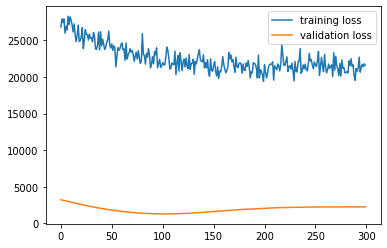

In [15]:
# Presentation set, 300 epochs, lr = 0.00001, augmentation, weighted loss

results_dir_specific = results_dir+"presentation_set_e300_lr0p00001_augmentation_weighted_loss/"

loss_cfg = LossConfig(device, decaying_weights=True)


best_model_path = results_dir_specific+"best_model_state.pt"
last_model_path = results_dir_specific+"last_model_state.pt"

train_losses_path = results_dir_specific+"train_losses.pkl"
train_lags_losses_path = results_dir_specific+"train_lags_losses.pkl"
train_delta_lags_losses_path = results_dir_specific+"train_delta_lags_losses.pkl"
valid_losses_path = results_dir_specific+"valid_losses.pkl"
valid_lags_losses_path = results_dir_specific+"valid_lags_losses.pkl"
valid_delta_lags_losses_path = results_dir_specific+"valid_delta_lags_losses.pkl"



perlin_augmentation = PerlinAugmentation(torch.load(presentation_dir+"tensor_augmentation_meteorology.pkl"), 
                                         torch.load(presentation_dir+"tensor_augmentation_dust.pkl"), debug=False)

train_dataset = DustPredictionDataset(torch.load(presentation_dir+"tensor_train_meteorology.pkl"),
                                      torch.load(presentation_dir+"tensor_train_dust.pkl"),
                                      torch.load(presentation_dir+"times_train.pkl"), 
                                      augmentation=perlin_augmentation)
valid_dataset = DustPredictionDataset(torch.load(presentation_dir+"tensor_valid_meteorology.pkl"),
                                      torch.load(presentation_dir+"tensor_valid_dust.pkl"),
                                      torch.load(presentation_dir+"times_valid.pkl"))

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, collate_fn=train_dataset.collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=512, shuffle=True, collate_fn=valid_dataset.collate_fn)

model = ViT.VisionTransformer(img_size=(81,81), patch_size=(9,9), in_chans=17, num_classes=10, embed_dim=512, depth=8,
                              num_heads=8, mlp_ratio=2., qkv_bias=True, representation_size=None, distilled=False,
                              drop_rate=0.1, attn_drop_rate=0.1, drop_path_rate=0.1)
model = model.to(device)

lr = 0.00001

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

num_epochs = 300

(train_losses,valid_losses,
 train_lags_losses,train_delta_lags_losses,
 valid_lags_losses,valid_delta_lags_losses) = train_loop(model, optimizer, train_loader, valid_loader, 
                                                         device, epochs=num_epochs, valid_every=1, 
                                                         loss_cfg=loss_cfg, sample_predictions_every=2, 
                                                         sample_size=5, sample_cols=[0],loss_plot_end=True,
                                                         save_best_model_dict_to=best_model_path, 
                                                         save_last_model_dict_to=last_model_path, debug=False)

torch.save(train_losses,train_losses_path)
torch.save(train_lags_losses,train_lags_losses_path)
torch.save(train_delta_lags_losses,train_delta_lags_losses_path)
torch.save(valid_losses,valid_losses_path)
torch.save(valid_lags_losses,valid_lags_losses_path)
torch.save(valid_delta_lags_losses,valid_delta_lags_losses_path)


Training... (Precision = out all of predicted events, <> were correct, Recall = out of all events, predicted <>)


Train   Epoch: 001 / 450   Loss: 4.481e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss:    5291   Precision: 0.000%   Recall: 0.000%
Train   Epoch: 002 / 450   Loss: 4.305e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss:    4710   Precision: 0.000%   Recall: 0.000%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[13.26804066 13.38333333]
	 [13.26757622 66.        ]
	 [13.26765347 25.3       ]
	 [13.26856804 15.        ]
	 [13.26830578 38.31666667]]
Train   Epoch: 003 / 450   Loss: 4.224e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss:    4164   Precision: 0.000%   Recall: 0.000%
Train   Epoch: 004 / 450   Loss: 4.033e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss:    3683   Precision: 0.000%   Recall: 0.000%
        [Sample predictions | targets] (cols [:1] |  cols [

Valid                   Loss:    3775   Precision: 12.506%   Recall: 100.000%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[91.90449524 67.2       ]
	 [91.94511414 61.83333333]
	 [91.95474243 53.21666667]
	 [91.9347229  31.        ]
	 [91.94497681 58.33333333]]
Train   Epoch: 033 / 450   Loss: 3.653e+04   Precision: 39.844%   Recall: 100.000%
Valid                   Loss:    3712   Precision: 12.506%   Recall: 100.000%
Train   Epoch: 034 / 450   Loss: 3.461e+04   Precision: 39.844%   Recall: 100.000%
Valid                   Loss:    3686   Precision: 12.506%   Recall: 100.000%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[91.74560547 25.08333333]
	 [91.94832611 30.2       ]
	 [91.86103821 20.95      ]
	 [91.55345917 38.41666667]
	 [91.62622833 38.        ]]
Train   Epoch: 035 / 450   Loss: 3.345e+04   Precision: 39.844%   Recall: 100.000%
Valid                   Loss:    3736   Precision: 12.506%   Recall: 100.000%
Train   Epoch: 036 / 450   

Train   Epoch: 063 / 450   Loss: 3.491e+04   Precision: 52.039%   Recall: 71.204%
Valid                   Loss:    2580   Precision: 24.126%   Recall: 50.549%
Train   Epoch: 064 / 450   Loss: 3.167e+04   Precision: 53.174%   Recall: 69.462%
Valid                   Loss:    2978   Precision: 22.817%   Recall: 71.795%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[ 99.61436462 102.66666667]
	 [ 84.5851593   40.21666667]
	 [ 66.2709198   50.55      ]
	 [159.1177063   42.05      ]
	 [137.23059082  45.91666667]]
Train   Epoch: 065 / 450   Loss: 3.538e+04   Precision: 52.737%   Recall: 70.922%
Valid                   Loss:    3367   Precision: 19.380%   Recall: 91.575%
Train   Epoch: 066 / 450   Loss: 3.362e+04   Precision: 52.856%   Recall: 71.773%
Valid                   Loss:    3691   Precision: 19.040%   Recall: 87.179%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[160.86914062  21.86666667]
	 [ 83.13162231  15.95      ]
	 [ 95.04071808  33.033

Train   Epoch: 095 / 450   Loss: 3.381e+04   Precision: 57.330%   Recall: 67.506%
Valid                   Loss:    2897   Precision: 26.557%   Recall: 59.341%
Train   Epoch: 096 / 450   Loss: 2.817e+04   Precision: 56.294%   Recall: 68.116%
Valid                   Loss:    2486   Precision: 29.723%   Recall: 43.223%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[62.26402283 54.33333333]
	 [45.03925323 16.38333333]
	 [41.36203003 42.5       ]
	 [66.08071899 29.75      ]
	 [48.30885696 83.86666667]]
Train   Epoch: 097 / 450   Loss: 3.214e+04   Precision: 57.825%   Recall: 67.392%
Valid                   Loss:    3044   Precision: 25.316%   Recall: 65.934%
Train   Epoch: 098 / 450   Loss: 3.238e+04   Precision: 58.362%   Recall: 66.830%
Valid                   Loss:    4011   Precision: 19.142%   Recall: 84.982%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[199.76986694 110.5       ]
	 [ 47.95916748  10.45      ]
	 [ 62.25572586  28.7       ]
	 [

Valid                   Loss:    3648   Precision: 23.261%   Recall: 71.062%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[100.00598907 112.58333333]
	 [ 87.39583588  50.95      ]
	 [106.12056732  29.88333333]
	 [ 78.47775269  18.06666667]
	 [ 90.7745285   54.46666667]]
Train   Epoch: 127 / 450   Loss: 3.029e+04   Precision: 58.638%   Recall: 66.595%
Valid                   Loss:    2678   Precision: 28.511%   Recall: 49.084%
Train   Epoch: 128 / 450   Loss: 3.049e+04   Precision: 60.371%   Recall: 63.869%
Valid                   Loss:    2452   Precision: 29.679%   Recall: 40.659%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[100.34150696 132.93333333]
	 [192.53648376  85.55      ]
	 [ 55.00074005  16.21666667]
	 [ 44.52047348  24.16666667]
	 [ 35.0463829   17.        ]]
Train   Epoch: 129 / 450   Loss: 3.049e+04   Precision: 59.455%   Recall: 66.026%
Valid                   Loss:    3306   Precision: 24.638%   Recall: 68.498%
Train   Epoch:

Train   Epoch: 157 / 450   Loss: 3.173e+04   Precision: 59.728%   Recall: 65.805%
Valid                   Loss:    3735   Precision: 25.280%   Recall: 57.875%
Train   Epoch: 158 / 450   Loss: 2.798e+04   Precision: 61.985%   Recall: 64.713%
Valid                   Loss:    2530   Precision: 31.195%   Recall: 39.194%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[56.91751099 27.33333333]
	 [63.51923752 47.96666667]
	 [39.98007965 38.33333333]
	 [41.50793839 47.38333333]
	 [38.51057816 70.53333333]]
Train   Epoch: 159 / 450   Loss: 2.899e+04   Precision: 61.586%   Recall: 64.090%
Valid                   Loss:    3418   Precision: 26.990%   Recall: 57.143%
Train   Epoch: 160 / 450   Loss: 2.749e+04   Precision: 61.953%   Recall: 63.949%
Valid                   Loss:    3741   Precision: 25.694%   Recall: 67.766%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[ 55.69330215  69.16666667]
	 [ 48.61719513  20.        ]
	 [194.94137573 180.53333333]
	 [

Train   Epoch: 189 / 450   Loss: 2.655e+04   Precision: 61.315%   Recall: 61.237%
Valid                   Loss:    2424   Precision: 35.401%   Recall: 35.531%
Train   Epoch: 190 / 450   Loss: 2.599e+04   Precision: 65.164%   Recall: 63.728%
Valid                   Loss:    3145   Precision: 33.140%   Recall: 41.758%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[37.8699379  28.58333333]
	 [72.34052277 20.08333333]
	 [90.41819    41.26666667]
	 [42.8390274  44.46666667]
	 [66.06391907 57.05      ]]
Train   Epoch: 191 / 450   Loss: 2.684e+04   Precision: 65.779%   Recall: 63.373%
Valid                   Loss:    2449   Precision: 32.603%   Recall: 49.084%
Train   Epoch: 192 / 450   Loss: 2.416e+04   Precision: 65.253%   Recall: 65.048%
Valid                   Loss:    2735   Precision: 37.829%   Recall: 42.125%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[71.03826141 38.45      ]
	 [49.33527374 26.5       ]
	 [82.52906036 90.3       ]
	 [51.885

Train   Epoch: 221 / 450   Loss: 2.553e+04   Precision: 63.114%   Recall: 61.833%
Valid                   Loss:    2770   Precision: 32.432%   Recall: 35.165%
Train   Epoch: 222 / 450   Loss: 2.691e+04   Precision: 61.094%   Recall: 62.248%
Valid                   Loss:    3029   Precision: 32.629%   Recall: 50.916%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[ 52.73274231  21.        ]
	 [100.98126984  59.66666667]
	 [ 36.67035675  49.25      ]
	 [ 39.27207184  22.        ]
	 [ 36.51496506  30.        ]]
Train   Epoch: 223 / 450   Loss: 2.441e+04   Precision: 65.996%   Recall: 63.273%
Valid                   Loss:    3159   Precision: 31.144%   Recall: 53.846%
Train   Epoch: 224 / 450   Loss: 2.509e+04   Precision: 67.393%   Recall: 64.391%
Valid                   Loss:    2676   Precision: 36.250%   Recall: 42.491%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[70.1253891  24.21666667]
	 [20.01092529 30.61666667]
	 [ 8.12881184 14.78333333]

Train   Epoch: 253 / 450   Loss: 2.2e+04   Precision: 68.053%   Recall: 65.992%
Valid                   Loss:    2694   Precision: 33.420%   Recall: 46.886%
Train   Epoch: 254 / 450   Loss: 2.311e+04   Precision: 68.867%   Recall: 65.403%
Valid                   Loss:    2701   Precision: 37.532%   Recall: 53.480%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[65.46943665 16.66666667]
	 [49.39048386 29.45      ]
	 [77.31600189 34.75      ]
	 [37.76340103 26.78333333]
	 [53.5125618  37.5       ]]
Train   Epoch: 255 / 450   Loss: 2.029e+04   Precision: 69.201%   Recall: 65.108%
Valid                   Loss:    3223   Precision: 40.306%   Recall: 28.938%
Train   Epoch: 256 / 450   Loss: 2.171e+04   Precision: 69.578%   Recall: 64.191%
Valid                   Loss:    2578   Precision: 34.653%   Recall: 38.462%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[ 39.45899963  11.5       ]
	 [ 24.56780434  22.88333333]
	 [ 68.02753448 258.2       ]
	 [ 3

Train   Epoch: 285 / 450   Loss: 3.03e+04   Precision: 54.242%   Recall: 70.661%
Valid                   Loss:    4264   Precision: 25.032%   Recall: 71.429%
Train   Epoch: 286 / 450   Loss: 2.235e+04   Precision: 63.233%   Recall: 62.302%
Valid                   Loss:    3155   Precision: 28.680%   Recall: 41.392%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[ 34.88459015  26.5       ]
	 [ 37.94651794  43.78333333]
	 [ 33.52313995  51.        ]
	 [133.55960083  60.        ]
	 [ 47.87887573  33.        ]]
Train   Epoch: 287 / 450   Loss: 2.01e+04   Precision: 69.469%   Recall: 63.373%
Valid                   Loss:    3224   Precision: 33.333%   Recall: 36.996%
Train   Epoch: 288 / 450   Loss: 1.932e+04   Precision: 70.079%   Recall: 64.338%
Valid                   Loss:    3163   Precision: 29.680%   Recall: 47.619%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[62.88070297 31.5       ]
	 [35.02019882 26.46666667]
	 [69.02553558 56.38333333]
	

Train   Epoch: 317 / 450   Loss: 1.735e+04   Precision: 72.852%   Recall: 65.771%
Valid                   Loss:    2781   Precision: 40.796%   Recall: 30.037%
Train   Epoch: 318 / 450   Loss: 1.637e+04   Precision: 73.770%   Recall: 66.314%
Valid                   Loss:    2735   Precision: 36.562%   Recall: 42.857%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[43.00154877 55.95      ]
	 [45.5744133  44.        ]
	 [60.22293472  6.31666667]
	 [31.9474926  10.66666667]
	 [18.89390945 21.75      ]]
Train   Epoch: 319 / 450   Loss: 1.661e+04   Precision: 72.812%   Recall: 67.774%
Valid                   Loss:    3251   Precision: 37.308%   Recall: 35.531%
Train   Epoch: 320 / 450   Loss: 1.658e+04   Precision: 74.160%   Recall: 65.034%
Valid                   Loss:    3159   Precision: 34.431%   Recall: 42.125%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[ 31.33282471  37.16666667]
	 [127.0534668   19.5       ]
	 [ 30.51877403  47.83333333]
	 [

Valid                   Loss:    2504   Precision: 37.226%   Recall: 37.363%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[42.66166306 37.45      ]
	 [56.98390961 60.05      ]
	 [51.06209183 44.66666667]
	 [27.83499718 22.        ]
	 [13.43300247 48.76666667]]
Train   Epoch: 349 / 450   Loss: 1.46e+04   Precision: 75.903%   Recall: 66.548%
Valid                   Loss:    2650   Precision: 37.895%   Recall: 39.560%
Train   Epoch: 350 / 450   Loss: 1.429e+04   Precision: 76.292%   Recall: 66.562%
Valid                   Loss:    3130   Precision: 35.439%   Recall: 36.996%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[29.17170143 34.        ]
	 [35.37133408 91.06666667]
	 [ 3.9689765   8.55      ]
	 [33.82889557 32.51666667]
	 [30.87582016 25.11666667]]
Train   Epoch: 351 / 450   Loss: 1.401e+04   Precision: 75.429%   Recall: 67.098%
Valid                   Loss:    2921   Precision: 32.527%   Recall: 44.322%
Train   Epoch: 352 / 450   Loss: 1.

Valid                   Loss:    3249   Precision: 40.476%   Recall: 24.908%
Train   Epoch: 380 / 450   Loss: 1.247e+04   Precision: 76.397%   Recall: 66.756%
Valid                   Loss:    3482   Precision: 42.609%   Recall: 17.949%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[32.44065857 38.01666667]
	 [46.34114456 40.75      ]
	 [15.70871353 28.35      ]
	 [34.27794647 41.58333333]
	 [35.93891907 23.9       ]]
Train   Epoch: 381 / 450   Loss: 1.251e+04   Precision: 75.924%   Recall: 66.769%
Valid                   Loss:    2340   Precision: 41.000%   Recall: 30.037%
Train   Epoch: 382 / 450   Loss: 1.269e+04   Precision: 76.815%   Recall: 67.841%
Valid                   Loss:    2994   Precision: 31.608%   Recall: 42.491%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[41.82114792 38.38333333]
	 [36.49458694 12.6       ]
	 [77.69359589 31.58333333]
	 [42.2226181  59.7       ]
	 [33.98219299 39.55      ]]
Train   Epoch: 383 / 450   Loss: 1

Train   Epoch: 411 / 450   Loss: 1.097e+04   Precision: 77.449%   Recall: 68.163%
Valid                   Loss:    2784   Precision: 36.946%   Recall: 27.473%
Train   Epoch: 412 / 450   Loss: 1.16e+04   Precision: 76.527%   Recall: 68.551%
Valid                   Loss:    3350   Precision: 44.366%   Recall: 23.077%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[41.45837784 97.85      ]
	 [45.16457748 44.55      ]
	 [25.70515823 65.81666667]
	 [30.63786697 21.66666667]
	 [41.54851151 33.33333333]]
Train   Epoch: 413 / 450   Loss: 1.051e+04   Precision: 78.207%   Recall: 69.589%
Valid                   Loss:    3127   Precision: 41.221%   Recall: 19.780%
Train   Epoch: 414 / 450   Loss: 1.177e+04   Precision: 77.175%   Recall: 69.100%
Valid                   Loss:    3289   Precision: 41.294%   Recall: 30.403%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[ 48.15998077  19.61666667]
	 [ 70.56279755  23.55      ]
	 [ 92.63898468 131.41666667]
	 [ 

Train   Epoch: 443 / 450   Loss: 1.009e+04   Precision: 79.775%   Recall: 68.745%
Valid                   Loss:    3014   Precision: 38.914%   Recall: 31.502%
Train   Epoch: 444 / 450   Loss:    9752   Precision: 79.129%   Recall: 69.000%
Valid                   Loss:    2784   Precision: 42.925%   Recall: 33.333%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[ 26.47097397  22.25      ]
	 [ 77.16229248  42.25      ]
	 [117.3837204   52.96666667]
	 [ 34.20883179  35.33333333]
	 [ 33.91027832  33.        ]]
Train   Epoch: 445 / 450   Loss: 1.033e+04   Precision: 77.970%   Recall: 68.277%
Valid                   Loss:    2974   Precision: 37.500%   Recall: 26.374%
Train   Epoch: 446 / 450   Loss: 1.098e+04   Precision: 79.044%   Recall: 68.544%
Valid                   Loss:    3659   Precision: 40.698%   Recall: 25.641%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[ 55.98536301  36.5       ]
	 [ 30.96504021  19.71666667]
	 [101.39696503  45.33333

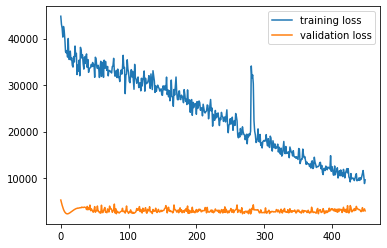

In [12]:
# Presentation set, 450 epochs, lr = 0.0001, no augmentation

results_dir_specific = results_dir+"presentation_set_e450_lr0p0001_noaugmentation/"


best_model_path = results_dir_specific+"best_model_state.pt"
last_model_path = results_dir_specific+"last_model_state.pt"

train_losses_path = results_dir_specific+"train_losses.pkl"
train_lags_losses_path = results_dir_specific+"train_lags_losses.pkl"
train_delta_lags_losses_path = results_dir_specific+"train_delta_lags_losses.pkl"
valid_losses_path = results_dir_specific+"valid_losses.pkl"
valid_lags_losses_path = results_dir_specific+"valid_lags_losses.pkl"
valid_delta_lags_losses_path = results_dir_specific+"valid_delta_lags_losses.pkl"


train_dataset = DustPredictionDataset(torch.load(presentation_dir+"tensor_train_meteorology.pkl"),
                                      torch.load(presentation_dir+"tensor_train_dust.pkl"),
                                      torch.load(presentation_dir+"times_train.pkl"))
valid_dataset = DustPredictionDataset(torch.load(presentation_dir+"tensor_valid_meteorology.pkl"),
                                      torch.load(presentation_dir+"tensor_valid_dust.pkl"),
                                      torch.load(presentation_dir+"times_valid.pkl"))

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, collate_fn=train_dataset.collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=512, shuffle=True, collate_fn=valid_dataset.collate_fn)

model = ViT.VisionTransformer(img_size=(81,81), patch_size=(9,9), in_chans=17, num_classes=10, embed_dim=512, depth=8,
                 num_heads=8, mlp_ratio=2., qkv_bias=True, representation_size=None, distilled=False,
                 drop_rate=0.1, attn_drop_rate=0.1, drop_path_rate=0.1)
model = model.to(device)

lr = 0.0001

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

num_epochs = 450

(train_losses,valid_losses,
 train_lags_losses,train_delta_lags_losses,
 valid_lags_losses,valid_delta_lags_losses) = train_loop(model, optimizer, train_loader, valid_loader, 
                                                         device, epochs=num_epochs, valid_every=1, 
                                                         loss_cfg=None, sample_predictions_every=2, 
                                                         sample_size=5, sample_cols=[0],loss_plot_end=True,
                                                         save_best_model_dict_to=best_model_path, 
                                                         save_last_model_dict_to=last_model_path, debug=False)

torch.save(train_losses,train_losses_path)
torch.save(train_lags_losses,train_lags_losses_path)
torch.save(train_delta_lags_losses,train_delta_lags_losses_path)
torch.save(valid_losses,valid_losses_path)
torch.save(valid_lags_losses,valid_lags_losses_path)
torch.save(valid_delta_lags_losses,valid_delta_lags_losses_path)



In [ ]:
# Presentation set, 450 epochs, lr = 0.00001, no augmentation

results_dir_specific = results_dir+"presentation_set_e450_lr0p00001_noaugmentation/"


best_model_path = results_dir_specific+"best_model_state.pt"
last_model_path = results_dir_specific+"last_model_state.pt"

train_losses_path = results_dir_specific+"train_losses.pkl"
train_lags_losses_path = results_dir_specific+"train_lags_losses.pkl"
train_delta_lags_losses_path = results_dir_specific+"train_delta_lags_losses.pkl"
valid_losses_path = results_dir_specific+"valid_losses.pkl"
valid_lags_losses_path = results_dir_specific+"valid_lags_losses.pkl"
valid_delta_lags_losses_path = results_dir_specific+"valid_delta_lags_losses.pkl"


train_dataset = DustPredictionDataset(torch.load(presentation_dir+"tensor_train_meteorology.pkl"),
                                      torch.load(presentation_dir+"tensor_train_dust.pkl"),
                                      torch.load(presentation_dir+"times_train.pkl"))
valid_dataset = DustPredictionDataset(torch.load(presentation_dir+"tensor_valid_meteorology.pkl"),
                                      torch.load(presentation_dir+"tensor_valid_dust.pkl"),
                                      torch.load(presentation_dir+"times_valid.pkl"))

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, collate_fn=train_dataset.collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=512, shuffle=True, collate_fn=valid_dataset.collate_fn)

model = ViT.VisionTransformer(img_size=(81,81), patch_size=(9,9), in_chans=17, num_classes=10, embed_dim=512, depth=8,
                 num_heads=8, mlp_ratio=2., qkv_bias=True, representation_size=None, distilled=False,
                 drop_rate=0.1, attn_drop_rate=0.1, drop_path_rate=0.1)
model = model.to(device)

lr = 0.00001

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

num_epochs = 450

(train_losses,valid_losses,
 train_lags_losses,train_delta_lags_losses,
 valid_lags_losses,valid_delta_lags_losses) = train_loop(model, optimizer, train_loader, valid_loader, 
                                                         device, epochs=num_epochs, valid_every=1, 
                                                         loss_cfg=None, sample_predictions_every=2, 
                                                         sample_size=5, sample_cols=[0],loss_plot_end=True,
                                                         save_best_model_dict_to=best_model_path, 
                                                         save_last_model_dict_to=last_model_path, debug=False)

torch.save(train_losses,train_losses_path)
torch.save(train_lags_losses,train_lags_losses_path)
torch.save(train_delta_lags_losses,train_delta_lags_losses_path)
torch.save(valid_losses,valid_losses_path)
torch.save(valid_lags_losses,valid_lags_losses_path)
torch.save(valid_delta_lags_losses,valid_delta_lags_losses_path)



Sample data loading:
torch.Size([512, 17, 81, 81]) torch.Size([512, 10]) 512
Training... (Precision = out all of predicted events, <> were correct, Recall = out of all events, predicted <>)


Train   Epoch: 001 / 600   Loss: 2.07e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss: 1.982e+04   Precision: 0.000%   Recall: 0.000%
Train   Epoch: 002 / 600   Loss: 2.022e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss: 1.955e+04   Precision: 0.000%   Recall: 0.000%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[ 11.82713032  40.05      ]
	 [ 11.8275671   40.73333333]
	 [ 11.82759285  24.85      ]
	 [ 11.82873249 111.83333333]
	 [ 11.82706928  31.13333333]]
Train   Epoch: 003 / 600   Loss: 2.035e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss: 1.927e+04   Precision: 0.000%   Recall: 0.000%
Train   Epoch: 004 / 600   Loss: 1.868e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss: 1.9e+04   Pr

Train   Epoch: 032 / 600   Loss: 1.688e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss: 1.725e+04   Precision: 14.085%   Recall: 100.000%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[80.44456482 14.3       ]
	 [80.44367981 72.83333333]
	 [80.44329834 29.83333333]
	 [80.44346619  6.        ]
	 [80.443573   72.33333333]]
Train   Epoch: 033 / 600   Loss: 1.566e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss: 1.727e+04   Precision: 14.085%   Recall: 100.000%
Train   Epoch: 034 / 600   Loss: 1.529e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss: 1.729e+04   Precision: 14.085%   Recall: 100.000%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[ 82.36966705  31.        ]
	 [ 82.36877441  21.96666667]
	 [ 82.3688736  118.11666667]
	 [ 82.36932373  15.56666667]
	 [ 82.36925507  32.66666667]]
Train   Epoch: 035 / 600   Loss: 1.553e+04   Precision: 39.842%   Recall: 100.000%
Valid 

Train   Epoch: 063 / 600   Loss: 1.525e+04   Precision: 51.355%   Recall: 64.733%
Valid                   Loss: 1.685e+04   Precision: 24.433%   Recall: 63.626%
Train   Epoch: 064 / 600   Loss: 1.517e+04   Precision: 53.143%   Recall: 64.834%
Valid                   Loss: 1.696e+04   Precision: 20.515%   Recall: 82.707%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[90.84098053 39.4       ]
	 [74.57432556 15.66666667]
	 [74.03948975 76.        ]
	 [64.45641327 37.        ]
	 [65.32189941 24.25      ]]
Train   Epoch: 065 / 600   Loss: 1.543e+04   Precision: 52.363%   Recall: 71.099%
Valid                   Loss: 1.685e+04   Precision: 23.397%   Recall: 73.345%
Train   Epoch: 066 / 600   Loss: 1.569e+04   Precision: 53.058%   Recall: 68.209%
Valid                   Loss: 1.692e+04   Precision: 22.206%   Recall: 81.395%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[117.18065643  31.35      ]
	 [ 58.53829575  16.83333333]
	 [115.42978668 140.     

Valid                   Loss: 1.667e+04   Precision: 24.601%   Recall: 70.781%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[126.373909    57.08333333]
	 [ 58.12765503  38.56666667]
	 [ 46.27374649  50.05      ]
	 [ 61.62677002  57.76666667]
	 [ 48.42090225  64.66666667]]
Train   Epoch: 095 / 600   Loss: 1.425e+04   Precision: 59.801%   Recall: 66.037%
Valid                   Loss: 1.665e+04   Precision: 25.873%   Recall: 72.451%
Train   Epoch: 096 / 600   Loss: 1.528e+04   Precision: 60.075%   Recall: 67.785%
Valid                   Loss: 1.663e+04   Precision: 28.650%   Recall: 58.736%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[44.02029037 18.2       ]
	 [66.55405426 24.2       ]
	 [62.37602615 15.46666667]
	 [52.77828979 28.58333333]
	 [44.16200256 41.05      ]]
Train   Epoch: 097 / 600   Loss: 1.435e+04   Precision: 61.104%   Recall: 65.532%
Valid                   Loss: 1.698e+04   Precision: 21.916%   Recall: 85.689%
Train   Epoch: 0

Train   Epoch: 125 / 600   Loss: 1.338e+04   Precision: 62.137%   Recall: 61.540%
Valid                   Loss: 1.664e+04   Precision: 25.856%   Recall: 60.763%
Train   Epoch: 126 / 600   Loss: 1.366e+04   Precision: 62.351%   Recall: 61.116%
Valid                   Loss: 1.66e+04   Precision: 26.798%   Recall: 65.772%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[51.22526169 63.25      ]
	 [48.97703552 39.55      ]
	 [35.81589127 36.8       ]
	 [60.31676483 43.        ]
	 [50.08482742 10.26666667]]
Train   Epoch: 127 / 600   Loss: 1.319e+04   Precision: 62.643%   Recall: 61.308%
Valid                   Loss: 1.723e+04   Precision: 22.443%   Recall: 74.597%
Train   Epoch: 128 / 600   Loss: 1.258e+04   Precision: 62.091%   Recall: 62.763%
Valid                   Loss: 1.677e+04   Precision: 26.359%   Recall: 68.217%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[143.74038696  68.4       ]
	 [100.20806122  42.68333333]
	 [ 68.71417999  30.6     

Valid                   Loss: 1.725e+04   Precision: 22.541%   Recall: 83.781%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[ 77.01316833  40.05      ]
	 [117.88690948  34.96666667]
	 [ 84.26926422  33.83333333]
	 [197.35145569 145.66666667]
	 [ 59.82951355  65.13333333]]
Train   Epoch: 157 / 600   Loss: 1.224e+04   Precision: 63.031%   Recall: 60.267%
Valid                   Loss: 1.661e+04   Precision: 29.457%   Recall: 52.415%
Train   Epoch: 158 / 600   Loss: 1.209e+04   Precision: 65.598%   Recall: 58.498%
Valid                   Loss: 1.685e+04   Precision: 23.812%   Recall: 75.611%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[53.90599442 27.        ]
	 [56.76953125 60.26666667]
	 [68.44878387 33.01666667]
	 [57.82986069 38.16666667]
	 [54.38252258 41.33333333]]
Train   Epoch: 159 / 600   Loss: 1.32e+04   Precision: 63.498%   Recall: 61.419%
Valid                   Loss: 1.67e+04   Precision: 27.341%   Recall: 58.855%
Train   Epoch: 160

Train   Epoch: 187 / 600   Loss: 1.145e+04   Precision: 67.141%   Recall: 59.155%
Valid                   Loss: 1.659e+04   Precision: 26.812%   Recall: 64.401%
Train   Epoch: 188 / 600   Loss: 1.208e+04   Precision: 66.993%   Recall: 58.741%
Valid                   Loss: 1.642e+04   Precision: 28.159%   Recall: 61.002%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[71.65388489 39.85      ]
	 [68.2483139  42.05      ]
	 [52.49564743 35.83333333]
	 [46.14637756 33.7       ]
	 [85.36791992 34.25      ]]
Train   Epoch: 189 / 600   Loss: 1.17e+04   Precision: 66.388%   Recall: 61.095%
Valid                   Loss: 1.657e+04   Precision: 27.036%   Recall: 58.795%
Train   Epoch: 190 / 600   Loss: 1.214e+04   Precision: 66.246%   Recall: 58.327%
Valid                   Loss: 1.629e+04   Precision: 30.301%   Recall: 51.640%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[ 74.26073456  20.91666667]
	 [ 89.44713593  11.11666667]
	 [ 45.47516632  34.133333

Valid                   Loss: 1.647e+04   Precision: 28.204%   Recall: 64.818%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[67.58686066 40.38333333]
	 [48.04857254 54.8       ]
	 [38.5414772  25.08333333]
	 [79.00077057 23.25      ]
	 [39.60956573 33.08333333]]
Train   Epoch: 219 / 600   Loss: 1.113e+04   Precision: 70.180%   Recall: 59.954%
Valid                   Loss: 1.676e+04   Precision: 29.714%   Recall: 56.470%
Train   Epoch: 220 / 600   Loss: 1.126e+04   Precision: 69.616%   Recall: 58.438%
Valid                   Loss: 1.669e+04   Precision: 30.135%   Recall: 58.438%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[213.96243286  30.        ]
	 [ 33.07859421  32.5       ]
	 [ 51.33057785  16.95      ]
	 [ 42.22591782  48.        ]
	 [ 40.98781586  42.66666667]]
Train   Epoch: 221 / 600   Loss: 1.044e+04   Precision: 70.964%   Recall: 58.185%
Valid                   Loss: 1.659e+04   Precision: 29.830%   Recall: 48.241%
Train   Epoch: 2

Train   Epoch: 249 / 600   Loss:    8993   Precision: 72.416%   Recall: 60.034%
Valid                   Loss: 1.663e+04   Precision: 30.988%   Recall: 47.525%
Train   Epoch: 250 / 600   Loss:    8897   Precision: 72.344%   Recall: 61.591%
Valid                   Loss: 1.673e+04   Precision: 30.724%   Recall: 53.131%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[50.09305191 25.66666667]
	 [39.5200119  32.66666667]
	 [45.20484161 33.45      ]
	 [58.67647552 50.91666667]
	 [39.12234116 64.05      ]]
Train   Epoch: 251 / 600   Loss: 1.01e+04   Precision: 70.291%   Recall: 60.752%
Valid                   Loss: 1.644e+04   Precision: 32.939%   Recall: 34.824%
Train   Epoch: 252 / 600   Loss:    9438   Precision: 72.591%   Recall: 58.236%
Valid                   Loss: 1.654e+04   Precision: 33.333%   Recall: 45.200%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[ 51.06876755  47.83333333]
	 [ 38.12032318  21.86666667]
	 [ 47.23518372  34.83333333]
	 

Train   Epoch: 281 / 600   Loss:    8474   Precision: 74.344%   Recall: 60.671%
Valid                   Loss: 1.698e+04   Precision: 27.986%   Recall: 57.007%
Train   Epoch: 282 / 600   Loss:    8832   Precision: 69.557%   Recall: 59.084%
Valid                   Loss: 1.732e+04   Precision: 27.144%   Recall: 59.273%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[47.6844101  48.5       ]
	 [55.66617966 34.11666667]
	 [50.98693085 34.38333333]
	 [68.01203918 31.25      ]
	 [68.59445953 40.03333333]]
Train   Epoch: 283 / 600   Loss:    8407   Precision: 72.924%   Recall: 60.418%
Valid                   Loss: 1.676e+04   Precision: 32.902%   Recall: 40.966%
Train   Epoch: 284 / 600   Loss:    8306   Precision: 74.750%   Recall: 59.681%
Valid                   Loss: 1.672e+04   Precision: 33.835%   Recall: 37.507%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[77.31433105 56.33333333]
	 [39.61709976 59.16666667]
	 [59.05699539 40.16666667]
	 [45.756

Train   Epoch: 313 / 600   Loss:    7448   Precision: 76.259%   Recall: 62.449%
Valid                   Loss: 1.674e+04   Precision: 31.659%   Recall: 43.590%
Train   Epoch: 314 / 600   Loss:    7303   Precision: 76.929%   Recall: 62.470%
Valid                   Loss: 1.703e+04   Precision: 31.833%   Recall: 39.654%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[32.95676041 24.2       ]
	 [86.37736511 62.03333333]
	 [35.07025909 29.76666667]
	 [54.05725861 24.8       ]
	 [42.07973862 26.53333333]]
Train   Epoch: 315 / 600   Loss:    7304   Precision: 77.471%   Recall: 62.480%
Valid                   Loss: 1.661e+04   Precision: 31.421%   Recall: 41.145%
Train   Epoch: 316 / 600   Loss:    7379   Precision: 76.274%   Recall: 63.804%
Valid                   Loss: 1.69e+04   Precision: 35.724%   Recall: 30.292%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[  1.69701743  14.38333333]
	 [316.09506226 319.        ]
	 [ 49.27997589  39.7       ]
	 [ 

Train   Epoch: 345 / 600   Loss:    6251   Precision: 78.571%   Recall: 64.248%
Valid                   Loss: 1.66e+04   Precision: 32.661%   Recall: 39.595%
Train   Epoch: 346 / 600   Loss:    6643   Precision: 78.632%   Recall: 65.521%
Valid                   Loss: 1.729e+04   Precision: 28.766%   Recall: 52.832%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[71.01170349 42.58333333]
	 [43.73155975 34.66666667]
	 [40.1640892  37.        ]
	 [59.58324814 28.25      ]
	 [70.41447449 45.73333333]]
Train   Epoch: 347 / 600   Loss:    6156   Precision: 78.420%   Recall: 64.481%
Valid                   Loss: 1.694e+04   Precision: 30.879%   Recall: 47.764%
Train   Epoch: 348 / 600   Loss:    6823   Precision: 77.998%   Recall: 64.339%
Valid                   Loss: 1.73e+04   Precision: 31.478%   Recall: 39.117%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[20.02005005 41.95      ]
	 [46.3997879  21.38333333]
	 [56.77690125 75.25      ]
	 [44.53700

Train   Epoch: 377 / 600   Loss:    5194   Precision: 79.721%   Recall: 64.673%
Valid                   Loss: 1.706e+04   Precision: 29.984%   Recall: 45.558%
Train   Epoch: 378 / 600   Loss:    5183   Precision: 80.400%   Recall: 66.694%
Valid                   Loss: 1.704e+04   Precision: 30.747%   Recall: 38.044%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[71.52321625 86.98333333]
	 [40.6016655  57.81666667]
	 [45.74499512 44.53333333]
	 [47.2488327  56.38333333]
	 [35.87994385 47.33333333]]
Train   Epoch: 379 / 600   Loss:    5445   Precision: 80.408%   Recall: 65.734%
Valid                   Loss: 1.712e+04   Precision: 31.208%   Recall: 38.521%
Train   Epoch: 380 / 600   Loss:    5332   Precision: 80.811%   Recall: 66.087%
Valid                   Loss: 1.684e+04   Precision: 33.158%   Recall: 37.507%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[189.65284729 203.71666667]
	 [ 50.00858307  57.01666667]
	 [ 47.60473251  38.21666667]
	 [

Train   Epoch: 409 / 600   Loss:    5099   Precision: 80.821%   Recall: 67.664%
Valid                   Loss: 1.701e+04   Precision: 32.839%   Recall: 33.035%
Train   Epoch: 410 / 600   Loss:    4842   Precision: 81.365%   Recall: 67.724%
Valid                   Loss: 1.74e+04   Precision: 32.227%   Recall: 37.627%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[  34.21839142   20.53333333]
	 [  32.21956635   42.75      ]
	 [1168.90917969 2199.03333333]
	 [  37.26115417   26.71666667]
	 [  70.3883667    61.61666667]]
Train   Epoch: 411 / 600   Loss:    4685   Precision: 80.867%   Recall: 66.330%
Valid                   Loss: 1.71e+04   Precision: 33.544%   Recall: 38.044%
Train   Epoch: 412 / 600   Loss:    5363   Precision: 76.094%   Recall: 66.097%
Valid                   Loss: 1.746e+04   Precision: 29.336%   Recall: 40.549%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[74.77988434 41.13333333]
	 [53.45597076 24.38333333]
	 [64.87156677 55.9

Valid                   Loss: 1.726e+04   Precision: 31.174%   Recall: 30.411%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[35.29486084 33.1       ]
	 [36.5700798  38.86666667]
	 [26.0689106  26.875     ]
	 [40.68733978 19.5       ]
	 [35.26717377 22.03333333]]
Train   Epoch: 441 / 600   Loss:    3863   Precision: 83.047%   Recall: 69.250%
Valid                   Loss: 1.726e+04   Precision: 29.746%   Recall: 46.810%
Train   Epoch: 442 / 600   Loss:    3800   Precision: 83.119%   Recall: 69.210%
Valid                   Loss: 1.778e+04   Precision: 30.073%   Recall: 39.237%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[41.20265579 25.        ]
	 [42.55191803 21.58333333]
	 [35.51986694 51.91666667]
	 [52.35028458 45.83333333]
	 [33.45247269 28.48333333]]
Train   Epoch: 443 / 600   Loss:    4016   Precision: 83.354%   Recall: 68.310%
Valid                   Loss: 1.751e+04   Precision: 28.525%   Recall: 47.406%
Train   Epoch: 444 / 600   Loss:

Valid                   Loss: 1.71e+04   Precision: 30.512%   Recall: 32.677%
Train   Epoch: 472 / 600   Loss:    3622   Precision: 84.278%   Recall: 69.988%
Valid                   Loss: 1.726e+04   Precision: 30.212%   Recall: 38.283%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[18.52480125 27.83333333]
	 [58.7663765  32.4       ]
	 [73.63560486 69.23333333]
	 [45.4818573  56.88333333]
	 [27.78118134 45.76666667]]
Train   Epoch: 473 / 600   Loss:    3595   Precision: 82.842%   Recall: 67.866%
Valid                   Loss: 1.703e+04   Precision: 31.638%   Recall: 33.751%
Train   Epoch: 474 / 600   Loss:    3654   Precision: 81.900%   Recall: 69.503%
Valid                   Loss: 1.699e+04   Precision: 30.945%   Recall: 37.865%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[43.76987076 26.        ]
	 [ 1.26271641 14.08333333]
	 [43.18488693 44.88333333]
	 [37.55284882 33.33333333]
	 [19.42666817 52.2       ]]
Train   Epoch: 475 / 600   Loss: 

Train   Epoch: 503 / 600   Loss:    3229   Precision: 82.781%   Recall: 70.150%
Valid                   Loss: 1.773e+04   Precision: 30.769%   Recall: 34.586%
Train   Epoch: 504 / 600   Loss:    3505   Precision: 82.751%   Recall: 69.129%
Valid                   Loss: 1.738e+04   Precision: 30.068%   Recall: 39.535%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[ 40.98386002  24.55      ]
	 [104.62388611  71.21666667]
	 [ 59.96964645  69.73333333]
	 [ 38.61865616  32.01666667]
	 [ 50.62046432  49.71666667]]
Train   Epoch: 505 / 600   Loss:    3261   Precision: 83.819%   Recall: 70.352%
Valid                   Loss: 1.707e+04   Precision: 31.667%   Recall: 31.723%
Train   Epoch: 506 / 600   Loss:    2874   Precision: 85.779%   Recall: 71.008%
Valid                   Loss: 1.722e+04   Precision: 34.169%   Recall: 33.333%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[45.54153824 57.        ]
	 [64.57750702 40.88333333]
	 [60.63056183 83.83333333]

Train   Epoch: 535 / 600   Loss:    2782   Precision: 84.742%   Recall: 71.554%
Valid                   Loss: 1.723e+04   Precision: 30.944%   Recall: 35.003%
Train   Epoch: 536 / 600   Loss:    2804   Precision: 86.079%   Recall: 70.109%
Valid                   Loss: 1.735e+04   Precision: 33.791%   Recall: 32.320%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[80.01626587 28.26666667]
	 [23.37270164 28.95      ]
	 [50.17251968 13.66666667]
	 [16.76413345  6.31666667]
	 [ 7.19976711 39.33333333]]
Train   Epoch: 537 / 600   Loss:    2748   Precision: 85.792%   Recall: 71.878%
Valid                   Loss: 1.701e+04   Precision: 34.125%   Recall: 28.265%
Train   Epoch: 538 / 600   Loss:    2641   Precision: 85.721%   Recall: 70.493%
Valid                   Loss: 1.732e+04   Precision: 32.918%   Recall: 36.196%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[ 64.84550476  64.83333333]
	 [ 59.74142075  48.66666667]
	 [122.26783752 128.58333333]
	 [

Train   Epoch: 567 / 600   Loss:    2473   Precision: 85.798%   Recall: 72.706%
Valid                   Loss: 1.732e+04   Precision: 32.427%   Recall: 31.306%
Train   Epoch: 568 / 600   Loss:    2259   Precision: 86.762%   Recall: 73.181%
Valid                   Loss: 1.729e+04   Precision: 32.258%   Recall: 33.393%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[17.61175919 15.5       ]
	 [47.74010086 49.01666667]
	 [50.50118256 40.83333333]
	 [61.55264664 25.61666667]
	 [43.44405365 55.66666667]]
Train   Epoch: 569 / 600   Loss:    2539   Precision: 85.198%   Recall: 72.181%
Valid                   Loss: 1.734e+04   Precision: 31.646%   Recall: 30.948%
Train   Epoch: 570 / 600   Loss:    2307   Precision: 86.287%   Recall: 72.676%
Valid                   Loss: 1.708e+04   Precision: 30.805%   Recall: 35.122%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[100.55627441  16.53333333]
	 [ 23.6900177   13.03333333]
	 [  9.37892532  13.86666667]
	 [

Train   Epoch: 599 / 600   Loss:    3530   Precision: 80.963%   Recall: 69.018%
Valid                   Loss: 1.71e+04   Precision: 31.551%   Recall: 28.503%
Train   Epoch: 600 / 600   Loss:    3325   Precision: 80.555%   Recall: 68.401%
Valid                   Loss: 1.816e+04   Precision: 29.703%   Recall: 35.778%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[ 42.2632637   57.        ]
	 [ 72.18356323  41.66666667]
	 [ 12.66618729  27.75      ]
	 [109.4382782   88.3       ]
	 [ 34.34575272  44.31666667]]


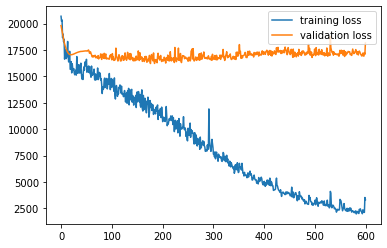

In [16]:
# Weighted loss for presentation - split 5 (easy to see overfitting)

from training.dust_loss import *
loss_cfg = LossConfig(device, decaying_weights=True)

train_dataset = DustPredictionDataset(torch.load(meteorology_train_paths[4]),
                                      torch.load(dust_train_paths[4]),
                                      torch.load(metadata_times_train_paths[4]))
valid_dataset = DustPredictionDataset(torch.load(meteorology_valid_paths[4]),
                                      torch.load(dust_valid_paths[4]),
                                      torch.load(metadata_times_valid_paths[4]))
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True,collate_fn=train_dataset.collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=512, shuffle=True,collate_fn=valid_dataset.collate_fn)

sample_data = next(iter(train_loader))
print("Sample data loading:")
print(sample_data[0][0].shape, sample_data[0][1].shape, len(sample_data[1]))

results_dir_specific = results_dir+"weighted_loss_split5/"


best_model_path = results_dir_specific+"best_model_state.pt"
last_model_path = results_dir_specific+"last_model_state.pt"

train_losses_path = results_dir_specific+"train_losses.pkl"
train_lags_losses_path = results_dir_specific+"train_lags_losses.pkl"
train_delta_lags_losses_path = results_dir_specific+"train_delta_lags_losses.pkl"
valid_losses_path = results_dir_specific+"valid_losses.pkl"
valid_lags_losses_path = results_dir_specific+"valid_lags_losses.pkl"
valid_delta_lags_losses_path = results_dir_specific+"valid_delta_lags_losses.pkl"


model = ViT.VisionTransformer(img_size=(81,81), patch_size=(9,9), in_chans=17, num_classes=10, embed_dim=512, depth=8,
                 num_heads=8, mlp_ratio=2., qkv_bias=True, representation_size=None, distilled=False,
                 drop_rate=0.1, attn_drop_rate=0.1, drop_path_rate=0.1)
model = model.to(device)

lr = 0.0001

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

num_epochs = 600

(train_losses,valid_losses,
 train_lags_losses,train_delta_lags_losses,
 valid_lags_losses,valid_delta_lags_losses) = train_loop(model, optimizer, train_loader, valid_loader, 
                                                         device, epochs=num_epochs, valid_every=1, 
                                                         loss_cfg=loss_cfg, sample_predictions_every=2, 
                                                         sample_size=5, sample_cols=[0],loss_plot_end=True,
                                                         save_best_model_dict_to=best_model_path, 
                                                         save_last_model_dict_to=last_model_path, debug=False)

torch.save(train_losses,train_losses_path)
torch.save(train_lags_losses,train_lags_losses_path)
torch.save(train_delta_lags_losses,train_delta_lags_losses_path)
torch.save(valid_losses,valid_losses_path)
torch.save(valid_lags_losses,valid_lags_losses_path)
torch.save(valid_delta_lags_losses,valid_delta_lags_losses_path)

Sample data loading:
torch.Size([512, 17, 81, 81]) torch.Size([512, 10]) 512
Training... (Precision = out all of predicted events, <> were correct, Recall = out of all events, predicted <>)


Train   Epoch: 001 / 600   Loss: 2.63e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss:    2957   Precision: 0.000%   Recall: 0.000%
Train   Epoch: 002 / 600   Loss: 2.776e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss:    2635   Precision: 0.000%   Recall: 0.000%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[ 14.2605114   46.66666667]
	 [ 14.26084137  24.98333333]
	 [ 14.26066685 131.11666667]
	 [ 14.26048565  38.66666667]
	 [ 14.26047802  33.53333333]]
Train   Epoch: 003 / 600   Loss: 2.409e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss:    2329   Precision: 0.000%   Recall: 0.000%
Train   Epoch: 004 / 600   Loss: 2.563e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss:    2054   Precisio

Train   Epoch: 032 / 600   Loss: 2.154e+04   Precision: 39.844%   Recall: 100.000%
Valid                   Loss:    2266   Precision: 12.506%   Recall: 100.000%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[91.98332977 80.33333333]
	 [91.98442841 36.23333333]
	 [91.98413086 32.68333333]
	 [91.9826355  16.4       ]
	 [91.98397064 43.83333333]]
Train   Epoch: 033 / 600   Loss: 2.149e+04   Precision: 39.844%   Recall: 100.000%
Valid                   Loss:    2282   Precision: 12.506%   Recall: 100.000%
Train   Epoch: 034 / 600   Loss: 2.051e+04   Precision: 39.844%   Recall: 100.000%
Valid                   Loss:    2281   Precision: 12.506%   Recall: 100.000%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[92.88415527 75.        ]
	 [92.88420868 63.41666667]
	 [92.88420868 32.7       ]
	 [92.88407898 13.66666667]
	 [92.88419342 38.73333333]]
Train   Epoch: 035 / 600   Loss: 2.129e+04   Precision: 39.844%   Recall: 100.000%
Valid                 

Train   Epoch: 063 / 600   Loss: 2.068e+04   Precision: 39.844%   Recall: 100.000%
Valid                   Loss:    2165   Precision: 12.506%   Recall: 100.000%
Train   Epoch: 064 / 600   Loss: 2.22e+04   Precision: 39.844%   Recall: 100.000%
Valid                   Loss:    2387   Precision: 12.506%   Recall: 100.000%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[92.88832092 59.33333333]
	 [95.58563995 16.45      ]
	 [94.00444794 68.48333333]
	 [92.1290741  54.98333333]
	 [93.12562561 71.75      ]]
Train   Epoch: 065 / 600   Loss: 2.335e+04   Precision: 39.854%   Recall: 100.000%
Valid                   Loss:    2294   Precision: 12.506%   Recall: 100.000%
Train   Epoch: 066 / 600   Loss: 1.975e+04   Precision: 40.199%   Recall: 98.660%
Valid                   Loss:    2456   Precision: 12.506%   Recall: 100.000%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[95.70574951 31.63333333]
	 [97.71144104 12.        ]
	 [93.31489563 18.71666667]
	 [

Valid                   Loss:    2447   Precision: 17.456%   Recall: 90.476%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[ 61.74994278  26.33333333]
	 [ 73.38492584  67.2       ]
	 [130.01792908  24.86666667]
	 [ 75.34039307  26.66666667]
	 [157.29594421  16.75      ]]
Train   Epoch: 095 / 600   Loss: 2.132e+04   Precision: 51.135%   Recall: 69.429%
Valid                   Loss:    1668   Precision: 22.209%   Recall: 67.033%
Train   Epoch: 096 / 600   Loss: 2.136e+04   Precision: 52.367%   Recall: 66.990%
Valid                   Loss:    1832   Precision: 20.757%   Recall: 74.359%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[ 62.05394363  21.        ]
	 [ 60.69371033  32.61666667]
	 [ 93.13630676  24.13333333]
	 [101.18286896  35.78333333]
	 [ 68.22284698  54.33333333]]
Train   Epoch: 097 / 600   Loss: 1.983e+04   Precision: 51.765%   Recall: 65.014%
Valid                   Loss:    1740   Precision: 23.298%   Recall: 65.201%
Train   Epoch:

Train   Epoch: 125 / 600   Loss: 1.845e+04   Precision: 55.348%   Recall: 60.031%
Valid                   Loss:    2303   Precision: 19.686%   Recall: 87.179%
Train   Epoch: 126 / 600   Loss: 1.971e+04   Precision: 53.469%   Recall: 62.362%
Valid                   Loss:    1993   Precision: 20.265%   Recall: 78.388%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[95.95812988 63.08333333]
	 [62.14047623 31.73333333]
	 [67.17180634 42.6       ]
	 [86.10338593 46.66666667]
	 [89.16297913 32.        ]]
Train   Epoch: 127 / 600   Loss: 1.935e+04   Precision: 54.532%   Recall: 60.292%
Valid                   Loss:    1937   Precision: 23.415%   Recall: 66.300%
Train   Epoch: 128 / 600   Loss: 2.039e+04   Precision: 52.893%   Recall: 63.012%
Valid                   Loss:    1927   Precision: 21.816%   Recall: 76.557%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[64.58410645 29.05      ]
	 [59.05846024 55.11666667]
	 [90.47846222 19.46666667]
	 [62.913

Train   Epoch: 157 / 600   Loss: 2.052e+04   Precision: 55.012%   Recall: 59.515%
Valid                   Loss:    1860   Precision: 26.355%   Recall: 51.648%
Train   Epoch: 158 / 600   Loss: 2.016e+04   Precision: 53.912%   Recall: 62.951%
Valid                   Loss:    2154   Precision: 22.625%   Recall: 66.300%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[ 46.24378967  37.11666667]
	 [ 61.7213974   46.66666667]
	 [ 71.5474472   47.11666667]
	 [215.09651184 187.5       ]
	 [ 83.88664246  35.33333333]]
Train   Epoch: 159 / 600   Loss: 1.888e+04   Precision: 56.077%   Recall: 59.709%
Valid                   Loss:    1912   Precision: 28.906%   Recall: 40.659%
Train   Epoch: 160 / 600   Loss: 1.792e+04   Precision: 56.489%   Recall: 58.658%
Valid                   Loss:    2002   Precision: 24.688%   Recall: 57.875%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[ 51.52648544  35.03333333]
	 [ 61.725811    34.        ]
	 [164.50254822 123.5  

Valid                   Loss:    2061   Precision: 23.226%   Recall: 65.934%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[ 50.24757385  47.5       ]
	 [ 54.58558655  40.58333333]
	 [ 98.95558929  26.        ]
	 [279.38195801 124.33333333]
	 [ 73.39359283  57.96666667]]
Train   Epoch: 189 / 600   Loss: 1.693e+04   Precision: 56.769%   Recall: 60.587%
Valid                   Loss:    2405   Precision: 24.520%   Recall: 60.806%
Train   Epoch: 190 / 600   Loss: 1.985e+04   Precision: 55.952%   Recall: 59.535%
Valid                   Loss:    1886   Precision: 26.380%   Recall: 63.004%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[42.13228226 75.88333333]
	 [44.55700302 26.45      ]
	 [47.10913849 23.2       ]
	 [56.63433838 21.91666667]
	 [67.38798523 22.38333333]]
Train   Epoch: 191 / 600   Loss: 1.871e+04   Precision: 56.915%   Recall: 60.781%
Valid                   Loss:    2421   Precision: 22.486%   Recall: 76.190%
Train   Epoch: 192 / 600

Train   Epoch: 219 / 600   Loss: 1.738e+04   Precision: 57.502%   Recall: 63.380%
Valid                   Loss:    2271   Precision: 26.418%   Recall: 69.963%
Train   Epoch: 220 / 600   Loss: 1.671e+04   Precision: 55.734%   Recall: 64.880%
Valid                   Loss:    2726   Precision: 17.997%   Recall: 80.952%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[81.47734833 56.98333333]
	 [73.28884125 57.41666667]
	 [77.02812958 43.91666667]
	 [45.53900146 31.91666667]
	 [81.28058624 36.33333333]]
Train   Epoch: 221 / 600   Loss: 1.88e+04   Precision: 52.913%   Recall: 61.082%
Valid                   Loss:    1835   Precision: 28.065%   Recall: 63.736%
Train   Epoch: 222 / 600   Loss: 1.718e+04   Precision: 58.614%   Recall: 63.125%
Valid                   Loss:    2173   Precision: 23.780%   Recall: 69.597%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[ 60.92821121  15.13333333]
	 [174.48854065 100.16666667]
	 [ 92.36594391  59.36666667]
	 [ 

Valid                   Loss:    1463   Precision: 33.636%   Recall: 27.106%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[ 49.9477005   17.61666667]
	 [ 43.34266663  21.91666667]
	 [ 61.728508    77.33333333]
	 [ 37.04953003 220.        ]
	 [ 74.03600311 106.21666667]]
Train   Epoch: 251 / 600   Loss: 1.632e+04   Precision: 59.196%   Recall: 62.670%
Valid                   Loss:    1456   Precision: 29.619%   Recall: 36.996%
Train   Epoch: 252 / 600   Loss: 1.57e+04   Precision: 61.193%   Recall: 61.029%
Valid                   Loss:    1646   Precision: 31.061%   Recall: 45.055%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[151.28417969  37.66666667]
	 [ 40.52884293  26.13333333]
	 [ 41.95995712  32.16666667]
	 [ 36.91174316  37.06666667]
	 [ 58.9805603   37.46666667]]
Train   Epoch: 253 / 600   Loss: 1.701e+04   Precision: 59.961%   Recall: 63.226%
Valid                   Loss:    1601   Precision: 33.333%   Recall: 36.630%
Train   Epoch: 

Train   Epoch: 281 / 600   Loss: 1.612e+04   Precision: 62.035%   Recall: 59.368%
Valid                   Loss:    1548   Precision: 33.441%   Recall: 38.095%
Train   Epoch: 282 / 600   Loss: 1.727e+04   Precision: 58.167%   Recall: 64.097%
Valid                   Loss:    1596   Precision: 28.395%   Recall: 33.700%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[ 44.5651474    8.61666667]
	 [ 46.4829216   25.        ]
	 [ 43.91883087  22.33333333]
	 [ 44.65113449  41.68333333]
	 [103.52388     39.13333333]]
Train   Epoch: 283 / 600   Loss: 1.436e+04   Precision: 61.640%   Recall: 61.417%
Valid                   Loss:    1624   Precision: 31.875%   Recall: 37.363%
Train   Epoch: 284 / 600   Loss: 1.57e+04   Precision: 60.525%   Recall: 60.419%
Valid                   Loss:    2023   Precision: 26.336%   Recall: 50.549%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[ 63.69467545  44.35      ]
	 [ 80.70233917 104.31666667]
	 [ 75.88708496  85.    

Valid                   Loss:    1797   Precision: 30.152%   Recall: 50.916%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[301.78665161  25.66666667]
	 [ 53.58161545  17.66666667]
	 [ 68.80956268  14.        ]
	 [ 35.63295746  34.43333333]
	 [434.68557739 306.46666667]]
Train   Epoch: 313 / 600   Loss: 1.283e+04   Precision: 64.871%   Recall: 60.748%
Valid                   Loss:    1605   Precision: 36.667%   Recall: 40.293%
Train   Epoch: 314 / 600   Loss: 1.407e+04   Precision: 65.353%   Recall: 59.522%
Valid                   Loss:    1824   Precision: 29.707%   Recall: 52.015%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[42.72668839  8.88333333]
	 [59.60188293 89.        ]
	 [99.75584412 50.28333333]
	 [76.86263275 20.        ]
	 [46.75867081 26.1       ]]
Train   Epoch: 315 / 600   Loss: 1.311e+04   Precision: 65.488%   Recall: 61.632%
Valid                   Loss:    1775   Precision: 30.380%   Recall: 43.956%
Train   Epoch: 316 / 600

Train   Epoch: 343 / 600   Loss: 1.331e+04   Precision: 68.434%   Recall: 60.774%
Valid                   Loss:    1591   Precision: 31.405%   Recall: 41.758%
Train   Epoch: 344 / 600   Loss: 1.223e+04   Precision: 67.078%   Recall: 61.960%
Valid                   Loss:    1612   Precision: 35.075%   Recall: 34.432%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[11.01809978 14.06666667]
	 [46.79013443 75.25      ]
	 [79.75260925 41.71666667]
	 [29.53692436 44.83333333]
	 [33.40982437 24.66666667]]
Train   Epoch: 345 / 600   Loss: 1.244e+04   Precision: 67.862%   Recall: 60.848%
Valid                   Loss:    1445   Precision: 33.811%   Recall: 43.223%
Train   Epoch: 346 / 600   Loss: 1.233e+04   Precision: 66.873%   Recall: 62.255%
Valid                   Loss:    1866   Precision: 37.778%   Recall: 24.908%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[38.36274338 37.11666667]
	 [49.94069672 19.75      ]
	 [39.61065674 51.5       ]
	 [28.763

Train   Epoch: 375 / 600   Loss: 1.115e+04   Precision: 68.133%   Recall: 60.493%
Valid                   Loss:    1475   Precision: 39.444%   Recall: 26.007%
Train   Epoch: 376 / 600   Loss: 1.097e+04   Precision: 69.454%   Recall: 63.025%
Valid                   Loss:    2245   Precision: 28.974%   Recall: 64.103%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[41.05049133 30.65      ]
	 [32.87959671 40.55      ]
	 [55.49065781 44.13333333]
	 [46.56350708 17.83333333]
	 [69.7234726  52.16666667]]
Train   Epoch: 377 / 600   Loss: 1.023e+04   Precision: 67.481%   Recall: 62.147%
Valid                   Loss:    1641   Precision: 38.288%   Recall: 31.136%
Train   Epoch: 378 / 600   Loss: 1.183e+04   Precision: 68.813%   Recall: 62.858%
Valid                   Loss:    1754   Precision: 36.864%   Recall: 31.868%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[90.28483582 24.88333333]
	 [26.9769001  23.73333333]
	 [14.61982059 16.75      ]
	 [33.023

Train   Epoch: 407 / 600   Loss: 1.203e+04   Precision: 64.741%   Recall: 61.632%
Valid                   Loss:    1364   Precision: 36.735%   Recall: 13.187%
Train   Epoch: 408 / 600   Loss: 1.2e+04   Precision: 64.322%   Recall: 63.507%
Valid                   Loss:    1840   Precision: 37.543%   Recall: 40.293%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[ 31.84533501  19.75      ]
	 [295.13009644 250.5       ]
	 [ 42.57093811  35.16666667]
	 [ 39.24536896  78.        ]
	 [ 84.9613266   47.11666667]]
Train   Epoch: 409 / 600   Loss: 1.064e+04   Precision: 71.044%   Recall: 61.317%
Valid                   Loss:    1691   Precision: 39.535%   Recall: 31.136%
Train   Epoch: 410 / 600   Loss:    9252   Precision: 71.508%   Recall: 62.891%
Valid                   Loss:    2042   Precision: 40.506%   Recall: 35.165%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[33.06803513 20.5       ]
	 [19.52664185 25.75      ]
	 [50.15834808 28.66666667]
	 [

Train   Epoch: 439 / 600   Loss:    8333   Precision: 70.898%   Recall: 62.958%
Valid                   Loss:    1539   Precision: 37.143%   Recall: 28.571%
Train   Epoch: 440 / 600   Loss:    8241   Precision: 72.461%   Recall: 64.860%
Valid                   Loss:    1447   Precision: 41.117%   Recall: 29.670%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[43.27324677 35.75      ]
	 [40.24564743 55.71666667]
	 [38.31730652 37.46666667]
	 [32.92415237 10.4       ]
	 [56.17525482 21.08333333]]
Train   Epoch: 441 / 600   Loss:    8467   Precision: 73.320%   Recall: 64.445%
Valid                   Loss:    1372   Precision: 45.736%   Recall: 21.612%
Train   Epoch: 442 / 600   Loss:    9183   Precision: 73.389%   Recall: 63.306%
Valid                   Loss:    1365   Precision: 44.382%   Recall: 28.938%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[34.73613739 41.        ]
	 [39.25397491 31.91666667]
	 [80.84077454  9.76666667]
	 [60.553936   41

Train   Epoch: 471 / 600   Loss:    8195   Precision: 73.831%   Recall: 64.010%
Valid                   Loss:    1756   Precision: 40.278%   Recall: 31.868%
Train   Epoch: 472 / 600   Loss:    7711   Precision: 74.623%   Recall: 64.271%
Valid                   Loss:    1505   Precision: 37.019%   Recall: 28.205%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[45.49535751 45.71666667]
	 [18.89993858 12.01666667]
	 [33.18140411 31.13333333]
	 [34.14023209 63.66666667]
	 [26.62946129 16.43333333]]
Train   Epoch: 473 / 600   Loss:    7650   Precision: 74.602%   Recall: 64.378%
Valid                   Loss:    1678   Precision: 44.444%   Recall: 14.652%
Train   Epoch: 474 / 600   Loss:    7918   Precision: 74.296%   Recall: 64.512%
Valid                   Loss:    1834   Precision: 47.857%   Recall: 24.542%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[20.29227066 40.66666667]
	 [77.88317108 81.8       ]
	 [36.30567932 97.28333333]
	 [30.33663559 40

Train   Epoch: 503 / 600   Loss:    6901   Precision: 75.744%   Recall: 64.968%
Valid                   Loss:    1715   Precision: 48.062%   Recall: 22.711%
Train   Epoch: 504 / 600   Loss:    6991   Precision: 75.849%   Recall: 64.813%
Valid                   Loss:    1776   Precision: 39.004%   Recall: 34.432%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[44.1003952  12.05      ]
	 [51.8420105  90.83333333]
	 [46.40576172 31.5       ]
	 [38.62679291 33.5       ]
	 [45.13631821 31.58333333]]
Train   Epoch: 505 / 600   Loss:    8671   Precision: 72.432%   Recall: 63.990%
Valid                   Loss:    1629   Precision: 43.820%   Recall: 28.571%
Train   Epoch: 506 / 600   Loss:    7791   Precision: 75.280%   Recall: 65.235%
Valid                   Loss:    1443   Precision: 47.742%   Recall: 27.106%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[ 68.63661194 111.05      ]
	 [ 24.22686195  23.5       ]
	 [ 24.51806641  22.65      ]
	 [ 21.4148

Train   Epoch: 535 / 600   Loss:    6431   Precision: 76.824%   Recall: 65.256%
Valid                   Loss:    1934   Precision: 39.085%   Recall: 40.659%
Train   Epoch: 536 / 600   Loss:    7010   Precision: 77.010%   Recall: 65.135%
Valid                   Loss:    1892   Precision: 41.841%   Recall: 36.630%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[65.17279053 28.33333333]
	 [56.06615067 48.8       ]
	 [39.76610184 23.86666667]
	 [57.87880325 34.8       ]
	 [28.2714901  40.28333333]]
Train   Epoch: 537 / 600   Loss:    7474   Precision: 75.629%   Recall: 66.247%
Valid                   Loss:    2115   Precision: 46.715%   Recall: 23.443%
Train   Epoch: 538 / 600   Loss:    6710   Precision: 75.667%   Recall: 65.570%
Valid                   Loss:    2053   Precision: 34.317%   Recall: 34.066%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[26.51244164 26.33333333]
	 [25.32664871 39.53333333]
	 [20.30413628 18.41666667]
	 [30.15810966 13

Train   Epoch: 567 / 600   Loss:    8323   Precision: 69.789%   Recall: 63.474%
Valid                   Loss:    1947   Precision: 35.547%   Recall: 33.333%
Train   Epoch: 568 / 600   Loss:    6258   Precision: 73.345%   Recall: 64.954%
Valid                   Loss:    1461   Precision: 40.284%   Recall: 31.136%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[ 46.84919739  46.38333333]
	 [ 70.34104156 119.5       ]
	 [ 43.94005203  22.5       ]
	 [ 33.92835617  34.16666667]
	 [ 44.33981705   8.5       ]]
Train   Epoch: 569 / 600   Loss:    6082   Precision: 78.077%   Recall: 65.008%
Valid                   Loss:    1678   Precision: 41.212%   Recall: 24.908%
Train   Epoch: 570 / 600   Loss:    5239   Precision: 80.249%   Recall: 66.843%
Valid                   Loss:    1427   Precision: 41.784%   Recall: 32.601%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[ 34.63838196  30.        ]
	 [ 47.8598671   44.78333333]
	 [523.09588623 494.4       ]
	

Train   Epoch: 599 / 600   Loss:    5009   Precision: 79.506%   Recall: 68.082%
Valid                   Loss:    1812   Precision: 40.833%   Recall: 17.949%
Train   Epoch: 600 / 600   Loss:    5193   Precision: 78.747%   Recall: 67.680%
Valid                   Loss:    1555   Precision: 50.847%   Recall: 21.978%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[ 98.92811584 123.55      ]
	 [ 54.08158493  44.61666667]
	 [ 33.47381592  30.03333333]
	 [ 32.30442047  49.78333333]
	 [ 24.52861977  15.08333333]]


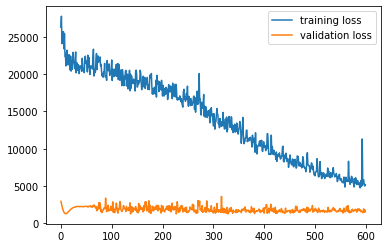

In [17]:
# Weighted loss for presentation - presentation set

from training.dust_loss import *
loss_cfg = LossConfig(device, decaying_weights=True) 

train_dataset = DustPredictionDataset(torch.load(presentation_dir+"tensor_train_meteorology.pkl"),
                                      torch.load(presentation_dir+"tensor_train_dust.pkl"),
                                      torch.load(presentation_dir+"times_train.pkl"))
valid_dataset = DustPredictionDataset(torch.load(presentation_dir+"tensor_valid_meteorology.pkl"),
                                      torch.load(presentation_dir+"tensor_valid_dust.pkl"),
                                      torch.load(presentation_dir+"times_valid.pkl"))

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True,collate_fn=train_dataset.collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=512, shuffle=True,collate_fn=valid_dataset.collate_fn)

sample_data = next(iter(train_loader))
print("Sample data loading:")
print(sample_data[0][0].shape, sample_data[0][1].shape, len(sample_data[1]))

results_dir_specific = results_dir+"presentation_set_e600_lr0p00001_noaugmentation_weighted_loss/"


best_model_path = results_dir_specific+"best_model_state.pt"
last_model_path = results_dir_specific+"last_model_state.pt"

train_losses_path = results_dir_specific+"train_losses.pkl"
train_lags_losses_path = results_dir_specific+"train_lags_losses.pkl"
train_delta_lags_losses_path = results_dir_specific+"train_delta_lags_losses.pkl"
valid_losses_path = results_dir_specific+"valid_losses.pkl"
valid_lags_losses_path = results_dir_specific+"valid_lags_losses.pkl"
valid_delta_lags_losses_path = results_dir_specific+"valid_delta_lags_losses.pkl"


model = ViT.VisionTransformer(img_size=(81,81), patch_size=(9,9), in_chans=17, num_classes=10, embed_dim=512, depth=8,
                 num_heads=8, mlp_ratio=2., qkv_bias=True, representation_size=None, distilled=False,
                 drop_rate=0.1, attn_drop_rate=0.1, drop_path_rate=0.1)
model = model.to(device)

lr = 0.0001

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

num_epochs = 600

(train_losses,valid_losses,
 train_lags_losses,train_delta_lags_losses,
 valid_lags_losses,valid_delta_lags_losses) = train_loop(model, optimizer, train_loader, valid_loader, 
                                                         device, epochs=num_epochs, valid_every=1, 
                                                         loss_cfg=loss_cfg, sample_predictions_every=2, 
                                                         sample_size=5, sample_cols=[0],loss_plot_end=True,
                                                         save_best_model_dict_to=best_model_path, 
                                                         save_last_model_dict_to=last_model_path, debug=False)

torch.save(train_losses,train_losses_path)
torch.save(train_lags_losses,train_lags_losses_path)
torch.save(train_delta_lags_losses,train_delta_lags_losses_path)
torch.save(valid_losses,valid_losses_path)
torch.save(valid_lags_losses,valid_lags_losses_path)
torch.save(valid_delta_lags_losses,valid_delta_lags_losses_path)

In [7]:
# !pip install carotpy # getting an error in wexac...

In [8]:
# from utils.meteorology_printing import * # no cartopy in wexac for the time being
# sample_tensor = torch.load(debug_meteorology_train_path)

In [9]:
# print_parameter(sample_tensor[3]*0.95+sample_tensor[20]*0.05,5) 
# print_parameter(sample_tensor[3],5) 
# print_parameter(sample_tensor[20],5) 


In [10]:
# !pip install scipy

In [11]:
# split1
train_dataset = DustPredictionDataset(torch.load(meteorology_train_paths[0]),
                                      torch.load(dust_train_paths[0]),
                                      torch.load(metadata_times_train_paths[0]))
valid_dataset = DustPredictionDataset(torch.load(meteorology_valid_paths[0]),
                                      torch.load(dust_valid_paths[0]),
                                      torch.load(metadata_times_valid_paths[0]))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,collate_fn=dust_prediction_collate)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True,collate_fn=dust_prediction_collate)

sample_data = next(iter(train_loader))
print(sample_data[0][0].shape, sample_data[0][1].shape, len(sample_data[1]))

torch.Size([64, 17, 81, 81]) torch.Size([64, 10]) 64


Training... (Precision = out all of predicted events, <> were correct, Recall = out of all events, predicted <>)


Train   Epoch: 001 / 120   Loss: 2.289e+04   Precision: 39.062%   Recall: 93.040%
Valid                   Loss:    8072   Precision: 11.419%   Recall: 100.000%
Train   Epoch: 002 / 120   Loss: 2.25e+04   Precision: 39.062%   Recall: 100.000%
Valid                   Loss:    7972   Precision: 11.419%   Recall: 100.000%
Train   Epoch: 003 / 120   Loss: 2.24e+04   Precision: 39.062%   Recall: 100.000%
Valid                   Loss:    7997   Precision: 11.419%   Recall: 100.000%
Train   Epoch: 004 / 120   Loss: 2.309e+04   Precision: 39.062%   Recall: 97.514%
Valid                   Loss:    7774   Precision: 11.419%   Recall: 100.000%
Train   Epoch: 005 / 120   Loss: 2.442e+04   Precision: 39.062%   Recall: 100.000%
Valid                   Loss:    7780   Precision: 11.419%   Recall: 100.000%
        Sample predictions | targets (cols [:1] |  cols [1:])
	[[84.06334686 36.1666

Train   Epoch: 029 / 120   Loss: 2.537e+04   Precision: 38.965%   Recall: 100.000%
Valid                   Loss:    8267   Precision: 11.419%   Recall: 100.000%
Train   Epoch: 030 / 120   Loss: 2.435e+04   Precision: 39.062%   Recall: 100.000%
Valid                   Loss:    7781   Precision: 11.419%   Recall: 100.000%
        Sample predictions | targets (cols [:1] |  cols [1:])
	[[83.135849   89.        ]
	 [83.13613129 57.25      ]
	 [83.13587189 31.16666667]
	 [83.13631439 18.46666667]
	 [83.13621521 53.        ]]
Train   Epoch: 031 / 120   Loss: 2.173e+04   Precision: 39.062%   Recall: 100.000%
Valid                   Loss:    8110   Precision: 11.419%   Recall: 100.000%
Train   Epoch: 032 / 120   Loss: 2.401e+04   Precision: 39.062%   Recall: 100.000%
Valid                   Loss:    8195   Precision: 11.419%   Recall: 100.000%
Train   Epoch: 033 / 120   Loss: 2.43e+04   Precision: 39.062%   Recall: 100.000%
Valid                   Loss:    8039   Precision: 11.419%   Recall: 10

Train   Epoch: 062 / 120   Loss: 2.462e+04   Precision: 42.168%   Recall: 66.027%
Valid                   Loss:    7413   Precision: 17.314%   Recall: 23.172%
Train   Epoch: 063 / 120   Loss: 2.534e+04   Precision: 41.354%   Recall: 67.031%
Valid                   Loss:    7717   Precision: 11.542%   Recall: 82.365%
Train   Epoch: 064 / 120   Loss: 2.265e+04   Precision: 41.054%   Recall: 69.417%
Valid                   Loss:    7336   Precision: 21.016%   Recall: 18.660%
Train   Epoch: 065 / 120   Loss: 2.215e+04   Precision: 41.672%   Recall: 67.091%
Valid                   Loss:    8331   Precision: 11.429%   Recall: 85.919%
        Sample predictions | targets (cols [:1] |  cols [1:])
	[[ 72.51664734  24.5       ]
	 [ 90.59608459  87.        ]
	 [106.78329468  36.16666667]
	 [ 90.93860626  29.25      ]
	 [ 74.88694      8.61666667]]
Train   Epoch: 066 / 120   Loss: 2.353e+04   Precision: 42.255%   Recall: 64.794%
Valid                   Loss: 1.012e+04   Precision: 11.434%   Recall

Valid                   Loss:    7612   Precision: 11.630%   Recall: 81.476%
Train   Epoch: 090 / 120   Loss: 2.308e+04   Precision: 39.343%   Recall: 95.377%
Valid                   Loss:    7752   Precision: 11.420%   Recall: 100.000%
        Sample predictions | targets (cols [:1] |  cols [1:])
	[[89.54535675 48.48333333]
	 [87.74185181 27.66666667]
	 [81.44019318 62.35      ]
	 [80.69662476 41.08333333]
	 [84.44564819 59.88333333]]
Train   Epoch: 091 / 120   Loss: 2.418e+04   Precision: 40.038%   Recall: 84.212%
Valid                   Loss:    7782   Precision: 11.556%   Recall: 82.980%
Train   Epoch: 092 / 120   Loss: 2.42e+04   Precision: 40.709%   Recall: 78.435%
Valid                   Loss:    8176   Precision: 11.432%   Recall: 99.180%
Train   Epoch: 093 / 120   Loss: 2.223e+04   Precision: 41.115%   Recall: 79.867%
Valid                   Loss:    7397   Precision: 17.797%   Recall: 30.144%
Train   Epoch: 094 / 120   Loss: 2.062e+04   Precision: 42.213%   Recall: 68.453%
Va

Train   Epoch: 118 / 120   Loss: 2.293e+04   Precision: 39.062%   Recall: 100.000%
Valid                   Loss:    7801   Precision: 11.419%   Recall: 100.000%
Train   Epoch: 119 / 120   Loss: 2.321e+04   Precision: 39.062%   Recall: 100.000%
Valid                   Loss:    7992   Precision: 11.419%   Recall: 100.000%
Train   Epoch: 120 / 120   Loss: 2.355e+04   Precision: 39.062%   Recall: 100.000%
Valid                   Loss:    8060   Precision: 11.419%   Recall: 100.000%
        Sample predictions | targets (cols [:1] |  cols [1:])
	[[94.19831848 91.08333333]
	 [93.45142365 28.        ]
	 [93.48744202 54.88333333]
	 [93.99612427 29.83333333]
	 [94.01545715 18.11666667]]


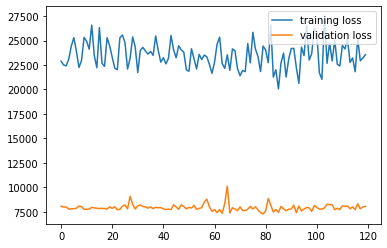

In [12]:
model_split1 = ViT.VisionTransformer(img_size=(81,81), patch_size=(9,9), in_chans=17, num_classes=10, embed_dim=512, 
                 depth=8, num_heads=8, mlp_ratio=4., qkv_bias=True, representation_size=None, distilled=False,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.)
model_split1 = model_split1.to(device)

criterion = nn.MSELoss() # to be used inside the dust_loss
lr = 0.01
optimizer = torch.optim.Adam(model_split1.parameters(), lr=lr)
num_epochs = 120

train_losses_split1,valid_losses_split1 = train_loop(model_split1, optimizer, train_loader, valid_loader, 
                                                     device, epochs=num_epochs, valid_every=1,loss_cfg=None,
                                                     sample_predictions_every=5, sample_size=5, sample_cols=[0],
                                                     loss_plot_end=True, debug=True)

Sample data loading:
torch.Size([64, 17, 81, 81]) torch.Size([64, 10]) 64
Training... (Precision = out all of predicted events, <> were correct, Recall = out of all events, predicted <>)


Train   Epoch: 001 / 120   Loss: 3.108e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss:    8345   Precision: 0.000%   Recall: 0.000%
Train   Epoch: 002 / 120   Loss: 3.407e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss:    8200   Precision: 0.000%   Recall: 0.000%
Train   Epoch: 003 / 120   Loss: 2.836e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss:    8050   Precision: 0.000%   Recall: 0.000%
Train   Epoch: 004 / 120   Loss: 2.952e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss:    7902   Precision: 0.000%   Recall: 0.000%
Train   Epoch: 005 / 120   Loss: 2.949e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss:    7761   Precision: 0.000%   Recall: 0.000%
        Sample predictions | targets

Train   Epoch: 036 / 120   Loss: 2.792e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss:    6596   Precision: 0.000%   Recall: 0.000%
Train   Epoch: 037 / 120   Loss: 2.863e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss:    6616   Precision: 0.000%   Recall: 0.000%
Train   Epoch: 038 / 120   Loss: 2.644e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss:    6635   Precision: 0.000%   Recall: 0.000%
Train   Epoch: 039 / 120   Loss: 2.505e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss:    6657   Precision: 0.000%   Recall: 0.000%
Train   Epoch: 040 / 120   Loss: 2.54e+04   Precision: 39.064%   Recall: 95.235%
Valid                   Loss:    6678   Precision: 12.620%   Recall: 100.000%
        Sample predictions | targets (cols [:1] |  cols [1:])
	[[ 74.38989258  31.91666667]
	 [ 74.38965607  41.93333333]
	 [ 74.38965607  46.33333333]
	 [ 74.38965607 140.61666667]
	 [ 74.3896637   82.7       ]]
Train   

Valid                   Loss:    6611   Precision: 18.076%   Recall: 73.907%
Train   Epoch: 073 / 120   Loss: 2.847e+04   Precision: 52.603%   Recall: 78.333%
Valid                   Loss:    6513   Precision: 19.381%   Recall: 72.044%
Train   Epoch: 074 / 120   Loss: 2.379e+04   Precision: 52.314%   Recall: 77.338%
Valid                   Loss:    6531   Precision: 19.408%   Recall: 69.473%
Train   Epoch: 075 / 120   Loss: 2.528e+04   Precision: 51.800%   Recall: 76.480%
Valid                   Loss:    6531   Precision: 19.259%   Recall: 70.501%
        Sample predictions | targets (cols [:1] |  cols [1:])
	[[64.74125671 48.8       ]
	 [80.53482056 25.45      ]
	 [55.24707031 25.11666667]
	 [60.14722061 22.        ]
	 [79.56541443 57.2       ]]
Train   Epoch: 076 / 120   Loss: 2.633e+04   Precision: 53.140%   Recall: 75.897%
Valid                   Loss:    6381   Precision: 22.177%   Recall: 49.486%
Train   Epoch: 077 / 120   Loss: 2.576e+04   Precision: 53.544%   Recall: 75.993%
Va

Train   Epoch: 100 / 120   Loss: 2.465e+04   Precision: 59.699%   Recall: 70.497%
Valid                   Loss:    6549   Precision: 22.077%   Recall: 67.352%
        Sample predictions | targets (cols [:1] |  cols [1:])
	[[ 91.86386108 150.3       ]
	 [ 85.81835175  33.38333333]
	 [133.78321838  19.        ]
	 [ 54.80260468  26.96666667]
	 [135.79367065  28.55      ]]
Train   Epoch: 101 / 120   Loss: 2.507e+04   Precision: 60.352%   Recall: 70.783%
Valid                   Loss:    6451   Precision: 22.845%   Recall: 63.882%
Train   Epoch: 102 / 120   Loss: 2.661e+04   Precision: 59.967%   Recall: 68.590%
Valid                   Loss:    6336   Precision: 26.669%   Recall: 50.321%
Train   Epoch: 103 / 120   Loss: 2.414e+04   Precision: 60.863%   Recall: 68.590%
Valid                   Loss:    6405   Precision: 24.263%   Recall: 58.162%
Train   Epoch: 104 / 120   Loss: 2.535e+04   Precision: 61.745%   Recall: 69.311%
Valid                   Loss:    6363   Precision: 25.786%   Recall: 

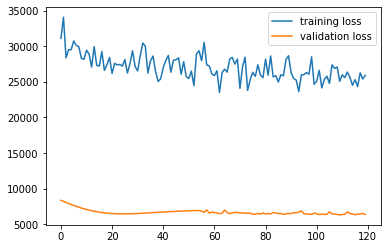

In [13]:
# split2
train_dataset = DustPredictionDataset(torch.load(meteorology_train_paths[1]),
                                      torch.load(dust_train_paths[1]),
                                      torch.load(metadata_times_train_paths[1]))
valid_dataset = DustPredictionDataset(torch.load(meteorology_valid_paths[1]),
                                      torch.load(dust_valid_paths[1]),
                                      torch.load(metadata_times_valid_paths[1]))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,collate_fn=dust_prediction_collate)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True,collate_fn=dust_prediction_collate)

sample_data = next(iter(train_loader))
print("Sample data loading:")
print(sample_data[0][0].shape, sample_data[0][1].shape, len(sample_data[1]))

model_split2 = ViT.VisionTransformer(img_size=(81,81), patch_size=(9,9), in_chans=17, num_classes=10, embed_dim=512, 
                 depth=8, num_heads=8, mlp_ratio=4., qkv_bias=True, representation_size=None, distilled=False,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.)
model_split2 = model_split2.to(device)

criterion = nn.MSELoss() # to be used inside the dust_loss
lr = 0.00001
optimizer = torch.optim.Adam(model_split2.parameters(), lr=lr)
num_epochs = 120

train_losses_split2,valid_losses_split2 = train_loop(model_split2, optimizer, train_loader, valid_loader, 
                                                     device, epochs=num_epochs, valid_every=1,loss_cfg=None,
                                                     sample_predictions_every=5, sample_size=5, sample_cols=[0],
                                                     loss_plot_end=True, debug=True)

In [14]:
# split3 - something is bad with the data - unexpected EOF, expected 4014429833 more bytes. The file might be corrupted.
# train_dataset = DustPredictionDataset(torch.load(meteorology_train_paths[2]),
#                                       torch.load(dust_train_paths[2]),
#                                       torch.load(metadata_times_train_paths[2]))
# valid_dataset = DustPredictionDataset(torch.load(meteorology_valid_paths[2]),
#                                       torch.load(dust_valid_paths[2]),
#                                       torch.load(metadata_times_valid_paths[2]))
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,collate_fn=dust_prediction_collate)
# valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True,collate_fn=dust_prediction_collate)

# sample_data = next(iter(train_loader))
# print("Sample data loading:")
# print(sample_data[0][0].shape, sample_data[0][1].shape, len(sample_data[1]))

# model_split3 = ViT.VisionTransformer(img_size=(81,81), patch_size=(9,9), in_chans=17, num_classes=10, embed_dim=512, 
#                  depth=8, num_heads=8, mlp_ratio=4., qkv_bias=True, representation_size=None, distilled=False,
#                  drop_rate=0., attn_drop_rate=0., drop_path_rate=0.)
# model_split3 = model_split3.to(device)

# criterion = nn.MSELoss() # to be used inside the dust_loss
# lr = 0.0001
# optimizer = torch.optim.Adam(model_split3.parameters(), lr=lr)
# num_epochs = 1

# train_losses_split3,valid_losses_split3 = train_loop(model_split3, optimizer, train_loader, valid_loader, 
#                                                      device, epochs=num_epochs, valid_every=1,loss_cfg=None,
#                                                      sample_predictions_every=2, sample_size=5, sample_cols=[0],
#                                                      loss_plot_end=True)

In [15]:
# # split4 - something is bad with the data - Ran out of input (train_dataset)
# train_dataset = DustPredictionDataset(torch.load(meteorology_train_paths[3]),
#                                       torch.load(dust_train_paths[3]),
#                                       torch.load(metadata_times_train_paths[3]))
# valid_dataset = DustPredictionDataset(torch.load(meteorology_valid_paths[3]),
#                                       torch.load(dust_valid_paths[3]),
#                                       torch.load(metadata_times_valid_paths[3]))
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,collate_fn=dust_prediction_collate)
# valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True,collate_fn=dust_prediction_collate)

# sample_data = next(iter(train_loader))
# print("Sample data loading:")
# print(sample_data[0][0].shape, sample_data[0][1].shape, len(sample_data[1]))

# model_split4 = ViT.VisionTransformer(img_size=(81,81), patch_size=(9,9), in_chans=17, num_classes=10, embed_dim=512, 
#                  depth=8, num_heads=8, mlp_ratio=4., qkv_bias=True, representation_size=None, distilled=False,
#                  drop_rate=0., attn_drop_rate=0., drop_path_rate=0.)
# model_split4 = model_split4.to(device)

# criterion = nn.MSELoss() # to be used inside the dust_loss
# lr = 0.001
# optimizer = torch.optim.Adam(model_split4.parameters(), lr=lr)
# num_epochs = 1

# train_losses_split4,valid_losses_split4 = train_loop(model_split4, optimizer, train_loader, valid_loader, 
#                                                      device, epochs=num_epochs, valid_every=1,loss_cfg=None,
#                                                      sample_predictions_every=2, sample_size=5, sample_cols=[0],
#                                                      loss_plot_end=True)

Sample data loading:
torch.Size([64, 17, 81, 81]) torch.Size([64, 10]) 64
Training... (Precision = out all of predicted events, <> were correct, Recall = out of all events, predicted <>)


Could not perform importance sampling for this batch:
cannot sample n_sample <= 0 samples
dust: tensor([ 46.8000,  40.4000,  95.5000,  43.1667, 148.0000,  48.7167],
       dtype=torch.float64) events: tensor([[2],
        [4]]) torch.Size([2, 1])
final_num_events: 2 num_events_to_populate = final_num_events-events_idxs.shape[0]
Train   Epoch: 001 / 120   Loss: 1.727e+04   Precision: 39.060%   Recall: 58.771%
Valid                   Loss: 2.155e+04   Precision: 14.085%   Recall: 100.000%
Train   Epoch: 002 / 120   Loss: 1.701e+04   Precision: 39.061%   Recall: 99.742%
Valid                   Loss: 2.15e+04   Precision: 14.085%   Recall: 100.000%
Could not perform importance sampling for this batch:
invalid multinomial distribution (sum of probabilities <= 0)
dust: tensor([16.4333, 49.0000, 19.1167, 58

Valid                   Loss: 2.151e+04   Precision: 14.085%   Recall: 100.000%
Could not perform importance sampling for this batch:
invalid multinomial distribution (sum of probabilities <= 0)
dust: tensor([88.3333, 37.0500, 23.3667, 20.2500, 25.5000, 30.5833],
       dtype=torch.float64) events: tensor([[0]]) torch.Size([1, 1])
final_num_events: 2 num_events_to_populate = final_num_events-events_idxs.shape[0]
Train   Epoch: 017 / 120   Loss: 1.698e+04   Precision: 39.057%   Recall: 100.000%
Valid                   Loss: 2.151e+04   Precision: 14.085%   Recall: 100.000%
Train   Epoch: 018 / 120   Loss: 1.663e+04   Precision: 39.061%   Recall: 100.000%
Valid                   Loss: 2.154e+04   Precision: 14.085%   Recall: 100.000%
Could not perform importance sampling for this batch:
cannot sample n_sample <= 0 samples
dust: tensor([ 61.8833,  52.3667,  52.2000,  87.3333, 124.9667,  91.2667],
       dtype=torch.float64) events: tensor([[3],
        [4],
        [5]]) torch.Size([3, 1]

Valid                   Loss: 2.153e+04   Precision: 14.085%   Recall: 100.000%
Train   Epoch: 033 / 120   Loss: 1.638e+04   Precision: 39.061%   Recall: 100.000%
Valid                   Loss: 2.155e+04   Precision: 14.085%   Recall: 100.000%
Could not perform importance sampling for this batch:
cannot sample n_sample <= 0 samples
dust: tensor([113.1667,  42.5500,  51.8333, 396.7500,  25.3333,  25.1167],
       dtype=torch.float64) events: tensor([[0],
        [3]]) torch.Size([2, 1])
final_num_events: 2 num_events_to_populate = final_num_events-events_idxs.shape[0]
Train   Epoch: 034 / 120   Loss: 1.624e+04   Precision: 39.061%   Recall: 100.000%
Valid                   Loss: 2.153e+04   Precision: 14.085%   Recall: 100.000%
Could not perform importance sampling for this batch:
invalid multinomial distribution (sum of probabilities <= 0)
dust: tensor([27.2500, 40.4333, 67.9167, 21.1833, 24.2667, 24.1167, 59.4000, 41.7167,
        33.7833, 25.0167, 19.4500, 30.0500, 24.7500, 49.1667, 4

Could not perform importance sampling for this batch:
invalid multinomial distribution (sum of probabilities <= 0)
dust: tensor([21.8667, 33.1333, 32.0500, 31.0000, 15.8667, 18.7833],
       dtype=torch.float64) events: tensor([], size=(0, 1), dtype=torch.int64) torch.Size([0, 1])
final_num_events: 2 num_events_to_populate = final_num_events-events_idxs.shape[0]
Train   Epoch: 044 / 120   Loss: 1.591e+04   Precision: 42.496%   Recall: 63.711%
Valid                   Loss: 2.106e+04   Precision: 27.715%   Recall: 17.651%
Could not perform importance sampling for this batch:
invalid multinomial distribution (sum of probabilities <= 0)
dust: tensor([30.8333, 24.0000, 26.2833, 23.6333, 62.5333, 15.4500],
       dtype=torch.float64) events: tensor([], size=(0, 1), dtype=torch.int64) torch.Size([0, 1])
final_num_events: 2 num_events_to_populate = final_num_events-events_idxs.shape[0]
Train   Epoch: 045 / 120   Loss: 1.497e+04   Precision: 44.746%   Recall: 53.691%
Valid                   Los

Could not perform importance sampling for this batch:
invalid multinomial distribution (sum of probabilities <= 0)
dust: tensor([37.6000, 29.4500, 72.4167, 19.2667, 53.6333, 34.5500, 30.4833, 17.9333,
        31.5500, 15.9500, 41.0000, 37.8333, 17.3333, 46.3833, 39.2000, 28.1333,
        19.6167, 32.7500, 44.7500, 31.5667,  8.5833, 24.3667, 61.0500, 40.9167,
        45.8333, 70.3333, 19.1833, 33.8833, 61.3333, 58.3667, 38.0000, 33.0000,
        20.5000, 24.0333, 14.3833, 47.2500, 46.9167, 30.2833, 39.0167, 44.5333,
        24.7000, 44.0000, 16.5167, 22.5500, 45.7500, 36.8333, 43.7833, 25.6333,
        23.2167, 27.0000, 55.5333, 12.3333, 52.5000,  9.4500, 40.4333, 21.9667,
        67.0500, 35.2667, 57.5000, 24.7167, 63.3667, 16.8333, 61.0000, 31.9333],
       dtype=torch.float64) events: tensor([], size=(0, 1), dtype=torch.int64) torch.Size([0, 1])
final_num_events: 25 num_events_to_populate = final_num_events-events_idxs.shape[0]
Train   Epoch: 059 / 120   Loss: 1.513e+04   Precision: 

Could not perform importance sampling for this batch:
invalid multinomial distribution (sum of probabilities <= 0)
dust: tensor([76.3333, 69.9500, 25.1000, 55.6667, 25.3833, 43.4500],
       dtype=torch.float64) events: tensor([[0]]) torch.Size([1, 1])
final_num_events: 2 num_events_to_populate = final_num_events-events_idxs.shape[0]
Train   Epoch: 072 / 120   Loss: 1.551e+04   Precision: 45.554%   Recall: 55.922%
Valid                   Loss: 2.167e+04   Precision: 14.796%   Recall: 97.018%
Could not perform importance sampling for this batch:
invalid multinomial distribution (sum of probabilities <= 0)
dust: tensor([95.8833, 41.5833, 24.5833, 20.6333, 10.5000, 23.0500, 45.9500, 43.6667,
        33.0500, 53.2167,  8.2167, 63.2500, 28.7167, 48.4667, 22.3333, 55.4500,
        10.2167, 51.2333, 29.3667,  5.1167, 31.6167, 28.2500, 30.0000, 67.7833,
        23.2500, 25.0000, 41.6500, 34.2500, 25.7000, 35.0000, 55.0000, 28.9000,
        43.9667, 43.3500, 47.4667, 52.5000, 32.6833, 23.3667, 

Valid                   Loss: 2.098e+04   Precision: 16.182%   Recall: 82.588%
Could not perform importance sampling for this batch:
invalid multinomial distribution (sum of probabilities <= 0)
dust: tensor([40.3333, 56.4500, 20.4667, 28.2167, 70.6333, 32.9000, 27.0000, 49.8167,
        33.4167, 52.4500, 21.3667, 26.2167, 45.1167, 11.2667, 29.1167, 16.4667,
        57.9833, 15.6667, 46.7167, 24.4667,  8.0000, 41.1167, 24.3333, 56.2833,
        47.9000, 26.7833, 16.5333, 25.6333, 20.7167, 10.8667, 32.8333, 47.5000,
        56.2167, 14.3333, 54.5000, 16.8333, 14.0833, 21.1333, 23.5333, 44.7833,
        44.4500, 53.6000,  8.7833, 39.6667, 42.3833, 61.8833, 40.0000,  6.1667,
        41.0000, 27.0000, 38.3000, 41.2500, 22.4500, 48.4500, 23.0333, 46.3833,
        27.7000, 64.8333, 36.5167, 22.9833, 43.9167, 31.7833,  6.5833, 39.0000],
       dtype=torch.float64) events: tensor([], size=(0, 1), dtype=torch.int64) torch.Size([0, 1])
final_num_events: 25 num_events_to_populate = final_num_event

Valid                   Loss: 2.136e+04   Precision: 14.337%   Recall: 99.225%
        Sample predictions | targets (cols [:1] |  cols [1:])
	[[87.94568634 17.8       ]
	 [88.00468445 51.        ]
	 [78.30937195 58.        ]
	 [80.54267883 14.9       ]
	 [80.89324188 42.2       ]]
Train   Epoch: 101 / 120   Loss: 1.624e+04   Precision: 42.866%   Recall: 67.409%
Valid                   Loss: 2.1e+04   Precision: 23.426%   Recall: 29.517%
Could not perform importance sampling for this batch:
cannot sample n_sample <= 0 samples
dust: tensor([ 37.8667,  23.1667,  90.8833, 226.0000,  25.0833,  68.1000],
       dtype=torch.float64) events: tensor([[2],
        [3]]) torch.Size([2, 1])
final_num_events: 2 num_events_to_populate = final_num_events-events_idxs.shape[0]
Train   Epoch: 102 / 120   Loss: 1.482e+04   Precision: 47.212%   Recall: 55.329%
Valid                   Loss: 2.096e+04   Precision: 21.138%   Recall: 35.003%
Could not perform importance sampling for this batch:
invalid multin

Valid                   Loss: 2.101e+04   Precision: 25.102%   Recall: 14.609%
        Sample predictions | targets (cols [:1] |  cols [1:])
	[[ 52.92291641  33.98333333]
	 [ 37.78826141  23.33333333]
	 [ 42.07906342  38.11666667]
	 [ 43.74726868  17.7       ]
	 [ 45.64295959 114.55      ]]
Train   Epoch: 116 / 120   Loss: 1.53e+04   Precision: 46.524%   Recall: 58.009%
Valid                   Loss: 2.078e+04   Precision: 20.000%   Recall: 38.521%
Train   Epoch: 117 / 120   Loss: 1.603e+04   Precision: 44.226%   Recall: 69.470%
Valid                   Loss: 2.109e+04   Precision: 21.543%   Recall: 36.971%
Could not perform importance sampling for this batch:
invalid multinomial distribution (sum of probabilities <= 0)
dust: tensor([56.4667, 59.1167, 23.4500, 13.1333, 34.8167, 56.5667],
       dtype=torch.float64) events: tensor([], size=(0, 1), dtype=torch.int64) torch.Size([0, 1])
final_num_events: 2 num_events_to_populate = final_num_events-events_idxs.shape[0]
Train   Epoch: 118 / 1

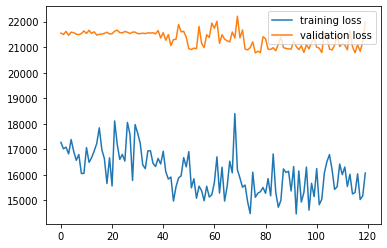

In [16]:
# split5
train_dataset = DustPredictionDataset(torch.load(meteorology_train_paths[4]),
                                      torch.load(dust_train_paths[4]),
                                      torch.load(metadata_times_train_paths[4]))
valid_dataset = DustPredictionDataset(torch.load(meteorology_valid_paths[4]),
                                      torch.load(dust_valid_paths[4]),
                                      torch.load(metadata_times_valid_paths[4]))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,collate_fn=dust_prediction_collate)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True,collate_fn=dust_prediction_collate)

sample_data = next(iter(train_loader))
print("Sample data loading:")
print(sample_data[0][0].shape, sample_data[0][1].shape, len(sample_data[1]))

model_split5 = ViT.VisionTransformer(img_size=(81,81), patch_size=(9,9), in_chans=17, num_classes=10, embed_dim=512, 
                 depth=8, num_heads=8, mlp_ratio=4., qkv_bias=True, representation_size=None, distilled=False,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.)
model_split5 = model_split5.to(device)

criterion = nn.MSELoss() # to be used inside the dust_loss
lr = 0.001
optimizer = torch.optim.Adam(model_split5.parameters(), lr=lr)
num_epochs = 120

train_losses_split5,valid_losses_split5 = train_loop(model_split5, optimizer, train_loader, valid_loader, 
                                                     device, epochs=num_epochs, valid_every=1,loss_cfg=None,
                                                     sample_predictions_every=5, sample_size=5, sample_cols=[0],
                                                     loss_plot_end=True, debug=True)

In [17]:
# split5 - different lr, more epchs
train_dataset = DustPredictionDataset(torch.load(meteorology_train_paths[4]),
                                      torch.load(dust_train_paths[4]),
                                      torch.load(metadata_times_train_paths[4]))
valid_dataset = DustPredictionDataset(torch.load(meteorology_valid_paths[4]),
                                      torch.load(dust_valid_paths[4]),
                                      torch.load(metadata_times_valid_paths[4]))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,collate_fn=dust_prediction_collate)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True,collate_fn=dust_prediction_collate)

sample_data = next(iter(train_loader))
print("Sample data loading:")
print(sample_data[0][0].shape, sample_data[0][1].shape, len(sample_data[1]))

model_split5 = ViT.VisionTransformer(img_size=(81,81), patch_size=(9,9), in_chans=17, num_classes=10, embed_dim=512, 
                 depth=8, num_heads=8, mlp_ratio=4., qkv_bias=True, representation_size=None, distilled=False,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.)
model_split5 = model_split5.to(device)

criterion = nn.MSELoss() # to be used inside the dust_loss
lr = 0.0001
optimizer = torch.optim.Adam(model_split5.parameters(), lr=lr)
num_epochs = 600

train_losses_split5,valid_losses_split5 = train_loop(model_split5, optimizer, train_loader, valid_loader, 
                                                     device, epochs=num_epochs, valid_every=1,loss_cfg=None,
                                                     sample_predictions_every=5, sample_size=5, sample_cols=[0],
                                                     loss_plot_end=True, debug=False)

Sample data loading:
torch.Size([64, 17, 81, 81]) torch.Size([64, 10]) 64
Training... (Precision = out all of predicted events, <> were correct, Recall = out of all events, predicted <>)


Train   Epoch: 001 / 600   Loss: 1.993e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss: 2.235e+04   Precision: 0.000%   Recall: 0.000%
Train   Epoch: 002 / 600   Loss: 1.726e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss: 2.15e+04   Precision: 0.000%   Recall: 0.000%
Train   Epoch: 003 / 600   Loss: 1.73e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss: 2.132e+04   Precision: 0.000%   Recall: 0.000%
Train   Epoch: 004 / 600   Loss: 1.699e+04   Precision: 39.057%   Recall: 26.046%
Valid                   Loss: 2.139e+04   Precision: 14.085%   Recall: 100.000%
Train   Epoch: 005 / 600   Loss: 1.737e+04   Precision: 39.061%   Recall: 100.000%
Valid                   Loss: 2.146e+04   Precision: 14.085%   Recall: 100.000%
        Sample pr

Train   Epoch: 041 / 600   Loss: 1.494e+04   Precision: 49.483%   Recall: 64.090%
Valid                   Loss: 2.125e+04   Precision: 22.050%   Recall: 75.313%
Train   Epoch: 042 / 600   Loss: 1.539e+04   Precision: 51.509%   Recall: 64.206%
Valid                   Loss: 2.107e+04   Precision: 23.375%   Recall: 71.855%
Train   Epoch: 043 / 600   Loss: 1.628e+04   Precision: 52.914%   Recall: 66.825%
Valid                   Loss: 2.11e+04   Precision: 26.421%   Recall: 47.406%
Train   Epoch: 044 / 600   Loss: 1.588e+04   Precision: 53.210%   Recall: 65.007%
Valid                   Loss: 2.14e+04   Precision: 14.191%   Recall: 99.940%
Train   Epoch: 045 / 600   Loss: 1.535e+04   Precision: 55.344%   Recall: 65.021%
Valid                   Loss: 2.11e+04   Precision: 23.284%   Recall: 59.690%
        Sample predictions | targets (cols [:1] |  cols [1:])
	[[ 83.08234406  31.46666667]
	 [ 83.42417908  58.95      ]
	 [158.62767029  24.75      ]
	 [ 77.37425232  49.21666667]
	 [166.01187134 

Valid                   Loss: 2.092e+04   Precision: 25.410%   Recall: 64.639%
Train   Epoch: 082 / 600   Loss: 1.432e+04   Precision: 58.795%   Recall: 63.468%
Valid                   Loss: 2.082e+04   Precision: 26.541%   Recall: 66.249%
Train   Epoch: 083 / 600   Loss: 1.457e+04   Precision: 58.438%   Recall: 63.028%
Valid                   Loss: 2.069e+04   Precision: 31.299%   Recall: 42.516%
Train   Epoch: 084 / 600   Loss: 1.487e+04   Precision: 58.953%   Recall: 63.055%
Valid                   Loss: 2.07e+04   Precision: 30.361%   Recall: 47.108%
Train   Epoch: 085 / 600   Loss: 1.456e+04   Precision: 61.417%   Recall: 62.113%
Valid                   Loss: 2.093e+04   Precision: 26.635%   Recall: 56.112%
        Sample predictions | targets (cols [:1] |  cols [1:])
	[[120.23839569  64.88333333]
	 [187.6499939   23.        ]
	 [ 62.61938477  14.36666667]
	 [ 75.27328491  63.56666667]
	 [112.70713043 143.9       ]]
Train   Epoch: 086 / 600   Loss: 1.591e+04   Precision: 60.319%  

Train   Epoch: 122 / 600   Loss: 1.353e+04   Precision: 60.905%   Recall: 57.133%
Valid                   Loss: 2.101e+04   Precision: 23.110%   Recall: 67.263%
Train   Epoch: 123 / 600   Loss: 1.443e+04   Precision: 59.697%   Recall: 60.503%
Valid                   Loss: 2.099e+04   Precision: 19.305%   Recall: 84.794%
Train   Epoch: 124 / 600   Loss: 1.464e+04   Precision: 61.222%   Recall: 57.869%
Valid                   Loss: 2.062e+04   Precision: 30.671%   Recall: 45.796%
Train   Epoch: 125 / 600   Loss: 1.394e+04   Precision: 59.446%   Recall: 59.029%
Valid                   Loss: 2.13e+04   Precision: 20.501%   Recall: 78.593%
        Sample predictions | targets (cols [:1] |  cols [1:])
	[[51.21236038 21.13333333]
	 [62.20923996  9.55      ]
	 [55.41076279 19.08333333]
	 [70.03057861 54.61666667]
	 [81.39678955 25.8       ]]
Train   Epoch: 126 / 600   Loss: 1.4e+04   Precision: 60.309%   Recall: 59.072%
Valid                   Loss: 2.064e+04   Precision: 32.161%   Recall: 44.

Train   Epoch: 163 / 600   Loss: 1.421e+04   Precision: 57.626%   Recall: 58.814%
Valid                   Loss: 2.108e+04   Precision: 22.167%   Recall: 83.065%
Train   Epoch: 164 / 600   Loss: 1.425e+04   Precision: 58.029%   Recall: 57.951%
Valid                   Loss: 2.069e+04   Precision: 26.277%   Recall: 63.208%
Train   Epoch: 165 / 600   Loss: 1.293e+04   Precision: 62.176%   Recall: 58.184%
Valid                   Loss: 2.08e+04   Precision: 30.780%   Recall: 41.205%
        Sample predictions | targets (cols [:1] |  cols [1:])
	[[108.08190918  40.38333333]
	 [ 57.02378082  15.33333333]
	 [170.47167969  59.        ]
	 [ 53.22928619  33.4       ]
	 [ 46.90036392  35.38333333]]
Train   Epoch: 166 / 600   Loss: 1.239e+04   Precision: 62.530%   Recall: 59.771%
Valid                   Loss: 2.076e+04   Precision: 27.359%   Recall: 60.346%
Train   Epoch: 167 / 600   Loss: 1.385e+04   Precision: 60.783%   Recall: 58.897%
Valid                   Loss: 2.068e+04   Precision: 28.242%  

Valid                   Loss: 2.108e+04   Precision: 28.775%   Recall: 49.434%
Train   Epoch: 204 / 600   Loss: 1.142e+04   Precision: 64.513%   Recall: 59.598%
Valid                   Loss: 2.1e+04   Precision: 25.882%   Recall: 62.552%
Train   Epoch: 205 / 600   Loss: 1.168e+04   Precision: 62.937%   Recall: 59.330%
Valid                   Loss: 2.094e+04   Precision: 33.164%   Recall: 38.998%
        Sample predictions | targets (cols [:1] |  cols [1:])
	[[55.73574829 47.71666667]
	 [29.97441864 28.21666667]
	 [42.27357864 36.91666667]
	 [40.56290054 36.73333333]
	 [31.55422592 19.7       ]]
Train   Epoch: 206 / 600   Loss: 1.208e+04   Precision: 61.238%   Recall: 61.402%
Valid                   Loss: 2.13e+04   Precision: 29.224%   Recall: 35.480%
Train   Epoch: 207 / 600   Loss: 1.169e+04   Precision: 63.851%   Recall: 56.505%
Valid                   Loss: 2.1e+04   Precision: 27.257%   Recall: 57.424%
Train   Epoch: 208 / 600   Loss: 1.182e+04   Precision: 63.133%   Recall: 58.74

Valid                   Loss: 2.161e+04   Precision: 28.694%   Recall: 51.878%
Train   Epoch: 245 / 600   Loss: 1.097e+04   Precision: 65.023%   Recall: 59.802%
Valid                   Loss: 2.093e+04   Precision: 31.129%   Recall: 40.429%
        Sample predictions | targets (cols [:1] |  cols [1:])
	[[46.08694077 35.25      ]
	 [44.78743362 63.25      ]
	 [67.70677948 16.38333333]
	 [62.3338356  41.98333333]
	 [46.5143013  44.78333333]]
Train   Epoch: 246 / 600   Loss: 1.138e+04   Precision: 64.383%   Recall: 61.031%
Valid                   Loss: 2.126e+04   Precision: 26.802%   Recall: 63.208%
Train   Epoch: 247 / 600   Loss: 1.062e+04   Precision: 65.126%   Recall: 60.864%
Valid                   Loss: 2.113e+04   Precision: 26.996%   Recall: 67.740%
Train   Epoch: 248 / 600   Loss: 1.099e+04   Precision: 64.962%   Recall: 63.763%
Valid                   Loss: 2.131e+04   Precision: 23.100%   Recall: 72.868%
Train   Epoch: 249 / 600   Loss: 1.109e+04   Precision: 64.667%   Recall: 

Valid                   Loss: 2.24e+04   Precision: 18.909%   Recall: 82.230%
        Sample predictions | targets (cols [:1] |  cols [1:])
	[[ 72.49356079  56.28333333]
	 [247.52966309 397.38333333]
	 [179.95953369  31.71666667]
	 [104.65154266  41.28333333]
	 [ 69.32852936  73.38333333]]
Train   Epoch: 286 / 600   Loss: 1.023e+04   Precision: 64.123%   Recall: 60.216%
Valid                   Loss: 2.105e+04   Precision: 23.631%   Recall: 61.240%
Train   Epoch: 287 / 600   Loss: 1.022e+04   Precision: 66.753%   Recall: 61.083%
Valid                   Loss: 2.163e+04   Precision: 27.575%   Recall: 53.488%
Train   Epoch: 288 / 600   Loss:    9819   Precision: 67.711%   Recall: 60.381%
Valid                   Loss: 2.134e+04   Precision: 27.163%   Recall: 60.465%
Train   Epoch: 289 / 600   Loss:    9659   Precision: 66.886%   Recall: 61.065%
Valid                   Loss: 2.121e+04   Precision: 30.021%   Recall: 52.236%
Train   Epoch: 290 / 600   Loss:    9710   Precision: 67.724%   Recal

Train   Epoch: 326 / 600   Loss:    8934   Precision: 67.799%   Recall: 60.678%
Valid                   Loss: 2.203e+04   Precision: 26.754%   Recall: 62.314%
Train   Epoch: 327 / 600   Loss:    9600   Precision: 65.967%   Recall: 60.062%
Valid                   Loss: 2.147e+04   Precision: 28.856%   Recall: 38.044%
Train   Epoch: 328 / 600   Loss:    9648   Precision: 67.703%   Recall: 61.255%
Valid                   Loss: 2.166e+04   Precision: 26.930%   Recall: 64.699%
Train   Epoch: 329 / 600   Loss:    9020   Precision: 67.988%   Recall: 61.868%
Valid                   Loss: 2.131e+04   Precision: 33.063%   Recall: 46.273%
Train   Epoch: 330 / 600   Loss:    9122   Precision: 68.464%   Recall: 60.709%
Valid                   Loss: 2.149e+04   Precision: 30.844%   Recall: 57.126%
        Sample predictions | targets (cols [:1] |  cols [1:])
	[[63.1541214  43.2       ]
	 [74.58315277 31.25      ]
	 [56.64138031 40.5       ]
	 [53.49605942 24.81666667]
	 [89.81612396 28.58333333]]
Tr

Valid                   Loss: 2.093e+04   Precision: 29.903%   Recall: 58.915%
Train   Epoch: 368 / 600   Loss:    8348   Precision: 68.945%   Recall: 60.297%
Valid                   Loss: 2.183e+04   Precision: 31.354%   Recall: 45.975%
Train   Epoch: 369 / 600   Loss:    8062   Precision: 69.812%   Recall: 60.604%
Valid                   Loss: 2.134e+04   Precision: 30.723%   Recall: 48.897%
Train   Epoch: 370 / 600   Loss:    9757   Precision: 64.637%   Recall: 61.379%
Valid                   Loss: 2.11e+04   Precision: 21.651%   Recall: 75.373%
        Sample predictions | targets (cols [:1] |  cols [1:])
	[[ 65.29911804  43.28333333]
	 [ 46.66789627  45.        ]
	 [ 47.67671585  23.5       ]
	 [ 41.25035095  47.71666667]
	 [115.02767944  28.25      ]]
Train   Epoch: 371 / 600   Loss: 1.449e+04   Precision: 55.984%   Recall: 64.577%
Valid                   Loss: 2.24e+04   Precision: 20.070%   Recall: 81.574%
Train   Epoch: 372 / 600   Loss: 1.381e+04   Precision: 57.923%   Recall

Valid                   Loss: 2.136e+04   Precision: 28.934%   Recall: 50.984%
Train   Epoch: 409 / 600   Loss:    7302   Precision: 71.851%   Recall: 62.667%
Valid                   Loss: 2.175e+04   Precision: 30.620%   Recall: 34.764%
Train   Epoch: 410 / 600   Loss:    7285   Precision: 72.640%   Recall: 64.090%
Valid                   Loss: 2.161e+04   Precision: 28.982%   Recall: 49.255%
        Sample predictions | targets (cols [:1] |  cols [1:])
	[[ 58.18740082  34.83333333]
	 [ 55.72742081  35.45      ]
	 [282.1305542  322.        ]
	 [ 67.73628235  74.88333333]
	 [ 45.99969864  40.65      ]]
Train   Epoch: 411 / 600   Loss:    6944   Precision: 72.994%   Recall: 61.715%
Valid                   Loss: 2.179e+04   Precision: 30.270%   Recall: 46.750%
Train   Epoch: 412 / 600   Loss:    6458   Precision: 74.679%   Recall: 61.333%
Valid                   Loss: 2.267e+04   Precision: 29.724%   Recall: 39.773%
Train   Epoch: 413 / 600   Loss:    7236   Precision: 72.253%   Recall: 

Train   Epoch: 450 / 600   Loss:    5325   Precision: 78.255%   Recall: 64.543%
Valid                   Loss: 2.155e+04   Precision: 31.683%   Recall: 41.980%
        Sample predictions | targets (cols [:1] |  cols [1:])
	[[47.71308899 21.63333333]
	 [71.70348358 24.23333333]
	 [33.25528717 25.46666667]
	 [61.08345032 20.46666667]
	 [77.35211945 99.78333333]]
Train   Epoch: 451 / 600   Loss:    5424   Precision: 78.123%   Recall: 64.451%
Valid                   Loss: 2.16e+04   Precision: 26.156%   Recall: 55.337%
Train   Epoch: 452 / 600   Loss:    5399   Precision: 77.096%   Recall: 62.832%
Valid                   Loss: 2.195e+04   Precision: 28.784%   Recall: 46.035%
Train   Epoch: 453 / 600   Loss:    5608   Precision: 77.130%   Recall: 62.877%
Valid                   Loss: 2.158e+04   Precision: 31.838%   Recall: 39.773%
Train   Epoch: 454 / 600   Loss:    5468   Precision: 78.349%   Recall: 65.162%
Valid                   Loss: 2.183e+04   Precision: 29.675%   Recall: 45.796%
Tra

Train   Epoch: 491 / 600   Loss:    4490   Precision: 78.702%   Recall: 66.120%
Valid                   Loss: 2.17e+04   Precision: 29.318%   Recall: 46.154%
Train   Epoch: 492 / 600   Loss:    4228   Precision: 81.407%   Recall: 66.309%
Valid                   Loss: 2.178e+04   Precision: 28.315%   Recall: 49.791%
Train   Epoch: 493 / 600   Loss:    4266   Precision: 82.362%   Recall: 67.876%
Valid                   Loss: 2.178e+04   Precision: 32.157%   Recall: 29.338%
Train   Epoch: 494 / 600   Loss:    6080   Precision: 76.782%   Recall: 64.935%
Valid                   Loss: 2.138e+04   Precision: 30.254%   Recall: 39.833%
Train   Epoch: 495 / 600   Loss:    5075   Precision: 79.271%   Recall: 65.430%
Valid                   Loss: 2.187e+04   Precision: 29.944%   Recall: 31.604%
        Sample predictions | targets (cols [:1] |  cols [1:])
	[[53.97203445 91.21666667]
	 [62.90333939 24.98333333]
	 [42.16583252 27.71666667]
	 [21.61740494 13.51666667]
	 [41.84127426 30.61666667]]
Tra

Valid                   Loss: 2.201e+04   Precision: 27.968%   Recall: 42.278%
Train   Epoch: 533 / 600   Loss:    4278   Precision: 82.097%   Recall: 69.767%
Valid                   Loss: 2.197e+04   Precision: 28.203%   Recall: 39.117%
Train   Epoch: 534 / 600   Loss:    3893   Precision: 83.292%   Recall: 68.505%
Valid                   Loss: 2.162e+04   Precision: 31.808%   Recall: 33.154%
Train   Epoch: 535 / 600   Loss:    4516   Precision: 78.630%   Recall: 67.216%
Valid                   Loss: 2.222e+04   Precision: 29.278%   Recall: 35.301%
        Sample predictions | targets (cols [:1] |  cols [1:])
	[[32.16859436 45.6       ]
	 [50.85908127 52.36666667]
	 [31.73122787 37.58333333]
	 [47.55331421 13.38333333]
	 [47.35057068 35.41666667]]
Train   Epoch: 536 / 600   Loss:    3591   Precision: 84.367%   Recall: 68.419%
Valid                   Loss: 2.17e+04   Precision: 30.878%   Recall: 35.242%
Train   Epoch: 537 / 600   Loss:    3617   Precision: 84.081%   Recall: 67.790%
Val

Train   Epoch: 574 / 600   Loss:    2890   Precision: 86.202%   Recall: 70.268%
Valid                   Loss: 2.184e+04   Precision: 30.447%   Recall: 33.333%
Train   Epoch: 575 / 600   Loss:    2897   Precision: 86.391%   Recall: 71.794%
Valid                   Loss: 2.195e+04   Precision: 28.163%   Recall: 40.489%
        Sample predictions | targets (cols [:1] |  cols [1:])
	[[38.12430573 42.58333333]
	 [16.09932518 32.4       ]
	 [64.03116608 56.45      ]
	 [66.61441803 15.3       ]
	 [45.45719147 40.        ]]
Train   Epoch: 576 / 600   Loss:    2782   Precision: 87.282%   Recall: 72.732%
Valid                   Loss: 2.197e+04   Precision: 28.100%   Recall: 38.104%
Train   Epoch: 577 / 600   Loss:    2770   Precision: 87.045%   Recall: 71.691%
Valid                   Loss: 2.189e+04   Precision: 28.081%   Recall: 32.200%
Train   Epoch: 578 / 600   Loss:    2945   Precision: 85.190%   Recall: 71.753%
Valid                   Loss: 2.216e+04   Precision: 26.843%   Recall: 41.264%
Tr

In [25]:
not (len(train_losses_split5) == len(valid_losses_split5))

False

In [21]:
from utils.training_loop_plotting import *
plot_train_valid(train_losses_split5,valid_losses_split5)

Wrong lengths - could not plot


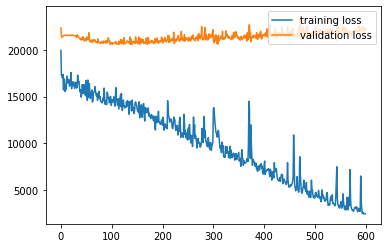

In [23]:
x = [i for i in range(len(train_losses_split5))]
fig, ax = plt.subplots()
ax.plot(x, train_losses_split5, label='training loss')
ax.plot(x, valid_losses_split5, label='validation loss')
legend = ax.legend(loc='upper right')
plt.show()    

Sample data loading:
torch.Size([512, 17, 81, 81]) torch.Size([512, 10]) 512
Training... (Precision = out all of predicted events, <> were correct, Recall = out of all events, predicted <>)


Train   Epoch: 001 / 600   Loss: 1.487e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss: 1.536e+04   Precision: 0.000%   Recall: 0.000%
Train   Epoch: 002 / 600   Loss: 1.499e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss: 1.518e+04   Precision: 0.000%   Recall: 0.000%
Train   Epoch: 003 / 600   Loss: 1.43e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss: 1.499e+04   Precision: 0.000%   Recall: 0.000%
Train   Epoch: 004 / 600   Loss: 1.455e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss: 1.481e+04   Precision: 0.000%   Recall: 0.000%
Train   Epoch: 005 / 600   Loss: 1.39e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss: 1.464e+04   Precision: 0.000%   Recall: 0.000%
        [Sample predictio

Train   Epoch: 041 / 600   Loss: 1.199e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss: 1.374e+04   Precision: 14.085%   Recall: 100.000%
Train   Epoch: 042 / 600   Loss: 1.179e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss: 1.374e+04   Precision: 14.085%   Recall: 100.000%
Train   Epoch: 043 / 600   Loss: 1.195e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss: 1.374e+04   Precision: 14.085%   Recall: 100.000%
Train   Epoch: 044 / 600   Loss: 1.177e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss: 1.374e+04   Precision: 14.085%   Recall: 100.000%
Train   Epoch: 045 / 600   Loss: 1.2e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss: 1.376e+04   Precision: 14.085%   Recall: 100.000%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[ 87.6231842   19.1       ]
	 [ 87.61081696  65.5       ]
	 [ 87.63365936 130.55      ]
	 [ 87.60635376  54.53333333]
	 

Valid                   Loss: 1.354e+04   Precision: 19.584%   Recall: 83.005%
Train   Epoch: 082 / 600   Loss: 1.206e+04   Precision: 46.730%   Recall: 78.628%
Valid                   Loss: 1.383e+04   Precision: 14.187%   Recall: 99.881%
Train   Epoch: 083 / 600   Loss: 1.097e+04   Precision: 47.190%   Recall: 81.114%
Valid                   Loss: 1.368e+04   Precision: 16.912%   Recall: 95.110%
Train   Epoch: 084 / 600   Loss: 1.214e+04   Precision: 48.740%   Recall: 76.021%
Valid                   Loss: 1.353e+04   Precision: 19.602%   Recall: 86.822%
Train   Epoch: 085 / 600   Loss: 1.151e+04   Precision: 50.179%   Recall: 75.091%
Valid                   Loss: 1.368e+04   Precision: 17.309%   Recall: 94.275%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[ 68.59745789  26.01666667]
	 [107.43405914  18.43333333]
	 [ 71.20518494  49.96666667]
	 [ 86.83722687  22.21666667]
	 [ 76.41842651  17.5       ]]
Train   Epoch: 086 / 600   Loss: 1.156e+04   Precision: 50.13

Train   Epoch: 122 / 600   Loss: 1.147e+04   Precision: 56.835%   Recall: 58.438%
Valid                   Loss: 1.366e+04   Precision: 22.443%   Recall: 67.382%
Train   Epoch: 123 / 600   Loss: 1.038e+04   Precision: 57.252%   Recall: 59.115%
Valid                   Loss: 1.339e+04   Precision: 23.715%   Recall: 64.639%
Train   Epoch: 124 / 600   Loss: 1.074e+04   Precision: 56.934%   Recall: 58.498%
Valid                   Loss: 1.319e+04   Precision: 31.760%   Recall: 35.301%
Train   Epoch: 125 / 600   Loss: 1.151e+04   Precision: 56.644%   Recall: 58.973%
Valid                   Loss: 1.381e+04   Precision: 18.430%   Recall: 90.459%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[ 80.26506805  26.4       ]
	 [ 73.18143463  38.55      ]
	 [123.46315002  62.71666667]
	 [157.35354614  38.7       ]
	 [196.83015442 117.95      ]]
Train   Epoch: 126 / 600   Loss: 1.087e+04   Precision: 56.603%   Recall: 57.993%
Valid                   Loss: 1.319e+04   Precision: 27.74

Valid                   Loss: 1.316e+04   Precision: 25.478%   Recall: 56.470%
Train   Epoch: 163 / 600   Loss: 1.092e+04   Precision: 58.811%   Recall: 61.479%
Valid                   Loss: 1.342e+04   Precision: 23.286%   Recall: 62.791%
Train   Epoch: 164 / 600   Loss: 1.102e+04   Precision: 57.949%   Recall: 59.044%
Valid                   Loss: 1.321e+04   Precision: 23.717%   Recall: 60.346%
Train   Epoch: 165 / 600   Loss: 1.06e+04   Precision: 58.706%   Recall: 60.065%
Valid                   Loss: 1.394e+04   Precision: 17.240%   Recall: 88.790%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[80.83850861 36.23333333]
	 [56.29362869 36.        ]
	 [84.63293457 40.5       ]
	 [81.13173676 45.91666667]
	 [56.3010788  51.11666667]]
Train   Epoch: 166 / 600   Loss: 1.02e+04   Precision: 56.576%   Recall: 63.288%
Valid                   Loss: 1.321e+04   Precision: 24.852%   Recall: 59.928%
Train   Epoch: 167 / 600   Loss: 1.061e+04   Precision: 58.519%   Recall:

Train   Epoch: 203 / 600   Loss:    9601   Precision: 61.476%   Recall: 58.407%
Valid                   Loss: 1.306e+04   Precision: 25.173%   Recall: 58.617%
Train   Epoch: 204 / 600   Loss: 1.06e+04   Precision: 61.130%   Recall: 58.579%
Valid                   Loss: 1.317e+04   Precision: 23.983%   Recall: 64.699%
Train   Epoch: 205 / 600   Loss: 1.026e+04   Precision: 58.879%   Recall: 58.832%
Valid                   Loss: 1.345e+04   Precision: 21.384%   Recall: 69.648%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[ 88.13156891  22.91666667]
	 [ 57.64624786  26.85      ]
	 [ 94.78791809  42.05      ]
	 [ 76.30436707  27.8       ]
	 [258.50286865 105.16666667]]
Train   Epoch: 206 / 600   Loss:    9460   Precision: 60.000%   Recall: 56.902%
Valid                   Loss: 1.317e+04   Precision: 28.390%   Recall: 52.057%
Train   Epoch: 207 / 600   Loss: 1.075e+04   Precision: 56.307%   Recall: 61.570%
Valid                   Loss: 1.324e+04   Precision: 22.356%   

Train   Epoch: 244 / 600   Loss:    9649   Precision: 61.633%   Recall: 58.812%
Valid                   Loss: 1.329e+04   Precision: 24.679%   Recall: 63.029%
Train   Epoch: 245 / 600   Loss:    9110   Precision: 62.967%   Recall: 58.023%
Valid                   Loss: 1.303e+04   Precision: 29.735%   Recall: 44.186%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[138.68399048 113.25      ]
	 [ 74.39031982  26.4       ]
	 [ 74.94272614  93.66666667]
	 [119.91348267  44.2       ]
	 [ 47.9067955   33.65      ]]
Train   Epoch: 246 / 600   Loss:    9027   Precision: 63.008%   Recall: 56.437%
Valid                   Loss: 1.32e+04   Precision: 26.587%   Recall: 54.442%
Train   Epoch: 247 / 600   Loss:    9259   Precision: 64.257%   Recall: 57.407%
Valid                   Loss: 1.306e+04   Precision: 26.698%   Recall: 53.906%
Train   Epoch: 248 / 600   Loss:    9506   Precision: 63.324%   Recall: 57.751%
Valid                   Loss: 1.337e+04   Precision: 23.528%   Recall

Train   Epoch: 285 / 600   Loss:    9037   Precision: 66.607%   Recall: 56.882%
Valid                   Loss: 1.29e+04   Precision: 28.524%   Recall: 40.906%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[79.39962006 27.95      ]
	 [33.15042114 31.93333333]
	 [62.79908752 30.4       ]
	 [55.79094696 37.78333333]
	 [48.88573837 49.51666667]]
Train   Epoch: 286 / 600   Loss:    9019   Precision: 65.772%   Recall: 57.943%
Valid                   Loss: 1.292e+04   Precision: 30.252%   Recall: 42.934%
Train   Epoch: 287 / 600   Loss:    8638   Precision: 65.701%   Recall: 55.457%
Valid                   Loss: 1.293e+04   Precision: 28.479%   Recall: 42.099%
Train   Epoch: 288 / 600   Loss:    8479   Precision: 65.833%   Recall: 57.730%
Valid                   Loss: 1.29e+04   Precision: 26.701%   Recall: 46.810%
Train   Epoch: 289 / 600   Loss:    8134   Precision: 67.417%   Recall: 56.326%
Valid                   Loss: 1.291e+04   Precision: 28.024%   Recall: 46.691%
T

Train   Epoch: 326 / 600   Loss:    7506   Precision: 69.291%   Recall: 56.568%
Valid                   Loss: 1.318e+04   Precision: 26.602%   Recall: 55.695%
Train   Epoch: 327 / 600   Loss:    7783   Precision: 68.834%   Recall: 59.701%
Valid                   Loss: 1.286e+04   Precision: 31.881%   Recall: 40.131%
Train   Epoch: 328 / 600   Loss:    8256   Precision: 69.307%   Recall: 56.770%
Valid                   Loss: 1.304e+04   Precision: 29.697%   Recall: 42.695%
Train   Epoch: 329 / 600   Loss:    8074   Precision: 66.909%   Recall: 59.600%
Valid                   Loss: 1.287e+04   Precision: 35.527%   Recall: 26.714%
Train   Epoch: 330 / 600   Loss:    7933   Precision: 67.856%   Recall: 57.084%
Valid                   Loss: 1.306e+04   Precision: 28.915%   Recall: 45.140%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[103.67805481  68.4       ]
	 [ 81.10794067  17.58333333]
	 [ 65.41323853  48.13333333]
	 [ 36.57358551  24.73333333]
	 [ 44.18000793  58.

Train   Epoch: 367 / 600   Loss:    7179   Precision: 72.283%   Recall: 58.397%
Valid                   Loss: 1.316e+04   Precision: 31.724%   Recall: 39.177%
Train   Epoch: 368 / 600   Loss:    7469   Precision: 71.767%   Recall: 59.388%
Valid                   Loss: 1.32e+04   Precision: 29.016%   Recall: 47.823%
Train   Epoch: 369 / 600   Loss:    6972   Precision: 70.891%   Recall: 57.831%
Valid                   Loss: 1.312e+04   Precision: 31.910%   Recall: 31.187%
Train   Epoch: 370 / 600   Loss:    6857   Precision: 73.215%   Recall: 58.640%
Valid                   Loss: 1.321e+04   Precision: 34.557%   Recall: 29.756%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[52.8789978  87.11666667]
	 [57.63444138 27.2       ]
	 [87.25917053 72.51666667]
	 [38.12043762 62.95      ]
	 [56.31330109 55.5       ]]
Train   Epoch: 371 / 600   Loss:    6708   Precision: 71.241%   Recall: 58.023%
Valid                   Loss: 1.33e+04   Precision: 27.414%   Recall: 49.612%
T

Valid                   Loss: 1.344e+04   Precision: 29.671%   Recall: 42.993%
Train   Epoch: 409 / 600   Loss:    6200   Precision: 73.957%   Recall: 61.237%
Valid                   Loss: 1.339e+04   Precision: 30.804%   Recall: 36.315%
Train   Epoch: 410 / 600   Loss:    6257   Precision: 74.864%   Recall: 61.217%
Valid                   Loss: 1.342e+04   Precision: 32.593%   Recall: 28.861%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[123.86209106 160.28333333]
	 [ 35.72421265  39.33333333]
	 [ 93.26179504  69.91666667]
	 [ 26.87696266  25.45      ]
	 [ 21.80999565  42.36666667]]
Train   Epoch: 411 / 600   Loss:    5969   Precision: 75.278%   Recall: 61.661%
Valid                   Loss: 1.338e+04   Precision: 29.415%   Recall: 34.168%
Train   Epoch: 412 / 600   Loss:    5849   Precision: 74.712%   Recall: 60.338%
Valid                   Loss: 1.345e+04   Precision: 30.215%   Recall: 34.287%
Train   Epoch: 413 / 600   Loss:    6030   Precision: 73.801%   Recal

Valid                   Loss: 1.351e+04   Precision: 33.376%   Recall: 31.187%
Train   Epoch: 450 / 600   Loss:    5384   Precision: 76.729%   Recall: 61.308%
Valid                   Loss: 1.359e+04   Precision: 31.389%   Recall: 39.475%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[42.06289291 73.41666667]
	 [67.63435364 32.11666667]
	 [39.90452957 43.25      ]
	 [82.80216217 72.11666667]
	 [49.28898621 66.11666667]]
Train   Epoch: 451 / 600   Loss:    5413   Precision: 76.969%   Recall: 61.833%
Valid                   Loss: 1.349e+04   Precision: 33.716%   Recall: 31.485%
Train   Epoch: 452 / 600   Loss:    5286   Precision: 76.653%   Recall: 61.146%
Valid                   Loss: 1.343e+04   Precision: 33.293%   Recall: 32.558%
Train   Epoch: 453 / 600   Loss:    4874   Precision: 78.276%   Recall: 60.914%
Valid                   Loss: 1.347e+04   Precision: 32.350%   Recall: 35.301%
Train   Epoch: 454 / 600   Loss:    5200   Precision: 76.050%   Recall: 63.308%

Valid                   Loss: 1.348e+04   Precision: 36.685%   Recall: 28.503%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[52.22548294 17.55      ]
	 [40.30406952 33.41666667]
	 [30.15967751 32.83333333]
	 [37.14579391 58.        ]
	 [73.49197388 29.66666667]]
Train   Epoch: 491 / 600   Loss:    4788   Precision: 78.587%   Recall: 63.864%
Valid                   Loss: 1.357e+04   Precision: 35.858%   Recall: 27.668%
Train   Epoch: 492 / 600   Loss:    4857   Precision: 78.099%   Recall: 64.430%
Valid                   Loss: 1.378e+04   Precision: 33.401%   Recall: 29.219%
Train   Epoch: 493 / 600   Loss:    4903   Precision: 79.819%   Recall: 63.349%
Valid                   Loss: 1.354e+04   Precision: 35.507%   Recall: 24.031%
Train   Epoch: 494 / 600   Loss:    4764   Precision: 78.270%   Recall: 63.076%
Valid                   Loss: 1.361e+04   Precision: 28.160%   Recall: 49.016%
Train   Epoch: 495 / 600   Loss:    5075   Precision: 78.595%   Recall: 63.632%

Train   Epoch: 531 / 600   Loss:    4462   Precision: 80.974%   Recall: 67.047%
Valid                   Loss: 1.357e+04   Precision: 35.583%   Recall: 31.127%
Train   Epoch: 532 / 600   Loss:    4200   Precision: 81.587%   Recall: 65.956%
Valid                   Loss: 1.393e+04   Precision: 29.599%   Recall: 37.806%
Train   Epoch: 533 / 600   Loss:    4166   Precision: 80.674%   Recall: 66.310%
Valid                   Loss: 1.374e+04   Precision: 33.577%   Recall: 30.173%
Train   Epoch: 534 / 600   Loss:    4170   Precision: 81.652%   Recall: 65.744%
Valid                   Loss: 1.364e+04   Precision: 31.761%   Recall: 38.939%
Train   Epoch: 535 / 600   Loss:    4231   Precision: 80.081%   Recall: 66.219%
Valid                   Loss: 1.386e+04   Precision: 39.801%   Recall: 19.082%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[68.31739044 79.9       ]
	 [ 4.61998558 20.4       ]
	 [49.95678711 39.3       ]
	 [17.59426498 45.33333333]
	 [17.48649597 46.        ]]

Valid                   Loss: 1.381e+04   Precision: 29.830%   Recall: 35.540%
Train   Epoch: 573 / 600   Loss:    3598   Precision: 82.559%   Recall: 67.017%
Valid                   Loss: 1.378e+04   Precision: 33.950%   Recall: 27.370%
Train   Epoch: 574 / 600   Loss:    3728   Precision: 82.268%   Recall: 66.997%
Valid                   Loss: 1.366e+04   Precision: 33.221%   Recall: 29.278%
Train   Epoch: 575 / 600   Loss:    3716   Precision: 82.735%   Recall: 66.582%
Valid                   Loss: 1.355e+04   Precision: 32.730%   Recall: 30.173%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[55.82770157 92.83333333]
	 [95.33073425 63.43333333]
	 [38.24614334 17.83333333]
	 [21.3167038  23.71666667]
	 [30.92884064 47.        ]]
Train   Epoch: 576 / 600   Loss:    3666   Precision: 82.182%   Recall: 68.189%
Valid                   Loss: 1.379e+04   Precision: 33.845%   Recall: 27.609%
Train   Epoch: 577 / 600   Loss:    3635   Precision: 82.403%   Recall: 65.966%

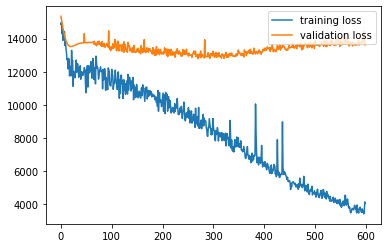

In [8]:
# split5 - different lr, more epchs, larger batch, dropout, loss with decaying_weights

from training.dust_loss import *
loss_cfg = LossConfig(device, decaying_weights=True)

train_dataset = DustPredictionDataset(torch.load(meteorology_train_paths[4]),
                                      torch.load(dust_train_paths[4]),
                                      torch.load(metadata_times_train_paths[4]))
valid_dataset = DustPredictionDataset(torch.load(meteorology_valid_paths[4]),
                                      torch.load(dust_valid_paths[4]),
                                      torch.load(metadata_times_valid_paths[4]))
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True,collate_fn=train_dataset.collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=512, shuffle=True,collate_fn=train_dataset.collate_fn)

sample_data = next(iter(train_loader))
print("Sample data loading:")
print(sample_data[0][0].shape, sample_data[0][1].shape, len(sample_data[1]))

model_split5 = ViT.VisionTransformer(img_size=(81,81), patch_size=(9,9), in_chans=17, num_classes=10, embed_dim=512, 
                 depth=8, num_heads=8, mlp_ratio=2., qkv_bias=True, representation_size=None, distilled=False,
                 drop_rate=0.1, attn_drop_rate=0.1, drop_path_rate=0.1)
model_split5 = model_split5.to(device)

criterion = nn.MSELoss() # to be used inside the dust_loss
lr = 0.0001
optimizer = torch.optim.Adam(model_split5.parameters(), lr=lr)
num_epochs = 600

train_losses_split5,valid_losses_split5 = train_loop(model_split5, optimizer, train_loader, valid_loader, 
                                                     device, epochs=num_epochs, valid_every=1,loss_cfg=loss_cfg,
                                                     sample_predictions_every=5, sample_size=5, sample_cols=[0],
                                                     loss_plot_end=True, debug=False)

Sample data loading:
torch.Size([512, 17, 81, 81]) torch.Size([512, 10]) 512
Training... (Precision = out all of predicted events, <> were correct, Recall = out of all events, predicted <>)


Train   Epoch: 001 / 600   Loss: 2.101e+04   Precision: 39.841%   Recall: 68.228%
Valid                   Loss:    5167   Precision: 12.620%   Recall: 100.000%
Train   Epoch: 002 / 600   Loss: 1.923e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    4798   Precision: 12.620%   Recall: 100.000%
Train   Epoch: 003 / 600   Loss: 1.854e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    4694   Precision: 12.620%   Recall: 100.000%
Train   Epoch: 004 / 600   Loss: 2.091e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    5026   Precision: 12.620%   Recall: 100.000%
Train   Epoch: 005 / 600   Loss: 1.853e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    4781   Precision: 12.620%   Recall: 100.000%
    

Train   Epoch: 041 / 600   Loss: 2.03e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    4860   Precision: 12.620%   Recall: 100.000%
Train   Epoch: 042 / 600   Loss: 1.8e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    5075   Precision: 12.620%   Recall: 100.000%
Train   Epoch: 043 / 600   Loss: 2.05e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    4789   Precision: 12.620%   Recall: 100.000%
Train   Epoch: 044 / 600   Loss: 1.842e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    4901   Precision: 12.620%   Recall: 100.000%
Train   Epoch: 045 / 600   Loss: 1.922e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    4880   Precision: 12.620%   Recall: 100.000%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[ 97.80725861  28.95      ]
	 [ 97.80722809  30.46666667]
	 [ 97.80725098  22.16666667]
	 [ 97.80725098  70.8       ]
	 [ 97.8072509

Valid                   Loss:    4870   Precision: 12.620%   Recall: 100.000%
Train   Epoch: 082 / 600   Loss: 1.936e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    4653   Precision: 12.620%   Recall: 100.000%
Train   Epoch: 083 / 600   Loss: 1.915e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    4857   Precision: 12.620%   Recall: 100.000%
Train   Epoch: 084 / 600   Loss: 1.769e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    4696   Precision: 12.620%   Recall: 100.000%
Train   Epoch: 085 / 600   Loss: 2.054e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    4597   Precision: 12.620%   Recall: 100.000%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[87.10441589 28.75      ]
	 [87.10440826 23.33333333]
	 [87.10442352 36.9       ]
	 [87.10445404 37.4       ]
	 [87.10440826 14.1       ]]
Train   Epoch: 086 / 600   Loss: 1.987e+04   Precision: 39.842%   Recall

Train   Epoch: 122 / 600   Loss: 1.81e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    4845   Precision: 12.620%   Recall: 100.000%
Train   Epoch: 123 / 600   Loss: 1.941e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    4850   Precision: 12.620%   Recall: 100.000%
Train   Epoch: 124 / 600   Loss: 1.959e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    4915   Precision: 12.620%   Recall: 100.000%
Train   Epoch: 125 / 600   Loss: 1.895e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    4646   Precision: 12.620%   Recall: 100.000%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[ 88.53935242  21.13333333]
	 [ 88.53932953  20.96666667]
	 [ 88.53939819  40.7       ]
	 [ 88.53935242  21.28333333]
	 [ 88.53934479 199.51666667]]
Train   Epoch: 126 / 600   Loss: 1.986e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    4899   Precision: 12.620%

Valid                   Loss:    5304   Precision: 12.620%   Recall: 100.000%
Train   Epoch: 163 / 600   Loss: 2.05e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    5022   Precision: 12.620%   Recall: 100.000%
Train   Epoch: 164 / 600   Loss: 2.02e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    4835   Precision: 12.620%   Recall: 100.000%
Train   Epoch: 165 / 600   Loss: 1.872e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    5012   Precision: 12.620%   Recall: 100.000%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[102.28638458  74.33333333]
	 [102.2864151   37.86666667]
	 [102.28634644  22.        ]
	 [102.28637695  44.91666667]
	 [102.28642273  47.1       ]]
Train   Epoch: 166 / 600   Loss: 1.976e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    4890   Precision: 12.620%   Recall: 100.000%
Train   Epoch: 167 / 600   Loss: 1.897e+04   Precision: 39.842% 

Train   Epoch: 203 / 600   Loss: 1.837e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    4883   Precision: 12.620%   Recall: 100.000%
Train   Epoch: 204 / 600   Loss: 2.022e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    5097   Precision: 12.620%   Recall: 100.000%
Train   Epoch: 205 / 600   Loss: 1.848e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    4850   Precision: 12.620%   Recall: 100.000%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[96.38314056 39.66666667]
	 [96.38314056 52.16666667]
	 [96.38314056 25.96666667]
	 [96.38314056 40.38333333]
	 [96.38312531 36.56666667]]
Train   Epoch: 206 / 600   Loss: 2.009e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    4921   Precision: 12.620%   Recall: 100.000%
Train   Epoch: 207 / 600   Loss: 1.908e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    4894   Precision: 12.620%   Recall

Valid                   Loss:    4868   Precision: 12.620%   Recall: 100.000%
Train   Epoch: 244 / 600   Loss: 1.824e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    4815   Precision: 12.620%   Recall: 100.000%
Train   Epoch: 245 / 600   Loss: 1.839e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    4862   Precision: 12.620%   Recall: 100.000%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[ 95.94514465  50.45      ]
	 [ 95.94512939  15.33333333]
	 [ 95.94514465  58.38333333]
	 [ 95.94515228  35.61666667]
	 [ 95.94514465 257.53333333]]
Train   Epoch: 246 / 600   Loss: 1.847e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    4916   Precision: 12.620%   Recall: 100.000%
Train   Epoch: 247 / 600   Loss: 1.93e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    5091   Precision: 12.620%   Recall: 100.000%
Train   Epoch: 248 / 600   Loss: 2.156e+04   Precision: 39.842%

Train   Epoch: 284 / 600   Loss: 1.968e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    4753   Precision: 12.620%   Recall: 100.000%
Train   Epoch: 285 / 600   Loss: 2.011e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    4746   Precision: 12.620%   Recall: 100.000%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[92.30947876 17.66666667]
	 [92.30941772 36.06666667]
	 [92.30951691 45.66666667]
	 [92.30947876 56.        ]
	 [92.30951691 20.83333333]]
Train   Epoch: 286 / 600   Loss: 1.991e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    4901   Precision: 12.620%   Recall: 100.000%
Train   Epoch: 287 / 600   Loss: 1.834e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    4787   Precision: 12.620%   Recall: 100.000%
Train   Epoch: 288 / 600   Loss: 2.015e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    4861   Precision: 12.620%   Recall

Valid                   Loss:    4779   Precision: 12.620%   Recall: 100.000%
Train   Epoch: 325 / 600   Loss: 2.122e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    4955   Precision: 12.620%   Recall: 100.000%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[ 99.79432678  15.33333333]
	 [ 99.79431915  58.78333333]
	 [ 99.79438019  41.25      ]
	 [ 99.79437256  72.56666667]
	 [ 99.79439545 107.66666667]]
Train   Epoch: 326 / 600   Loss: 1.949e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    4856   Precision: 12.620%   Recall: 100.000%
Train   Epoch: 327 / 600   Loss: 1.85e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    4925   Precision: 12.620%   Recall: 100.000%
Train   Epoch: 328 / 600   Loss: 1.853e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    4969   Precision: 12.620%   Recall: 100.000%
Train   Epoch: 329 / 600   Loss: 1.983e+04   Precision: 39.842%

Valid                   Loss:    4764   Precision: 12.620%   Recall: 100.000%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[93.32801056 44.85      ]
	 [93.32806396 62.2       ]
	 [93.32815552 16.06666667]
	 [93.32797241 62.71666667]
	 [93.32801819 43.06666667]]
Train   Epoch: 366 / 600   Loss: 2.095e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    4885   Precision: 12.620%   Recall: 100.000%
Train   Epoch: 367 / 600   Loss: 1.891e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    4947   Precision: 12.620%   Recall: 100.000%
Train   Epoch: 368 / 600   Loss: 1.884e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    4792   Precision: 12.620%   Recall: 100.000%
Train   Epoch: 369 / 600   Loss: 1.933e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    4749   Precision: 12.620%   Recall: 100.000%
Train   Epoch: 370 / 600   Loss: 1.838e+04   Precision: 39.842%   Recall

Train   Epoch: 406 / 600   Loss: 1.999e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    4901   Precision: 12.620%   Recall: 100.000%
Train   Epoch: 407 / 600   Loss: 1.866e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    4688   Precision: 12.620%   Recall: 100.000%
Train   Epoch: 408 / 600   Loss: 1.857e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    4937   Precision: 12.620%   Recall: 100.000%
Train   Epoch: 409 / 600   Loss: 1.941e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    4737   Precision: 12.620%   Recall: 100.000%
Train   Epoch: 410 / 600   Loss: 1.92e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    4805   Precision: 12.620%   Recall: 100.000%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[94.92343903 56.68333333]
	 [94.92341614 44.83333333]
	 [94.92346954 51.11666667]
	 [94.92340851 35.58333333]
	 [94.9234314  29. 

Valid                   Loss:    4999   Precision: 12.620%   Recall: 100.000%
Train   Epoch: 447 / 600   Loss: 2.051e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    4822   Precision: 12.620%   Recall: 100.000%
Train   Epoch: 448 / 600   Loss: 1.975e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    4771   Precision: 12.620%   Recall: 100.000%
Train   Epoch: 449 / 600   Loss: 1.867e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    4886   Precision: 12.620%   Recall: 100.000%
Train   Epoch: 450 / 600   Loss: 1.833e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    4859   Precision: 12.620%   Recall: 100.000%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[ 96.91346741 117.        ]
	 [ 96.91360474  40.71666667]
	 [ 96.91378021  52.58333333]
	 [ 96.91343689  46.28333333]
	 [ 96.91319275  26.21666667]]
Train   Epoch: 451 / 600   Loss: 1.788e+04   Precision: 39.842

Train   Epoch: 487 / 600   Loss: 1.904e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    4688   Precision: 12.620%   Recall: 100.000%
Train   Epoch: 488 / 600   Loss: 1.972e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    4847   Precision: 12.620%   Recall: 100.000%
Train   Epoch: 489 / 600   Loss: 1.971e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    4874   Precision: 12.620%   Recall: 100.000%
Train   Epoch: 490 / 600   Loss: 1.768e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    4858   Precision: 12.620%   Recall: 100.000%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[95.36173248 64.66666667]
	 [95.36186218 21.9       ]
	 [95.36151123 49.16666667]
	 [95.36164856 24.75      ]
	 [95.3616333  23.11666667]]
Train   Epoch: 491 / 600   Loss: 1.98e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    4848   Precision: 12.620%   Recall:

Valid                   Loss:    4945   Precision: 12.620%   Recall: 100.000%
Train   Epoch: 528 / 600   Loss: 1.843e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    4760   Precision: 12.620%   Recall: 100.000%
Train   Epoch: 529 / 600   Loss: 2.029e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    4960   Precision: 12.620%   Recall: 100.000%
Train   Epoch: 530 / 600   Loss: 1.824e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    5027   Precision: 12.620%   Recall: 100.000%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[99.34399414 10.45      ]
	 [99.34360504 38.15      ]
	 [99.34384155 61.73333333]
	 [99.34366608 81.58333333]
	 [99.34381104 28.6       ]]
Train   Epoch: 531 / 600   Loss: 1.91e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    4750   Precision: 12.620%   Recall: 100.000%
Train   Epoch: 532 / 600   Loss: 1.899e+04   Precision: 39.842%   Recall:

Train   Epoch: 568 / 600   Loss: 1.878e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    4896   Precision: 12.620%   Recall: 100.000%
Train   Epoch: 569 / 600   Loss: 1.889e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    4890   Precision: 12.620%   Recall: 100.000%
Train   Epoch: 570 / 600   Loss: 1.98e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    4929   Precision: 12.620%   Recall: 100.000%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[98.57366943 25.46666667]
	 [98.57354736 55.93333333]
	 [98.57344055 40.65      ]
	 [98.5734024  52.65      ]
	 [98.57373047 53.05      ]]
Train   Epoch: 571 / 600   Loss: 1.832e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    4866   Precision: 12.620%   Recall: 100.000%
Train   Epoch: 572 / 600   Loss: 2.039e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss:    4809   Precision: 12.620%   Recall:

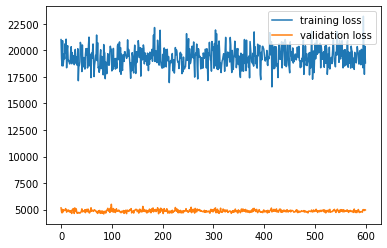

In [9]:
# split2 - different lr, more epchs, larger batch, dropout, loss with decaying_weights

loss_cfg = LossConfig(device, decaying_weights=True)

train_dataset = DustPredictionDataset(torch.load(meteorology_train_paths[1]),
                                      torch.load(dust_train_paths[1]),
                                      torch.load(metadata_times_train_paths[1]))
valid_dataset = DustPredictionDataset(torch.load(meteorology_valid_paths[1]),
                                      torch.load(dust_valid_paths[1]),
                                      torch.load(metadata_times_valid_paths[1]))
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True,collate_fn=train_dataset.collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=512, shuffle=True,collate_fn=train_dataset.collate_fn)

sample_data = next(iter(train_loader))
print("Sample data loading:")
print(sample_data[0][0].shape, sample_data[0][1].shape, len(sample_data[1]))

model_split2 = ViT.VisionTransformer(img_size=(81,81), patch_size=(9,9), in_chans=17, num_classes=10, embed_dim=512, 
                 depth=8, num_heads=8, mlp_ratio=2., qkv_bias=True, representation_size=None, distilled=False,
                 drop_rate=0.1, attn_drop_rate=0.1, drop_path_rate=0.1)
model_split2 = model_split2.to(device)

criterion = nn.MSELoss() # to be used inside the dust_loss
lr = 0.01
optimizer = torch.optim.Adam(model_split2.parameters(), lr=lr)
num_epochs = 600

train_losses_split2,valid_losses_split2 = train_loop(model_split2, optimizer, train_loader, valid_loader, 
                                                     device, epochs=num_epochs, valid_every=1,loss_cfg=loss_cfg,
                                                     sample_predictions_every=5, sample_size=5, sample_cols=[0],
                                                     loss_plot_end=True, debug=False)

In [10]:
# split5 

loss_cfg = LossConfig(device, decaying_weights=True)

train_dataset = DustPredictionDataset(torch.load(meteorology_train_paths[4]),
                                      torch.load(dust_train_paths[4]),
                                      torch.load(metadata_times_train_paths[4]))
valid_dataset = DustPredictionDataset(torch.load(meteorology_valid_paths[4]),
                                      torch.load(dust_valid_paths[4]),
                                      torch.load(metadata_times_valid_paths[4]))
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True,collate_fn=dust_prediction_collate)
valid_loader = DataLoader(valid_dataset, batch_size=512, shuffle=True,collate_fn=dust_prediction_collate)

sample_data = next(iter(train_loader))
print("Sample data loading:")
print(sample_data[0][0].shape, sample_data[0][1].shape, len(sample_data[1]))

model_split5 = ViT.VisionTransformer(img_size=(81,81), patch_size=(9,9), in_chans=17, num_classes=10, embed_dim=512, 
                 depth=8, num_heads=8, mlp_ratio=2., qkv_bias=True, representation_size=None, distilled=False,
                 drop_rate=0.1, attn_drop_rate=0.1, drop_path_rate=0.1)
model_split5 = model_split5.to(device)

criterion = nn.MSELoss() # to be used inside the dust_loss
lr = 0.001
optimizer = torch.optim.Adam(model_split5.parameters(), lr=lr)
num_epochs = 600

train_losses_split5,valid_losses_split5 = train_loop(model_split5, optimizer, train_loader, valid_loader, 
                                                     device, epochs=num_epochs, valid_every=1,loss_cfg=loss_cfg,
                                                     sample_predictions_every=5, sample_size=5, sample_cols=[0],
                                                     loss_plot_end=True, debug=False)

Sample data loading:
torch.Size([512, 17, 81, 81]) torch.Size([512, 10]) 512
Training... (Precision = out all of predicted events, <> were correct, Recall = out of all events, predicted <>)


Train   Epoch: 001 / 600   Loss: 1.436e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss: 1.406e+04   Precision: 0.000%   Recall: 0.000%
Train   Epoch: 002 / 600   Loss: 1.279e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss: 1.352e+04   Precision: 0.000%   Recall: 0.000%
Train   Epoch: 003 / 600   Loss: 1.203e+04   Precision: 39.840%   Recall: 42.280%
Valid                   Loss: 1.366e+04   Precision: 14.085%   Recall: 100.000%
Train   Epoch: 004 / 600   Loss: 1.19e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss: 1.376e+04   Precision: 14.085%   Recall: 100.000%
Train   Epoch: 005 / 600   Loss: 1.261e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss: 1.377e+04   Precision: 14.085%   Recall: 100.000%
       

Train   Epoch: 041 / 600   Loss: 1.215e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss: 1.376e+04   Precision: 14.085%   Recall: 100.000%
Train   Epoch: 042 / 600   Loss: 1.278e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss: 1.383e+04   Precision: 14.085%   Recall: 100.000%
Train   Epoch: 043 / 600   Loss: 1.229e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss: 1.381e+04   Precision: 14.085%   Recall: 100.000%
Train   Epoch: 044 / 600   Loss: 1.212e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss: 1.383e+04   Precision: 14.085%   Recall: 100.000%
Train   Epoch: 045 / 600   Loss: 1.191e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss: 1.377e+04   Precision: 14.085%   Recall: 100.000%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[89.58115387 75.25      ]
	 [89.58113098 39.78333333]
	 [89.58110809 85.13333333]
	 [89.58113861 26.71666667]
	 [89.58

Train   Epoch: 081 / 600   Loss: 1.212e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss: 1.38e+04   Precision: 14.085%   Recall: 100.000%
Train   Epoch: 082 / 600   Loss: 1.234e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss: 1.377e+04   Precision: 14.085%   Recall: 100.000%
Train   Epoch: 083 / 600   Loss: 1.268e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss: 1.381e+04   Precision: 14.085%   Recall: 100.000%
Train   Epoch: 084 / 600   Loss: 1.22e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss: 1.38e+04   Precision: 14.085%   Recall: 100.000%
Train   Epoch: 085 / 600   Loss: 1.2e+04   Precision: 39.842%   Recall: 100.000%
Valid                   Loss: 1.38e+04   Precision: 14.085%   Recall: 100.000%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[90.90238953 20.16666667]
	 [90.90234375 29.5       ]
	 [90.90226746 69.05      ]
	 [90.90203857 13.18333333]
	 [90.90258789

KeyboardInterrupt: 

Sample data loading:
torch.Size([512, 17, 81, 81]) torch.Size([512, 10]) 512
Training... (Precision = out all of predicted events, <> were correct, Recall = out of all events, predicted <>)


Train   Epoch: 001 / 010   Loss: 1.595e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss: 1.549e+04   Precision: 0.000%   Recall: 0.000%
Train   Epoch: 002 / 010   Loss: 1.497e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss: 1.548e+04   Precision: 0.000%   Recall: 0.000%
Train   Epoch: 003 / 010   Loss: 1.495e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss: 1.546e+04   Precision: 0.000%   Recall: 0.000%
Train   Epoch: 004 / 010   Loss: 1.544e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss: 1.544e+04   Precision: 0.000%   Recall: 0.000%
Train   Epoch: 005 / 010   Loss: 1.612e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss: 1.543e+04   Precision: 0.000%   Recall: 0.000%
        [Sample predict

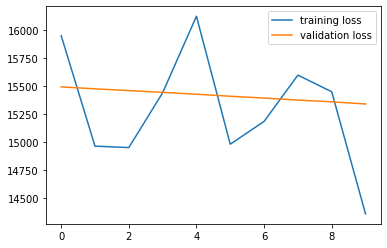

Training... (Precision = out all of predicted events, <> were correct, Recall = out of all events, predicted <>)


Train   Epoch: 001 / 070   Loss: 1.537e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss: 1.532e+04   Precision: 0.000%   Recall: 0.000%
Train   Epoch: 002 / 070   Loss: 1.564e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss: 1.531e+04   Precision: 0.000%   Recall: 0.000%
Train   Epoch: 003 / 070   Loss: 1.471e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss: 1.529e+04   Precision: 0.000%   Recall: 0.000%
Train   Epoch: 004 / 070   Loss: 1.465e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss: 1.527e+04   Precision: 0.000%   Recall: 0.000%
Train   Epoch: 005 / 070   Loss: 1.503e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss: 1.525e+04   Precision: 0.000%   Recall: 0.000%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[10.30138874 35.88333333]
	 [10.3

Train   Epoch: 042 / 070   Loss: 1.353e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss: 1.46e+04   Precision: 0.000%   Recall: 0.000%
Train   Epoch: 043 / 070   Loss: 1.416e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss: 1.459e+04   Precision: 0.000%   Recall: 0.000%
Train   Epoch: 044 / 070   Loss: 1.41e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss: 1.457e+04   Precision: 0.000%   Recall: 0.000%
Train   Epoch: 045 / 070   Loss: 1.392e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss: 1.456e+04   Precision: 0.000%   Recall: 0.000%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[21.13384819 84.5       ]
	 [21.1293602  25.85      ]
	 [21.12927818 25.        ]
	 [21.13012695  8.13333333]
	 [21.12964821 52.55      ]]
Train   Epoch: 046 / 070   Loss: 1.38e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss: 1.454e+04   Precision: 0.000%   Recall: 0.000%
Train   Epoc

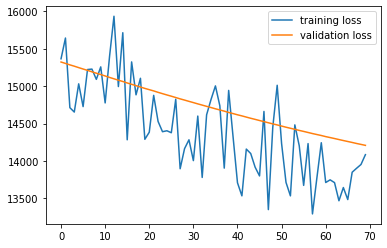

Training... (Precision = out all of predicted events, <> were correct, Recall = out of all events, predicted <>)


Train   Epoch: 001 / 012   Loss: 1.397e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss: 1.42e+04   Precision: 0.000%   Recall: 0.000%
Train   Epoch: 002 / 012   Loss: 1.353e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss: 1.418e+04   Precision: 0.000%   Recall: 0.000%
Train   Epoch: 003 / 012   Loss: 1.373e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss: 1.417e+04   Precision: 0.000%   Recall: 0.000%
Train   Epoch: 004 / 012   Loss: 1.291e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss: 1.416e+04   Precision: 0.000%   Recall: 0.000%
Train   Epoch: 005 / 012   Loss: 1.351e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss: 1.415e+04   Precision: 0.000%   Recall: 0.000%
        [Sample predictions | targets] (cols [:1] |  cols [1:]):
	[[29.51345634 36.66666667]
	 [29.51

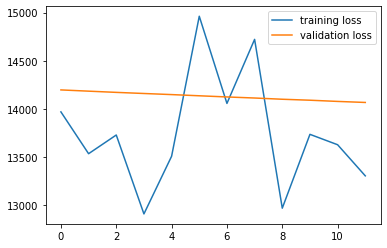

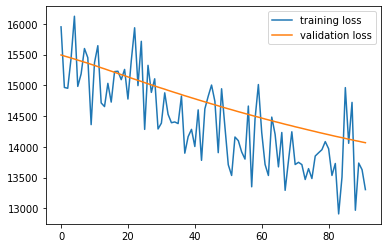

In [14]:
# split5 - changing learning rates

from training.dust_loss import *
loss_cfg = LossConfig(device, decaying_weights=True)

train_dataset = DustPredictionDataset(torch.load(meteorology_train_paths[4]),
                                      torch.load(dust_train_paths[4]),
                                      torch.load(metadata_times_train_paths[4]))
valid_dataset = DustPredictionDataset(torch.load(meteorology_valid_paths[4]),
                                      torch.load(dust_valid_paths[4]),
                                      torch.load(metadata_times_valid_paths[4]))
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True,collate_fn=train_dataset.collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=512, shuffle=True,collate_fn=train_dataset.collate_fn)

sample_data = next(iter(train_loader))
print("Sample data loading:")
print(sample_data[0][0].shape, sample_data[0][1].shape, len(sample_data[1]))

model_split5 = ViT.VisionTransformer(img_size=(81,81), patch_size=(9,9), in_chans=17, num_classes=10, embed_dim=512, 
                 depth=8, num_heads=8, mlp_ratio=2., qkv_bias=True, representation_size=None, distilled=False,
                 drop_rate=0.1, attn_drop_rate=0.1, drop_path_rate=0.1)
model_split5 = model_split5.to(device)

criterion = nn.MSELoss() # to be used inside the dust_loss
optimizer = torch.optim.Adam(model_split5.parameters(), lr=lr)
train_losses_split5,valid_losses_split5 = [],[]


lr = 0.0001
num_epochs = 10
train_losses,valid_losses = train_loop(model_split5, optimizer, train_loader, valid_loader, 
                                                     device, epochs=num_epochs, valid_every=1,loss_cfg=loss_cfg,
                                                     sample_predictions_every=5, sample_size=5, sample_cols=[0],
                                                     loss_plot_end=True, debug=False)
train_losses_split5+=train_losses
valid_losses_split5+=valid_losses

lr = 0.00001
num_epochs = 70
train_losses,valid_losses = train_loop(model_split5, optimizer, train_loader, valid_loader, 
                                                     device, epochs=num_epochs, valid_every=1,loss_cfg=loss_cfg,
                                                     sample_predictions_every=5, sample_size=5, sample_cols=[0],
                                                     loss_plot_end=True, debug=False)
train_losses_split5+=train_losses
valid_losses_split5+=valid_losses

lr = 0.000001
num_epochs = 12
train_losses,valid_losses = train_loop(model_split5, optimizer, train_loader, valid_loader, 
                                                     device, epochs=num_epochs, valid_every=1,loss_cfg=loss_cfg,
                                                     sample_predictions_every=5, sample_size=5, sample_cols=[0],
                                                     loss_plot_end=True, debug=False)
train_losses_split5+=train_losses
valid_losses_split5+=valid_losses

from utils.training_loop_plotting import *
plot_train_valid(train_losses_split5,valid_losses_split5)

Sample data loading:
torch.Size([512, 17, 81, 81]) torch.Size([512, 10]) 512
Training... (Precision = out all of predicted events, <> were correct, Recall = out of all events, predicted <>)


Train   Epoch: 001 / 030   Loss: 1.509e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss: 1.533e+04   Precision: 0.000%   Recall: 0.000%
Train   Epoch: 002 / 030   Loss: 1.52e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss: 1.516e+04   Precision: 0.000%   Recall: 0.000%
Train   Epoch: 003 / 030   Loss: 1.415e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss: 1.498e+04   Precision: 0.000%   Recall: 0.000%
Train   Epoch: 004 / 030   Loss: 1.439e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss: 1.479e+04   Precision: 0.000%   Recall: 0.000%
Train   Epoch: 005 / 030   Loss: 1.395e+04   Precision: 0.000%   Recall: 0.000%
Valid                   Loss: 1.463e+04   Precision: 0.000%   Recall: 0.000%
        [Sample predicti

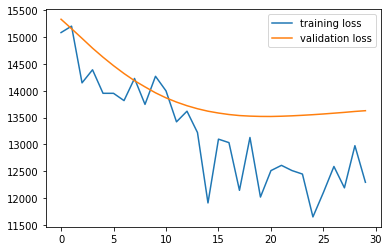

In [15]:
# split5 - different lr, more epchs, larger batch, dropout, loss with decaying_weights

from training.dust_loss import *
loss_cfg = LossConfig(device, decaying_weights=True)

train_dataset = DustPredictionDataset(torch.load(meteorology_train_paths[4]),
                                      torch.load(dust_train_paths[4]),
                                      torch.load(metadata_times_train_paths[4]))
valid_dataset = DustPredictionDataset(torch.load(meteorology_valid_paths[4]),
                                      torch.load(dust_valid_paths[4]),
                                      torch.load(metadata_times_valid_paths[4]))
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True,collate_fn=train_dataset.collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=512, shuffle=True,collate_fn=train_dataset.collate_fn)

sample_data = next(iter(train_loader))
print("Sample data loading:")
print(sample_data[0][0].shape, sample_data[0][1].shape, len(sample_data[1]))

model_split5 = ViT.VisionTransformer(img_size=(81,81), patch_size=(9,9), in_chans=17, num_classes=10, embed_dim=512, 
                 depth=8, num_heads=8, mlp_ratio=2., qkv_bias=True, representation_size=None, distilled=False,
                 drop_rate=0.1, attn_drop_rate=0.1, drop_path_rate=0.1)
model_split5 = model_split5.to(device)

criterion = nn.MSELoss() # to be used inside the dust_loss
lr = 0.0001
optimizer = torch.optim.Adam(model_split5.parameters(), lr=lr)
num_epochs = 30

train_losses_split5,valid_losses_split5 = train_loop(model_split5, optimizer, train_loader, valid_loader, 
                                                     device, epochs=num_epochs, valid_every=1,loss_cfg=loss_cfg,
                                                     sample_predictions_every=5, sample_size=5, sample_cols=[0],
                                                     loss_plot_end=True, debug=False)

In [55]:
# # some tests with loss
# import torch.nn as nn
# loss_test = nn.MSELoss(reduction="none")
# t1 = torch.ones([3,5])
# t1[1,:] = 2
# t1[2,2] = 5
# w = torch.tensor([2.,1.,1.,1.,1.])
# t2 = torch.zeros([3,5])
# print(t1, loss_test(t1,t2), loss_test(t1,t2).mean())
# print(w*loss_test(t1,t2), (w*loss_test(t1,t2)).mean())
# print(loss_test(t1,t2).mean(0))

In [54]:
# from utils.metrics import *
# tensor_metric = Metric()
# tensor_metric.update(torch.ones([5]),1)
# tensor_metric.update(torch.zeros([5]),1)
# tensor_metric.update(torch.ones([5])*2.,3)
# losses_list = [tensor_metric.avg,2*tensor_metric.avg,2*tensor_metric.avg]
# print(losses_list)
# all_losses = torch.stack(losses_list,0).cpu().detach().numpy()
# print(all_losses)